# Team Assignment - Intentionally Blank

The following libraries should be installed before proceeding further:
- pandas
- numpy
- matplotlib
- seaborn
- sklearn
- **folium** (conda install -c conda-forge folium)
- **branca** (Should automatically be installed with folium)
- **plotly** (conda install -c plotly plotly=5.10.0)

In [1]:
#Import all necessary libraries
import os
import math
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# also import these "new" libraries 
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')
# !important! Install this version of plotly=5.10.0 or else some maps and animations may not render correctly
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import HeatMap
from branca.element import Figure

# import the necessary libraries for the machine learning models
from sklearn.linear_model import \
    Lasso, Ridge, RidgeCV, LinearRegression
from sklearn.preprocessing import \
    StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In addition to the available datasets from the team assignment the original dataset is read for additional information about each ride. The additional information contains the geographical coordinates for the start position and the end position of each ride.

In [2]:
# Reading in weather and philadelphia_2017 data
df_weather = pd.read_csv("data/weather_hourly_philadelphia.csv")
df_philadelphia_2017 = pd.read_csv("data/philadelphia_2017.csv")

# Additionally read the philadelphia data from the official website
data_philadelphia_2017_Q1 = pd.read_csv("data/indego_Q1_2017.csv")
data_philadelphia_2017_Q2 = pd.read_csv("data/indego_Q2_2017.csv")
data_philadelphia_2017_Q3 = pd.read_csv("data/indego_Q3_2017.csv")
data_philadelphia_2017_Q4 = pd.read_csv("data/indego_Q4_2017.csv")

## Preparing and cleaning data

### Preparing and cleaning the philadelphia datasets

In [3]:
# Concatenate all quarters of philadelphia data and convert them to a dataframe
df_philadelphia_website = pd.concat([data_philadelphia_2017_Q1, data_philadelphia_2017_Q2, data_philadelphia_2017_Q3, data_philadelphia_2017_Q4], ignore_index=True)

In [4]:
# Dropping the columns duration, start_station_id, end_station_id, plan_duration, trip_route_category, passholder_type, start_station, end_station
df_philadelphia_website.drop(['duration', 'start_station_id', 'end_station_id', 'plan_duration', 'trip_route_category', 'passholder_type', 'start_station', 'end_station', 'trip_id'], axis=1, inplace=True)
df_philadelphia_website

#Changing the type of start_time, end_time (df_philadelphia_2017 and df_philadelphia_website) and date_time (df_weather) to datetime type from pandas
df_philadelphia_website.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_website['start_time'])
df_philadelphia_website.loc[:,'end_time'] = pd.to_datetime(df_philadelphia_website['end_time'])

df_philadelphia_2017.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_2017['start_time'])
df_philadelphia_2017.loc[:,"end_time"] = pd.to_datetime(df_philadelphia_2017["end_time"])

#Sort dataframes by their corresponding time column
df_philadelphia_website.sort_values(["start_time"], inplace = True)
df_philadelphia_2017.sort_values(["start_time"], inplace = True)


#Resetting the indexes
df_philadelphia_website.reset_index(drop = True, inplace = True)
df_philadelphia_2017.reset_index(drop = True, inplace = True)

Before we further clean the dataset for philadelphia its important to mention that we first deleted the irrelevant stations because some duplicate rows happen to have the same start time, end time and bike ids but different start and end stations like the "Virtual Station". Therefore we deleted those stations first to avoid deleting useful records. In the following example you can see that deleting the duplicates first could lead to deleting useful records and keeping irrelevant records which are deleted either way later.

In [5]:
df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'], keep=False)].head(6)

start_time            end_time  start_station_id  \
255753 2017-06-05 15:26:00 2017-06-05 15:27:00              3152   
255755 2017-06-05 15:26:00 2017-06-05 15:27:00              3000   
256143 2017-06-05 17:26:00 2017-06-05 17:31:00              3152   
256148 2017-06-05 17:26:00 2017-06-05 17:31:00              3000   
258113 2017-06-06 16:02:00 2017-06-06 16:33:00              3004   
258115 2017-06-06 16:02:00 2017-06-06 16:33:00              3004   

        end_station_id  bike_id user_type                 start_station_name  \
255753            3152    11907  Indego30   40th & Baltimore, Trolley Portal   
255755            3000    11907  Indego30                    Virtual Station   
256143            3024    11907   Walk-up   40th & Baltimore, Trolley Portal   
256148            3024    11907   Walk-up                    Virtual Station   
258113            3000     5314  Indego30  Municipal Services Building Plaza   
258115            3161     5314  Indego30  Municipal Services Building Plaza   

                        end_station_name  
255753  40th & Baltimore, Trolley Portal  
255755                   Virtual Station  
256143        43rd & Chester, Clark Park  
256148        43rd & Chester, Clark Park  
258113                   Virtual Station  
258115          30th Street Station East

The "3083" station does not exist as a real station. Furthermore the "Virtual Station" is used by staff to check in or check out a bike remotely for an event or when the bike was not properly checked in or out. Therefore we check the number of rows where one of those stations occur and delete those rows afterwards.

For further information please check the official site about the data and the station table [here](https://www.rideindego.com/about/data/).

In [6]:
print(r'Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station: ',
 df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") |
  (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")
  ].shape[0])

Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station:  6512


In [7]:
# Deleting "Virtual Station" and "3083" from the start_station_name and end_station_name columns
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "3083") & (df_philadelphia_2017["end_station_name"] != "3083") ]
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "Virtual Station") & (df_philadelphia_2017["end_station_name"] != "Virtual Station") ]

display(df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") | (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")])

Empty DataFrame
Columns: [start_time, end_time, start_station_id, end_station_id, bike_id, user_type, start_station_name, end_station_name]
Index: []

The "bike_id" should be unique to one bike. No trip with the same bike_id should start and end on the same time interval. 

In [8]:
#Checking for any duplicates in philadelphia data
print("Number of duplicates in df_philadelphia_2017: ", df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())
print("Number of duplicates in df_philadelphia_website: ", df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())

Number of duplicates in df_philadelphia_2017:  55
Number of duplicates in df_philadelphia_website:  68


In [9]:
#Dropping all duplicates for the philadelphia data depending on the start_time, end_time and bike_id
df_philadelphia_2017.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)
df_philadelphia_website.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)

display(df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))
display(df_philadelphia_website[df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))

Empty DataFrame
Columns: [start_time, end_time, start_station_id, end_station_id, bike_id, user_type, start_station_name, end_station_name]
Index: []

Empty DataFrame
Columns: [start_time, end_time, start_lat, start_lon, end_lat, end_lon, bike_id]
Index: []

In [10]:
# Joining df_philadelphia_2017 with df_philadelphia_full on start_time, end_time, bike_id and dropping duplicate columns
df_philadelphia_2017_joined = df_philadelphia_2017.merge(df_philadelphia_website, on=["start_time", "end_time", "bike_id"], how="left")

df_philadelphia_2017_joined

start_time            end_time  start_station_id  \
0      2017-01-01 00:05:00 2017-01-01 00:16:00              3046   
1      2017-01-01 00:21:00 2017-01-01 00:57:00              3110   
2      2017-01-01 00:22:00 2017-01-01 00:57:00              3110   
3      2017-01-01 00:27:00 2017-01-01 00:39:00              3041   
4      2017-01-01 00:28:00 2017-01-01 00:36:00              3047   
...                    ...                 ...               ...   
782335 2017-12-31 23:05:00 2017-12-31 23:33:00              3070   
782336 2017-12-31 23:11:00 2018-01-01 11:03:00              3107   
782337 2017-12-31 23:18:00 2017-12-31 23:25:00              3033   
782338 2017-12-31 23:39:00 2017-12-31 23:40:00              3163   
782339 2017-12-31 23:41:00 2017-12-31 23:55:00              3163   

        end_station_id  bike_id user_type           start_station_name  \
0                 3041     5347  Indego30                 2nd & Market   
1                 3054     3364   Walk-up  Del. River Trail & Penn St.   
2                 3054     2536   Walk-up  Del. River Trail & Penn St.   
3                 3005     5176  Indego30          Girard Station, MFL   
4                 3124     5370   Walk-up       Independence Mall, NPS   
...                ...      ...       ...                          ...   
782335            3124     3708  Indego30   Spring Garden Station, MFL   
782336            3165     5117  Indego30             33rd & Reservoir   
782337            3046    11933  Indego30              10th & Chestnut   
782338            3163     6725  Indego30                25th & Locust   
782339            3057    11864  Indego30                25th & Locust   

                  end_station_name  start_lat  start_lon    end_lat    end_lon  
0              Girard Station, MFL  39.950119 -75.144722  39.968491 -75.135460  
1                     Rodin Museum  39.961750 -75.136414  39.962502 -75.174202  
2                     Rodin Museum  39.961750 -75.136414  39.962502 -75.174202  
3                Welcome Park, NPS  39.968491 -75.135460  39.947330 -75.144028  
4                 Race Street Pier  39.950710 -75.149208  39.952950 -75.139793  
...                            ...        ...        ...        ...        ...  
782335            Race Street Pier  39.960621 -75.139832  39.952950 -75.139793  
782336             24th & Race SRT  39.982029 -75.188660  39.958191 -75.178200  
782337                2nd & Market  39.950050 -75.156723  39.950119 -75.144722  
782338               25th & Locust  39.949741 -75.180969  39.949741 -75.180969  
782339  Philadelphia Museum of Art  39.949741 -75.180969  39.964581 -75.180031  

[782340 rows x 12 columns]

In [11]:
#Checking for missing values in philadelphia data
display(df_philadelphia_2017_joined[df_philadelphia_2017_joined.isnull().any(axis = 1)])

start_time            end_time  start_station_id  \
255784 2017-06-06 16:02:00 2017-06-06 16:33:00              3004   
613438 2017-10-05 08:35:00 2017-10-05 08:47:00              3111   
613848 2017-10-05 10:31:00 2017-10-05 10:53:00              3095   

        end_station_id  bike_id user_type                 start_station_name  \
255784            3161     5314  Indego30  Municipal Services Building Plaza   
613438            3107     5306  Indego30  Parkside & Belmont, Case Building   
613848            3111     5329  Indego30                     29th & Diamond   

                         end_station_name  start_lat  start_lon    end_lat  \
255784           30th Street Station East  39.953781 -75.163742        NaN   
613438                   33rd & Reservoir        NaN        NaN  39.982029   
613848  Parkside & Belmont, Case Building  39.987709 -75.180519        NaN   

         end_lon  
255784       NaN  
613438 -75.18866  
613848       NaN

In [12]:
df_philadelphia_2017_joined.dropna(inplace = True)	

In [13]:
#Adding hour, month, weekday and trip duration(based on start and end time) to the table
df_philadelphia_2017_joined.loc[:,"trip_duration"] = df_philadelphia_2017_joined["end_time"] - df_philadelphia_2017_joined["start_time"] 
df_philadelphia_2017_joined.loc[:,"date"] = df_philadelphia_2017_joined["start_time"].dt.date
df_philadelphia_2017_joined.loc[:,"month"] = df_philadelphia_2017_joined["start_time"].dt.month
df_philadelphia_2017_joined.loc[:,"week"] = df_philadelphia_2017_joined["start_time"].dt.isocalendar().week
df_philadelphia_2017_joined.loc[:,"weekday"] = df_philadelphia_2017_joined["start_time"].dt.weekday
df_philadelphia_2017_joined.loc[:,"day"] = df_philadelphia_2017_joined["start_time"].dt.day
df_philadelphia_2017_joined.loc[:,"hour"] = df_philadelphia_2017_joined["start_time"].dt.hour
df_philadelphia_2017_joined

start_time            end_time  start_station_id  \
0      2017-01-01 00:05:00 2017-01-01 00:16:00              3046   
1      2017-01-01 00:21:00 2017-01-01 00:57:00              3110   
2      2017-01-01 00:22:00 2017-01-01 00:57:00              3110   
3      2017-01-01 00:27:00 2017-01-01 00:39:00              3041   
4      2017-01-01 00:28:00 2017-01-01 00:36:00              3047   
...                    ...                 ...               ...   
782335 2017-12-31 23:05:00 2017-12-31 23:33:00              3070   
782336 2017-12-31 23:11:00 2018-01-01 11:03:00              3107   
782337 2017-12-31 23:18:00 2017-12-31 23:25:00              3033   
782338 2017-12-31 23:39:00 2017-12-31 23:40:00              3163   
782339 2017-12-31 23:41:00 2017-12-31 23:55:00              3163   

        end_station_id  bike_id user_type           start_station_name  \
0                 3041     5347  Indego30                 2nd & Market   
1                 3054     3364   Walk-up  Del. River Trail & Penn St.   
2                 3054     2536   Walk-up  Del. River Trail & Penn St.   
3                 3005     5176  Indego30          Girard Station, MFL   
4                 3124     5370   Walk-up       Independence Mall, NPS   
...                ...      ...       ...                          ...   
782335            3124     3708  Indego30   Spring Garden Station, MFL   
782336            3165     5117  Indego30             33rd & Reservoir   
782337            3046    11933  Indego30              10th & Chestnut   
782338            3163     6725  Indego30                25th & Locust   
782339            3057    11864  Indego30                25th & Locust   

                  end_station_name  start_lat  start_lon    end_lat  \
0              Girard Station, MFL  39.950119 -75.144722  39.968491   
1                     Rodin Museum  39.961750 -75.136414  39.962502   
2                     Rodin Museum  39.961750 -75.136414  39.962502   
3                Welcome Park, NPS  39.968491 -75.135460  39.947330   
4                 Race Street Pier  39.950710 -75.149208  39.952950   
...                            ...        ...        ...        ...   
782335            Race Street Pier  39.960621 -75.139832  39.952950   
782336             24th & Race SRT  39.982029 -75.188660  39.958191   
782337                2nd & Market  39.950050 -75.156723  39.950119   
782338               25th & Locust  39.949741 -75.180969  39.949741   
782339  Philadelphia Museum of Art  39.949741 -75.180969  39.964581   

          end_lon   trip_duration        date  month  week  weekday  day  hour  
0      -75.135460 0 days 00:11:00  2017-01-01      1    52        6    1     0  
1      -75.174202 0 days 00:36:00  2017-01-01      1    52        6    1     0  
2      -75.174202 0 days 00:35:00  2017-01-01      1    52        6    1     0  
3      -75.144028 0 days 00:12:00  2017-01-01      1    52        6    1     0  
4      -75.139793 0 days 00:08:00  2017-01-01      1    52        6    1     0  
...           ...             ...         ...    ...   ...      ...  ...   ...  
782335 -75.139793 0 days 00:28:00  2017-12-31     12    52        6   31    23  
782336 -75.178200 0 days 11:52:00  2017-12-31     12    52        6   31    23  
782337 -75.144722 0 days 00:07:00  2017-12-31     12    52        6   31    23  
782338 -75.180969 0 days 00:01:00  2017-12-31     12    52        6   31    23  
782339 -75.180031 0 days 00:14:00  2017-12-31     12    52        6   31    23  

[782337 rows x 19 columns]

We also remove trips which are shorter than one minute and longer than one day because the bike sharing service does not allow those trips normally.

In [14]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

start_time            end_time  start_station_id  \
699155 2017-11-05 01:35:00 2017-11-05 01:03:00              3118   
699158 2017-11-05 01:39:00 2017-11-05 01:35:00              3066   
699163 2017-11-05 01:51:00 2017-11-05 01:20:00              3157   

        end_station_id  bike_id user_type           start_station_name  \
699155            3111     6694  Indego30     46th Street Station, MFL   
699158            3066     2551  Indego30               19th & Lombard   
699163            3041    11750  Indego30  8th & Mifflin, Bok Building   

                         end_station_name  start_lat  start_lon    end_lat  \
699155  Parkside & Belmont, Case Building  39.958660 -75.213226  39.977791   
699158                     19th & Lombard  39.945610 -75.173477  39.945610   
699163                Girard Station, MFL  39.925449 -75.159538  39.968491   

          end_lon     trip_duration        date  month  week  weekday  day  \
699155 -75.213226 -1 days +23:28:00  2017-11-05     11    44        6    5   
699158 -75.173477 -1 days +23:56:00  2017-11-05     11    44        6    5   
699163 -75.135460 -1 days +23:29:00  2017-11-05     11    44        6    5   

        hour  
699155     1  
699158     1  
699163     1

In [15]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] >= "0 days 00:01:00"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

Empty DataFrame
Columns: [start_time, end_time, start_station_id, end_station_id, bike_id, user_type, start_station_name, end_station_name, start_lat, start_lon, end_lat, end_lon, trip_duration, date, month, week, weekday, day, hour]
Index: []

In [16]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

start_time            end_time  start_station_id  \
682    2017-01-01 18:19:00 2017-01-03 08:04:00              3072   
20987  2017-01-23 15:19:00 2017-01-24 16:14:00              3038   
24873  2017-01-26 17:31:00 2017-01-28 10:00:00              3021   
27216  2017-01-28 15:46:00 2017-01-30 08:01:00              3012   
32762  2017-02-02 09:45:00 2017-02-03 17:59:00              3054   
...                    ...                 ...               ...   
735895 2017-11-25 12:12:00 2017-11-27 07:31:00              3112   
749711 2017-12-02 13:00:00 2017-12-03 14:12:00              3040   
763091 2017-12-11 11:46:00 2017-12-12 13:15:00              3018   
768955 2017-12-15 19:27:00 2017-12-17 16:32:00              3026   
769501 2017-12-17 00:31:00 2017-12-18 13:17:00              3088   

        end_station_id  bike_id user_type  \
682               3125     5354   Walk-up   
20987             3028     2492  Indego30   
24873             3109     5185  Indego30   
27216             3034     5255   Walk-up   
32762             3021     5125  Indego30   
...                ...      ...       ...   
735895            3020    11894  Indego30   
749711            3073    11928   Walk-up   
763091            3037     3367  Indego30   
768955            3072    11932  Indego30   
769501            3070    11727   Walk-up   

                                    start_station_name  \
682                                  Front & Carpenter   
20987   The Children's Hospital of Philadelphia (CHOP)   
24873                                       18th & JFK   
27216                                 21st & Catharine   
32762                                     Rodin Museum   
...                                                ...   
735895                                   48th & Spruce   
749711                            17th & Spring Garden   
763091                                  12th & Filbert   
768955                                     2nd & South   
769501                                    3rd & Girard   

                      end_station_name  start_lat  start_lon    end_lat  \
682                       15th & South  39.934448 -75.145409  39.943909   
20987                 4th & Bainbridge  39.947811 -75.194092  39.940609   
24873                Parkside & Girard  39.953899 -75.169022  39.974861   
27216                      11th & Reed  39.942181 -75.177467  39.933151   
32762                       18th & JFK  39.962502 -75.174202  39.953899   
...                                ...        ...        ...        ...   
735895         University City Station  39.953732 -75.218246  39.949219   
749711             9th & Spring Garden  39.962891 -75.166061  39.961430   
763091  Pennsylvania Convention Center  39.952728 -75.159790  39.954239   
768955               Front & Carpenter  39.941380 -75.145638  39.934448   
769501      Spring Garden Station, MFL  39.969841 -75.141800  39.960621   

          end_lon   trip_duration        date  month  week  weekday  day  hour  
682    -75.167351 1 days 13:45:00  2017-01-01      1    52        6    1    18  
20987  -75.149582 1 days 00:55:00  2017-01-23      1     4        0   23    15  
24873  -75.205238 1 days 16:29:00  2017-01-26      1     4        3   26    17  
27216  -75.162483 1 days 16:15:00  2017-01-28      1     4        5   28    15  
32762  -75.169022 1 days 08:14:00  2017-02-02      2     5        3    2     9  
...           ...             ...         ...    ...   ...      ...  ...   ...  
735895 -75.190361 1 days 19:19:00  2017-11-25     11    47        5   25    12  
749711 -75.152420 1 days 01:12:00  2017-12-02     12    48        5    2    13  
763091 -75.161377 1 days 01:29:00  2017-12-11     12    50        0   11    11  
768955 -75.145409 1 days 21:05:00  2017-12-15     12    50        4   15    19  
769501 -75.139832 1 days 12:46:00  2017-12-17     12    50        6   17     0  

[109 rows x 19 columns]

In [17]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] <= "1 days"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

Empty DataFrame
Columns: [start_time, end_time, start_station_id, end_station_id, bike_id, user_type, start_station_name, end_station_name, start_lat, start_lon, end_lat, end_lon, trip_duration, date, month, week, weekday, day, hour]
Index: []

In [18]:
df_philadelphia_cleaned = df_philadelphia_2017_joined.copy()
df_philadelphia_cleaned

start_time            end_time  start_station_id  \
0      2017-01-01 00:05:00 2017-01-01 00:16:00              3046   
1      2017-01-01 00:21:00 2017-01-01 00:57:00              3110   
2      2017-01-01 00:22:00 2017-01-01 00:57:00              3110   
3      2017-01-01 00:27:00 2017-01-01 00:39:00              3041   
4      2017-01-01 00:28:00 2017-01-01 00:36:00              3047   
...                    ...                 ...               ...   
782335 2017-12-31 23:05:00 2017-12-31 23:33:00              3070   
782336 2017-12-31 23:11:00 2018-01-01 11:03:00              3107   
782337 2017-12-31 23:18:00 2017-12-31 23:25:00              3033   
782338 2017-12-31 23:39:00 2017-12-31 23:40:00              3163   
782339 2017-12-31 23:41:00 2017-12-31 23:55:00              3163   

        end_station_id  bike_id user_type           start_station_name  \
0                 3041     5347  Indego30                 2nd & Market   
1                 3054     3364   Walk-up  Del. River Trail & Penn St.   
2                 3054     2536   Walk-up  Del. River Trail & Penn St.   
3                 3005     5176  Indego30          Girard Station, MFL   
4                 3124     5370   Walk-up       Independence Mall, NPS   
...                ...      ...       ...                          ...   
782335            3124     3708  Indego30   Spring Garden Station, MFL   
782336            3165     5117  Indego30             33rd & Reservoir   
782337            3046    11933  Indego30              10th & Chestnut   
782338            3163     6725  Indego30                25th & Locust   
782339            3057    11864  Indego30                25th & Locust   

                  end_station_name  start_lat  start_lon    end_lat  \
0              Girard Station, MFL  39.950119 -75.144722  39.968491   
1                     Rodin Museum  39.961750 -75.136414  39.962502   
2                     Rodin Museum  39.961750 -75.136414  39.962502   
3                Welcome Park, NPS  39.968491 -75.135460  39.947330   
4                 Race Street Pier  39.950710 -75.149208  39.952950   
...                            ...        ...        ...        ...   
782335            Race Street Pier  39.960621 -75.139832  39.952950   
782336             24th & Race SRT  39.982029 -75.188660  39.958191   
782337                2nd & Market  39.950050 -75.156723  39.950119   
782338               25th & Locust  39.949741 -75.180969  39.949741   
782339  Philadelphia Museum of Art  39.949741 -75.180969  39.964581   

          end_lon   trip_duration        date  month  week  weekday  day  hour  
0      -75.135460 0 days 00:11:00  2017-01-01      1    52        6    1     0  
1      -75.174202 0 days 00:36:00  2017-01-01      1    52        6    1     0  
2      -75.174202 0 days 00:35:00  2017-01-01      1    52        6    1     0  
3      -75.144028 0 days 00:12:00  2017-01-01      1    52        6    1     0  
4      -75.139793 0 days 00:08:00  2017-01-01      1    52        6    1     0  
...           ...             ...         ...    ...   ...      ...  ...   ...  
782335 -75.139793 0 days 00:28:00  2017-12-31     12    52        6   31    23  
782336 -75.178200 0 days 11:52:00  2017-12-31     12    52        6   31    23  
782337 -75.144722 0 days 00:07:00  2017-12-31     12    52        6   31    23  
782338 -75.180969 0 days 00:01:00  2017-12-31     12    52        6   31    23  
782339 -75.180031 0 days 00:14:00  2017-12-31     12    52        6   31    23  

[782225 rows x 19 columns]

### Preparing and cleaning the weather dataset

After preparing and cleaning the philadelphia dataset we need to do most of the procedure on the weather dataset.

In [19]:
#Changing the type of date_time (df_weather) to datetime type from pandas
df_weather.loc[:, "date_time"] = pd.to_datetime(df_weather["date_time"])

#Sort the dataframe by their corresponding time column
df_weather.sort_values(["date_time"], inplace = True)

#Reset the index
df_weather.reset_index(drop = True, inplace =True)

First of all we check for duplicate rows in the weather data and delete them if they occur because we do not need multiple rows multiple times.

In [20]:
#Checking for any duplicates in weather data
print("Number of duplicates in df_weather: ", df_weather.duplicated().sum())

Number of duplicates in df_weather:  630


In [21]:
#Dropping all duplicates for the weather data
df_weather.drop_duplicates(subset= ["date_time"],inplace = True)

display(df_weather[df_weather.duplicated()])

Empty DataFrame
Columns: [date_time, max_temp, min_temp, precip]
Index: []

We also check for null values in the weather data and delete them. It is important to note that we later add additional rows with null values but with the missing time intervals because we can interpolate them with the interpolate function in pandas.

In [22]:
#Checking for missing values in weather data
display(df_weather[df_weather.isnull().any(axis = 1)])

date_time  max_temp  min_temp  precip
43785       NaT       NaN       NaN     NaN

In [23]:
df_weather.dropna(inplace = True)

Since the weather data consists of data from the beginning of 2015 until the end of 2019, we want to have as well only the weather data for 2017.

In [24]:
#Selecting data from the beginning of 2017 till the end of 2017
df_weather_2017 = df_weather[(df_weather["date_time"]>= "2017-01-01 00:00:00") & (df_weather["date_time"]< "2018-01-01 00:00:00" )]

In [25]:
#Add missing intervals in the weather data
df_weather_2017.set_index("date_time", inplace = True)
df_weather_2017 = df_weather_2017.resample("H").asfreq()

The minimum temperature and maximum temperature will be interpolated linearly. The precipitation value is interpolated by taking one of the nearest existing values.

In [26]:
# Interpolate missing values in the weather data
df_weather_2017["min_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["max_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["precip"].interpolate(method = "pad", inplace = True)
df_weather_2017.reset_index(drop=False, inplace = True)

# Check if null values in the weather data still exist
display(df_weather_2017[df_weather_2017.isnull().any(axis = 1)])
display(df_weather_2017)

Empty DataFrame
Columns: [date_time, max_temp, min_temp, precip]
Index: []

date_time  max_temp  min_temp  precip
0    2017-01-01 00:00:00       6.1       6.1     0.0
1    2017-01-01 01:00:00       6.1       6.1     0.0
2    2017-01-01 02:00:00       6.7       6.7     0.0
3    2017-01-01 03:00:00       7.2       7.2     0.0
4    2017-01-01 04:00:00       7.8       7.8     0.0
...                  ...       ...       ...     ...
8755 2017-12-31 19:00:00      -8.9      -8.9     0.0
8756 2017-12-31 20:00:00      -8.9      -8.9     0.0
8757 2017-12-31 21:00:00      -9.4      -9.4     0.0
8758 2017-12-31 22:00:00     -10.0     -10.0     0.0
8759 2017-12-31 23:00:00     -10.0     -10.0     0.0

[8760 rows x 4 columns]

All dataframes for reference:
* **Philadelphia data**
   * *df_philadelphia_cleaned*
* **Weather data**
   * *df_weather_2017*

## Descriptive Analytics

### Temporal Demand Patterns and Seasonality

#### Analysis of Rental during the day

First count the started rentals for each hour of the day for the whole dataset and vizualize it in a histogram.

In [27]:
#Calculate the number of rentals in each hour (accumulated over the year)
df = df_philadelphia_cleaned
df.groupby(["hour"])["hour"].count().reset_index(name="n_rentals_within_hour")

hour  n_rentals_within_hour
0      0                   7657
1      1                   4901
2      2                   3326
3      3                   1630
4      4                   1729
5      5                   7182
6      6                  19860
7      7                  40014
8      8                  65742
9      9                  40390
10    10                  31922
11    11                  35048
12    12                  40044
13    13                  40484
14    14                  42091
15    15                  47248
16    16                  60542
17    17                  86868
18    18                  63984
19    19                  49715
20    20                  35075
21    21                  25403
22    22                  18737
23    23                  12633

In [28]:
#Calculate the mean
mean = df.groupby(["hour"])["hour"].count().mean()
mean

32592.708333333332

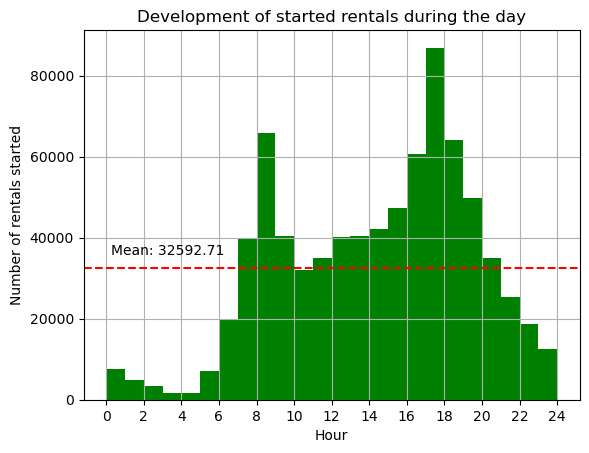

In [29]:
plt.hist(df["hour"], bins=range(0,25,1), color="green")
plt.axhline(mean , color = 'r', linestyle = '--')
plt.xlabel("Hour")
plt.ylabel("Number of rentals started")
plt.title("Development of started rentals during the day")
plt.xticks(range(0,25,2))
plt.grid(True)
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.2), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.show()

To get average values we calculate the number of days for which we have data in our dataset and calculate the avarage number of rentals started within each hour in a day.

IMPORTANT: The average values only provide meaningful results if we assume that we have all meaningful rental transactions that actually occurred included in our data set or at least equally distributed missing transaction for each hour.

In [30]:
#Check the number of days for which we have data in our set
number_days = len(df["date"].unique())
number_days

365

In [31]:
#Calculate average values for each hour
df_avg_per_hour = df.groupby(["hour"])["hour"].count().divide(number_days).reset_index(name="avg_n_rentals_within_hour")
df_avg_per_hour

hour  avg_n_rentals_within_hour
0      0                  20.978082
1      1                  13.427397
2      2                   9.112329
3      3                   4.465753
4      4                   4.736986
5      5                  19.676712
6      6                  54.410959
7      7                 109.627397
8      8                 180.115068
9      9                 110.657534
10    10                  87.457534
11    11                  96.021918
12    12                 109.709589
13    13                 110.915068
14    14                 115.317808
15    15                 129.446575
16    16                 165.868493
17    17                 237.994521
18    18                 175.298630
19    19                 136.205479
20    20                  96.095890
21    21                  69.597260
22    22                  51.334247
23    23                  34.610959

In [32]:
#Calculate mean
mean= df_avg_per_hour["avg_n_rentals_within_hour"].mean()
mean

89.29509132420094

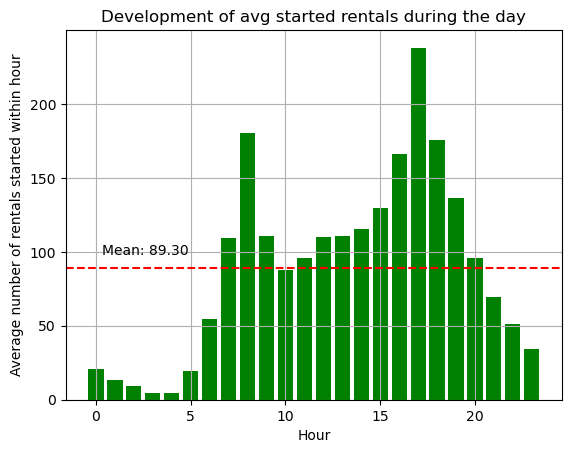

In [33]:
plt.bar(
        df_avg_per_hour["hour"], 
        df_avg_per_hour["avg_n_rentals_within_hour"], 
        color="green"
)
plt.axhline(mean , color = 'r', linestyle = '--')
plt.xlabel("Hour")
plt.ylabel("Average number of rentals started within hour")
plt.title("Development of avg started rentals during the day")
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.2), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.grid(True)
plt.show()

In the plots above we only considered the starting times of the rentals. To also considere the endtime, we calculate how many bikes in the respective hours were IN USE accumulated over the year. (e.g. rental from 0 o'clock to 2:45 would count as a usage in hour 0, 1 and 2). In the process of calculation we also have to considere that bike rentals can range over two days.

In [34]:
#Calculate average number of bikes in use
df["end_time_hour"] = df["end_time"].dt.hour
df["end_time_date"] = df["end_time"].dt.date
df_values = pd.DataFrame()
for i in range(0,24,1):
    df_values[f"{i}"]= (((df["hour"] <= i) & (df["end_time_hour"] >= i)) 
                        | ((df["end_time_hour"] >= i) & (df["date"] < df["end_time_date"])))

df_sum = df_values.apply(lambda x: x.sum()/number_days).reset_index(name="avg_n_of_bikes_in_use").rename(columns={"index": "hour"})
df_sum

hour  avg_n_of_bikes_in_use
0     0              34.501370
1     1              22.032877
2     2              15.865753
3     3               9.961644
4     4               9.443836
5     5              24.890411
6     6              63.136986
7     7             125.783562
8     8             211.410959
9     9             149.271233
10   10             113.126027
11   11             122.178082
12   12             142.257534
13   13             148.632877
14   14             154.282192
15   15             171.534247
16   16             210.920548
17   17             291.416438
18   18             232.178082
19   19             179.808219
20   20             129.783562
21   21              93.468493
22   22              67.860274
23   23              38.323288

In [35]:
#Calculate mean
mean = df_sum["avg_n_of_bikes_in_use"].mean()
mean

115.08618721461188

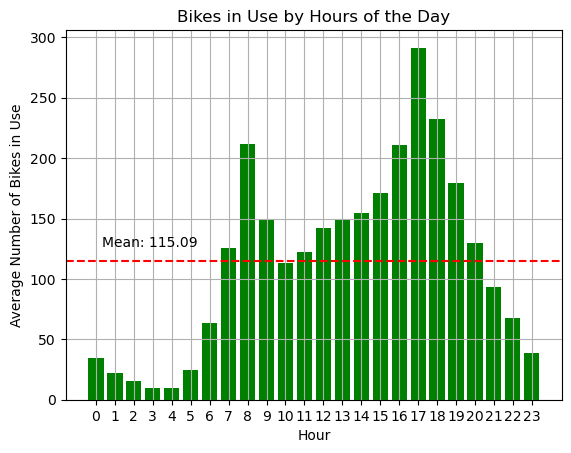

In [36]:
plt.bar(df_sum["hour"], df_sum["avg_n_of_bikes_in_use"], color="green")
plt.axhline(mean , color = 'r', linestyle = '--')
plt.xlabel("Hour")
plt.ylabel("Average Number of Bikes in Use")
plt.title("Bikes in Use by Hours of the Day")
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.2), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.grid(True)
plt.show()

##### Analysis and Interpretation of the Results:

The plots above all show that we have two peaks of bike rentals in the day. One peak demand at 8 am and the other peak at 5 pm. This peak can be a result of the rush-hour traffic. At these times most people are on their way to work/school or on their way back home. The demand around these times ( 8 am and 5 pm ) are also above average. Besides that, it also becomes clear that the bikes are mostly used during the day. During the night the demand is significantly below average (from 9 pm until 6 am).

#### Analysis of Rental during the week

First count the started rentals for each weekday of the day for the whole dataset and vizualize it in a histogram.

In [37]:
#Calculate accumulated rentals per weekday
df.groupby(["weekday"])["weekday"].count().reset_index(name="n_rentals_within_weekday")

weekday  n_rentals_within_weekday
0        0                    111449
1        1                    118958
2        2                    128466
3        3                    123746
4        4                    117736
5        5                     91803
6        6                     90067

The mapping: {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday",5: "Saturday",6: "Sunday"}

In [38]:
#Calculate mean
mean = df.groupby(["weekday"])["weekday"].count().mean()
mean

111746.42857142857

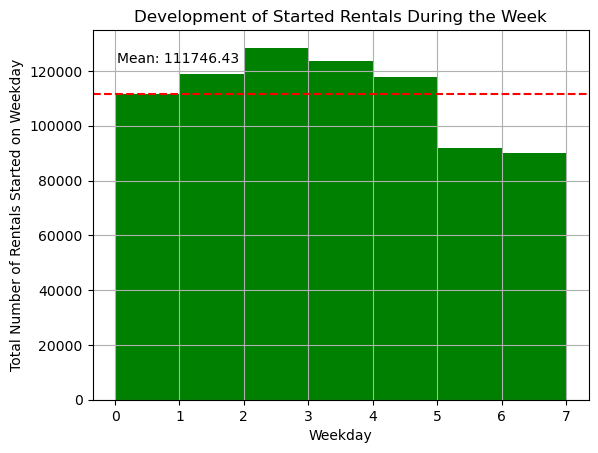

In [39]:
plt.hist(df["weekday"], bins=range(0,8,1), color="green")
plt.axhline(mean , color = 'r', linestyle = '--')
plt.xlabel("Weekday")
plt.ylabel("Total Number of Rentals Started on Weekday")
plt.title("Development of Started Rentals During the Week")
plt.xticks(range(0,8,1))
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.1), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.grid(True)
plt.show()

To get average values we calculate the number of weeks for which we have data in our dataset and calculate the avarage number of rentals started within each weekday.

IMPORTANT ASSUMPTION: The average values only provide meaningful results if we assume that we have all rental transactions that actually occurred included in our data set or at least equally distributed missing data points for each weekday. Otherwise the average values would provide misleading information. If we for example would have missing rental data for a specific weekday for several weeks, dividing by the total number of weeks would result to false average value for this weekday!

In [40]:
#Check number of weeks we have in our set
number_weeks = len(df["week"].unique())
number_weeks

52

In [41]:
#Calculate average values per weekday
df_average_per_weekday = df.groupby(["weekday"])["weekday"].count().divide(number_weeks).reset_index(name="avg_number_started_rentals")
df_average_per_weekday

weekday  avg_number_started_rentals
0        0                 2143.250000
1        1                 2287.653846
2        2                 2470.500000
3        3                 2379.730769
4        4                 2264.153846
5        5                 1765.442308
6        6                 1732.057692

In [42]:
#Calculate mean
mean = df_average_per_weekday["avg_number_started_rentals"].mean()
mean

2148.96978021978

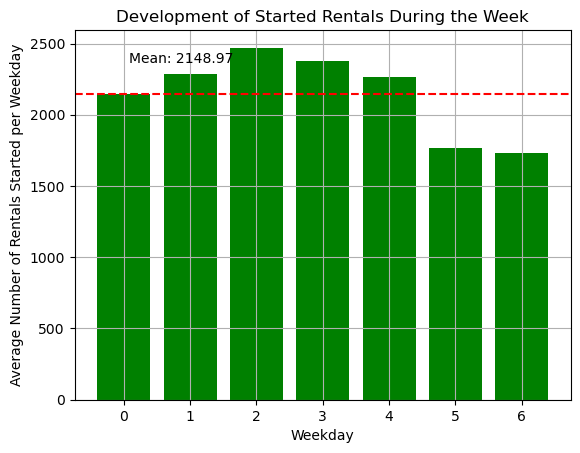

In [43]:
plt.bar(
        df_average_per_weekday["weekday"], 
        df_average_per_weekday["avg_number_started_rentals"], 
        color="green"
)
plt.axhline(mean, color="r", linestyle="--")
plt.xlabel("Weekday")
plt.ylabel("Average Number of Rentals Started per Weekday")
plt.title("Development of Started Rentals During the Week")
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.1), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.grid(True)
plt.show()

##### Analysis and Interpretation of Results:

The Bike rental demand is the lowest at the weekends (Saturdays and Sundays). The demand these days is significantly below average. The demand on Mondays is slightly below the average. We have a peak demand on Wednesdays. This development can possibly be rooted in the fact that most people don't work/ go to school or university on the weekends. This could mean that a big share of people who use the bike rental service are people who are on their way to work, school, or university.

#### Analysis of Rental during the Year

First count the started rentals for each month of the year for the whole dataset and vizualize it in a histogram.
Average values can not be calculated since we only have data of one year.

In [44]:
#Calculate number of rentals per month
df.groupby(["month"])["month"].count().reset_index(name="n_of_retals_in_month")

month  n_of_retals_in_month
0       1                 30822
1       2                 39189
2       3                 36620
3       4                 65609
4       5                 69094
5       6                 83967
6       7                 90502
7       8                 93941
8       9                 90269
9      10                 87315
10     11                 59371
11     12                 35526

In [45]:
#Calculate mean
mean = df.groupby(["month"])["month"].count().mean()
mean

65185.416666666664

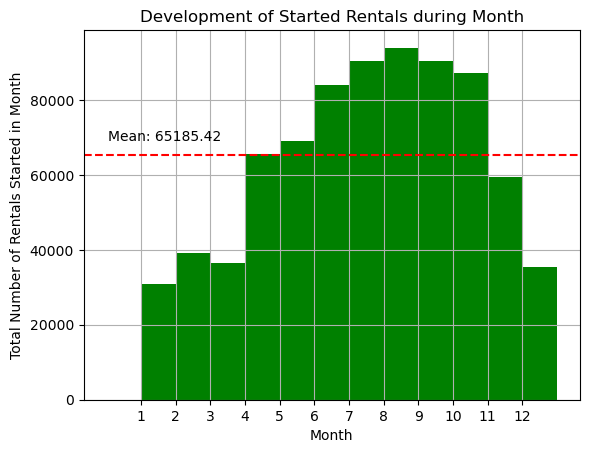

In [46]:
plt.hist(df["month"], bins=range(0,14,1), color="green")
plt.axhline(mean, color="r", linestyle="--")
plt.xlabel("Month")
plt.ylabel("Total Number of Rentals Started in Month")
plt.title("Development of Started Rentals during Month")
plt.xticks(range(1,13,1))
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.1), mean*(1.06), "Mean: {:.2f}".format(mean))
plt.grid(True)
plt.show()

In [47]:
df_weather = df_weather_2017
df_weather["date"] = df_weather["date_time"].dt.date
df_weather["hour"] = df_weather["date_time"].dt.hour

#Join weather data with rental data and calculate average temperatures
df_merge = pd.merge(df, df_weather, how="left", left_on=["date", "hour"], right_on=["date", "hour"])
df_merge["avg_temp"] = df_merge[["max_temp", "min_temp"]].mean(axis="columns")

In [48]:
#Calculate average temperatures for each month
df_temp_month = df_merge.groupby("month")["avg_temp"].mean().reset_index(name="avg_temp")
df_temp_month

month   avg_temp
0       1   5.119939
1       2   7.948301
2       3   7.608369
3       4  16.540951
4       5  18.157399
5       6  24.117792
6       7  26.453108
7       8  24.531805
8       9  22.156413
9      10  17.822924
10     11   9.976382
11     12   4.517251

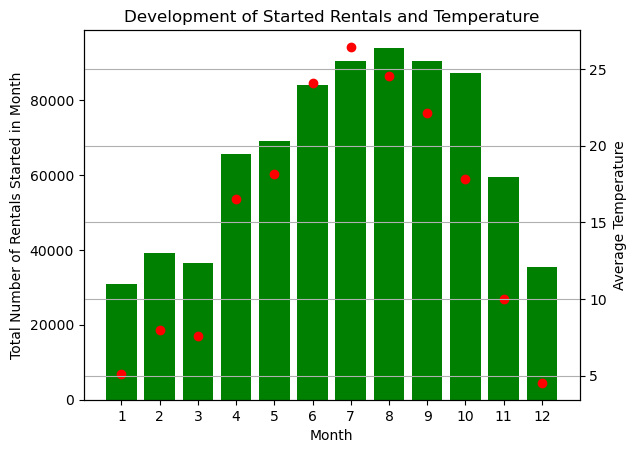

In [49]:
#Plot number of rentals together with average temperature
#Red dots would be the average temperature for each month
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
df_months = df.groupby(["month"])["month"].count().reset_index(name="n_of_retals_in_month")
ax1.bar(df_months["month"], df_months["n_of_retals_in_month"], color="green")
ax1.set_ylabel("Total Number of Rentals Started in Month")
plt.title("Development of Started Rentals and Temperature")
plt.xticks(range(1,13,1))
ax2.scatter(df_temp_month["month"], df_temp_month["avg_temp"], color="red")
ax2.set_ylabel("Average Temperature")
ax1.set_xlabel("Month")
plt.grid(True)
plt.show()

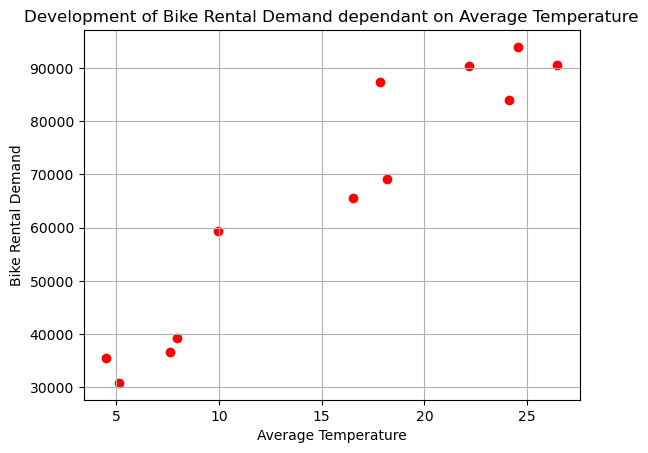

In [50]:
plt.scatter(df_temp_month["avg_temp"], df_months["n_of_retals_in_month"], color="red")
plt.xlabel("Average Temperature")
plt.ylabel("Bike Rental Demand")
plt.title("Development of Bike Rental Demand dependant on Average Temperature")
plt.grid(True)
plt.show()

##### Analysis and Interpretation of the Results:

The development of bike rental demand has similar development as the development of the average temperature during the year. 
The only difference can be seen at the peak. The average temperature has its peak in July whereas the bike rental demand has its peak in August. However, the difference in the bike rental demand in July and August is not that high. Another effect that could have an influence on the bike rental demand is the number of tourists. According to the annual report of Philadelphia, the number of tourists was the highest for the second and third quarters of the year (April to September). In these months the bike rental demand was always very close (April) or above the overall average of the bike rental demand. 
Especially for the month of December, January, February, and March the bike rental demand is clearly below the average.

Development of the tourist numbers according to the annual report: 
- Q1: 7 million
- Q2: 13.1 million
- Q3: 13.1 million
- Q4: 10.1 million

### Geographical Demand Patterns ##

In this section, we look at which stations in Philadelphia are particularly popular and which are not due to the given dataset.

First step: reading data from the bikeshare dataset from Ride Indego Philadelphia.

In [51]:
df = df_philadelphia_cleaned.copy()

In [52]:
data = df[["start_station_id", "start_station_name", "end_station_id", "end_station_name"]]
data

start_station_id           start_station_name  end_station_id  \
0                   3046                 2nd & Market            3041   
1                   3110  Del. River Trail & Penn St.            3054   
2                   3110  Del. River Trail & Penn St.            3054   
3                   3041          Girard Station, MFL            3005   
4                   3047       Independence Mall, NPS            3124   
...                  ...                          ...             ...   
782335              3070   Spring Garden Station, MFL            3124   
782336              3107             33rd & Reservoir            3165   
782337              3033              10th & Chestnut            3046   
782338              3163                25th & Locust            3163   
782339              3163                25th & Locust            3057   

                  end_station_name  
0              Girard Station, MFL  
1                     Rodin Museum  
2                     Rodin Museum  
3                Welcome Park, NPS  
4                 Race Street Pier  
...                            ...  
782335            Race Street Pier  
782336             24th & Race SRT  
782337                2nd & Market  
782338               25th & Locust  
782339  Philadelphia Museum of Art  

[782225 rows x 4 columns]

In [53]:
data = df[["start_station_name", "end_station_name"]]
data

start_station_name            end_station_name
0                      2nd & Market         Girard Station, MFL
1       Del. River Trail & Penn St.                Rodin Museum
2       Del. River Trail & Penn St.                Rodin Museum
3               Girard Station, MFL           Welcome Park, NPS
4            Independence Mall, NPS            Race Street Pier
...                             ...                         ...
782335   Spring Garden Station, MFL            Race Street Pier
782336             33rd & Reservoir             24th & Race SRT
782337              10th & Chestnut                2nd & Market
782338                25th & Locust               25th & Locust
782339                25th & Locust  Philadelphia Museum of Art

[782225 rows x 2 columns]

In the following we look at the stations where the ride was started and sort them in descending order of the number of rentals.

In [54]:
df.groupby(["start_station_name"])["start_station_name"].count().reset_index(name = "rentals_per_station").sort_values(by=['rentals_per_station'], ascending=False)

start_station_name  rentals_per_station
114                                 Rittenhouse Square                24644
15                                       15th & Spruce                23495
20                                          18th & JFK                19700
10                                       13th & Locust                19086
115                                       Rodin Museum                16272
..                                                 ...                  ...
60   39th & Mt. Vernon, Mantua Haverford Community ...                  744
3       11th & Poplar, John F. Street Community Center                  743
9                                      12th & Passyunk                  581
27                                       20th & Sansom                  126
84                                   Barnes Foundation                   48

[124 rows x 2 columns]

Displaying only the five most popular start stations:

In [55]:
df_most_popular = df.groupby(["start_station_name"])["start_station_name"].count().reset_index(name = "rentals_per_station").sort_values(by=['rentals_per_station'], ascending=False).head()
df_most_popular

start_station_name  rentals_per_station
114  Rittenhouse Square                24644
15        15th & Spruce                23495
20           18th & JFK                19700
10        13th & Locust                19086
115        Rodin Museum                16272

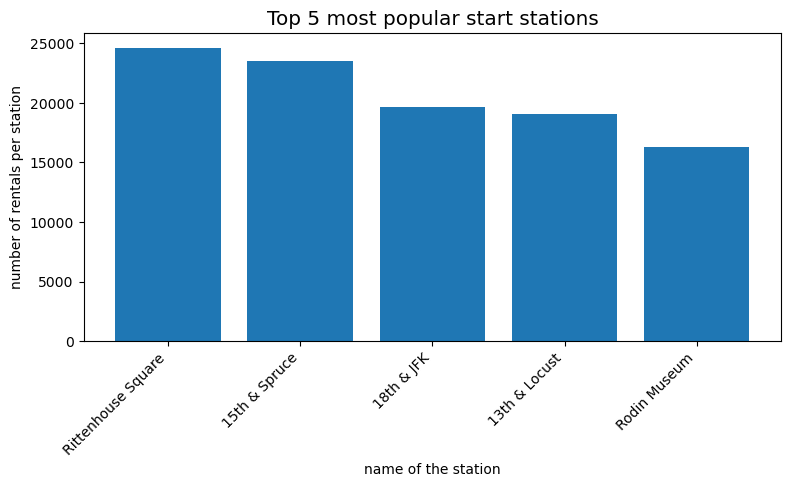

In [56]:
fig = plt.figure(figsize=(9,4))
plt.bar(df_most_popular["start_station_name"], df_most_popular["rentals_per_station"])
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xticks(rotation=45, ha='right')
plt.xlabel("name of the station", size = 'medium')
plt.ylabel("number of rentals per station", size = 'medium')
plt.title("Top 5 most popular start stations", size = 'x-large')
plt.show()

Displaying only the five least popular start stations:

In [57]:
df_least_popular = df.groupby(["start_station_name"])["start_station_name"].count().reset_index(name = "rentals_per_station").sort_values(by=['rentals_per_station'], ascending=False).tail()
df_least_popular

start_station_name  rentals_per_station
60  39th & Mt. Vernon, Mantua Haverford Community ...                  744
3      11th & Poplar, John F. Street Community Center                  743
9                                     12th & Passyunk                  581
27                                      20th & Sansom                  126
84                                  Barnes Foundation                   48

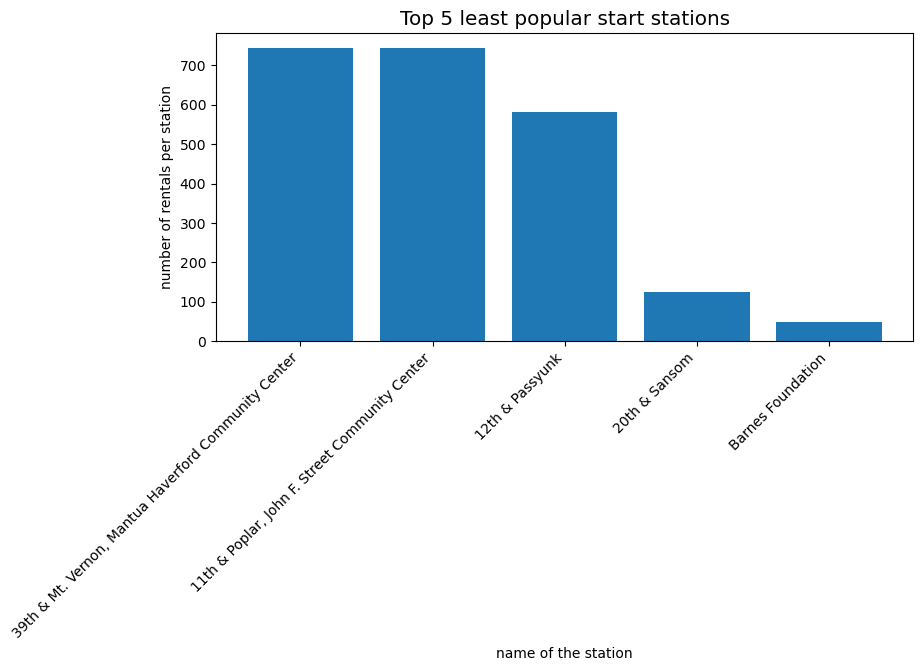

In [58]:
fig = plt.figure(figsize=(9,4))
plt.bar(df_least_popular["start_station_name"], df_least_popular["rentals_per_station"])
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xticks(rotation=45, ha='right')
plt.xlabel("name of the station", size = 'medium')
plt.ylabel("number of rentals per station", size = 'medium')
plt.title("Top 5 least popular start stations", size = 'x-large')
plt.show()

In the following we look at the stations where the ride was terminated and sort them in descending order of the number of rentals.

In [59]:
df.groupby(["end_station_name"])["end_station_name"].count().reset_index(name = "rentals_per_station").sort_values(by=['rentals_per_station'], ascending=False)

end_station_name  rentals_per_station
114                                 Rittenhouse Square                25444
20                                          18th & JFK                24733
15                                       15th & Spruce                23599
10                                       13th & Locust                19189
115                                       Rodin Museum                16982
..                                                 ...                  ...
52                                      33rd & Diamond                  638
62                    40th & Baltimore, Trolley Portal                  627
60   39th & Mt. Vernon, Mantua Haverford Community ...                  548
27                                       20th & Sansom                  140
84                                   Barnes Foundation                   76

[124 rows x 2 columns]

Displaying only the five most popular end stations:

In [60]:
df_most_popular_end = df.groupby(["end_station_name"])["end_station_name"].count().reset_index(name = "rentals_per_station").sort_values(by=['rentals_per_station'], ascending=False).head()
df_most_popular_end

end_station_name  rentals_per_station
114  Rittenhouse Square                25444
20           18th & JFK                24733
15        15th & Spruce                23599
10        13th & Locust                19189
115        Rodin Museum                16982

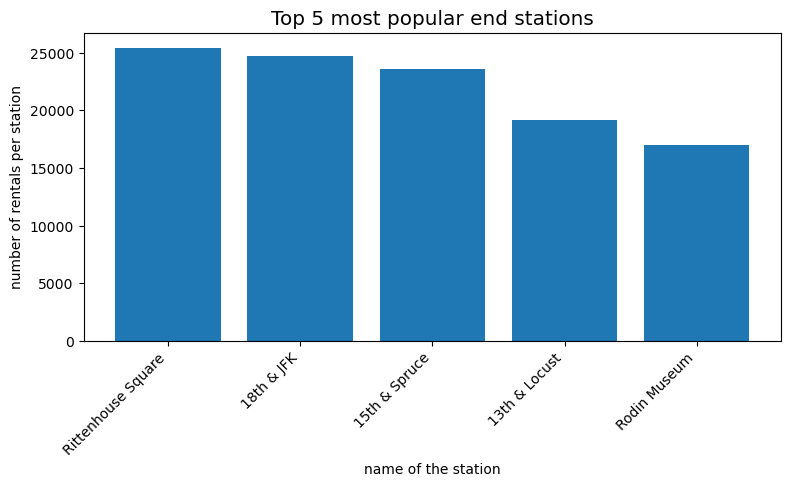

In [61]:
fig = plt.figure(figsize=(9,4))
plt.bar(df_most_popular_end["end_station_name"], df_most_popular_end["rentals_per_station"])
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xticks(rotation=45, ha='right')
plt.xlabel("name of the station", size = 'medium')
plt.ylabel("number of rentals per station", size = 'medium')
plt.title("Top 5 most popular end stations", size = 'x-large')
plt.show()

Displaying only the five least popular end stations:

In [62]:
df_least_popular_end = df.groupby(["end_station_name"])["end_station_name"].count().reset_index(name = "rentals_per_station").sort_values(by=['rentals_per_station'], ascending=False).tail()
df_least_popular_end

end_station_name  rentals_per_station
52                                     33rd & Diamond                  638
62                   40th & Baltimore, Trolley Portal                  627
60  39th & Mt. Vernon, Mantua Haverford Community ...                  548
27                                      20th & Sansom                  140
84                                  Barnes Foundation                   76

In [63]:
df_least_popular_end = df_least_popular_end.replace(['39th & Mt. Vernon, Mantua Haverford Community Center', '40th & Baltimore, Trolley Portal'], ['39th & Mt. Vernon', '40th & Baltimore'])
print(df_least_popular_end)

     end_station_name  rentals_per_station
52     33rd & Diamond                  638
62   40th & Baltimore                  627
60  39th & Mt. Vernon                  548
27      20th & Sansom                  140
84  Barnes Foundation                   76


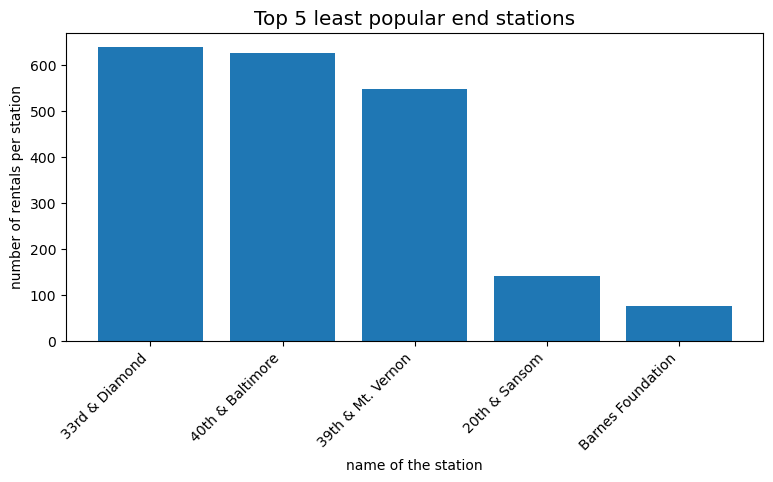

In [64]:
fig = plt.figure(figsize=(9,4))
plt.bar(df_least_popular_end["end_station_name"], df_least_popular_end["rentals_per_station"])
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xticks(rotation=45, ha='right')
plt.xlabel("name of the station", size = 'medium')
plt.ylabel("number of rentals per station", size = 'medium')
plt.title("Top 5 least popular end stations", size = 'x-large')
plt.show()

#### Analysis of the results:

After looking at the top 5 most popular and top 5 least popular start and end stations, it is especially noticeable that the five most popular start stations are also the five most popular end stations in Philadelphia. Apparently, there is a high demand for renting bikes between these stations. According to Google Maps these stations are located in the center of the city and are no more than 1.6 miles apart from each other. This shows, that the bicycles are mainly used for short distances in the city center.

### Key Performance Indicators (KPIs)

#### Coverage

In the next part we use the geographical coordinates of the original dataset from the indego website.

First of all we create a dataframe where we group the rows by the start station and the corresponding coordinates. Furthermore we aggregate the rows into a new column "counts".

In [65]:
phil_groupedby_start = df_philadelphia_cleaned.groupby([ 'start_station_name', 'start_lat', 'start_lon']).size().reset_index(name='counts')

phil_groupedby_start

start_station_name  start_lat  start_lon  \
0                                      10th & Chestnut  39.950050 -75.156723   
1                                       10th & Federal  39.934311 -75.160423   
2                               11th & Pine, Kahn Park  39.945171 -75.159927   
3       11th & Poplar, John F. Street Community Center  39.968922 -75.154701   
4                                          11th & Reed  39.933151 -75.162483   
..                                                 ...        ...        ...   
125  The Children's Hospital of Philadelphia, Osler...  39.946812 -75.193108   
126                   Thompson & Palmer, Adaire School  39.972160 -75.129936   
127                            University City Station  39.948872 -75.189857   
128                            University City Station  39.949219 -75.190361   
129                                  Welcome Park, NPS  39.947330 -75.144028   

     counts  
0      8441  
1      4664  
2     12025  
3       743  
4      7777  
..      ...  
125    4032  
126    1472  
127    6919  
128    9020  
129    4653  

[130 rows x 4 columns]

We plot the number of trips per start station. For visualizing which stations stations have the most demand. For this we use circle markers to visualize each station. Bigger circle markers indicate more rented bikes for the corresponding station and clicking on a specific marker reveals additional information like the specific trip count and the station name.

In [66]:
figure_start_station = Figure(width=950,height=900) 
map_start_station = folium.Map(dragging=True,zoom_control=True, control_scale=True, max_zoom=18, min_zoom=13,scrollWheelZoom=False,doubleClickZoom=False, width=900,height=800)
for index, row in phil_groupedby_start.iterrows():
    iframe = folium.IFrame(f"Station name: {row['start_station_name']} <br> Trips per station :  {row['counts']}", width=250, height=70)
    popup = folium.Popup(iframe)
    folium.Circle([row['start_lat'], row['start_lon']], radius=math.sqrt(row['counts']), color='red', fill_color='orange', fill_opacity=0.3, popup=popup).add_to(map_start_station)
south_west_b = phil_groupedby_start[['start_lat', 'start_lon']].min().values.tolist()
north_east_b = phil_groupedby_start[['start_lat', 'start_lon']].max().values.tolist()
map_start_station.fit_bounds([south_west_b, north_east_b])
figure_start_station.add_child(map_start_station)
title = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Number of trips per start station")   
map_start_station.get_root().html.add_child(folium.Element(title))
figure_start_station

As we can see most bikes are rented in stations near the center of philadelphia like "18th & JFK", "Rittenhouse Square" and "15th & Market" but also near main roads like the stations "15th & Spruce", "Rodin Museum" and "23rd & South". More possibilities why some stations could be more used are hotspots like Museums for example the "Rodin Museum" or the "Philadelphia Museum of Art".

Now we do the same procedure for the end stations, first grouping them like in the previous steps.

In [67]:
phil_groupedby_end = df_philadelphia_cleaned.groupby([ 'end_station_name', 'end_lat', 'end_lon']).size().reset_index(name='counts')

phil_groupedby_end

end_station_name    end_lat    end_lon  \
0                                      10th & Chestnut  39.950050 -75.156723   
1                                       10th & Federal  39.934311 -75.160423   
2                               11th & Pine, Kahn Park  39.945171 -75.159927   
3       11th & Poplar, John F. Street Community Center  39.968922 -75.154701   
4                                          11th & Reed  39.933151 -75.162483   
..                                                 ...        ...        ...   
125  The Children's Hospital of Philadelphia, Osler...  39.946812 -75.193108   
126                   Thompson & Palmer, Adaire School  39.972160 -75.129936   
127                            University City Station  39.948872 -75.189857   
128                            University City Station  39.949219 -75.190361   
129                                  Welcome Park, NPS  39.947330 -75.144028   

     counts  
0      8724  
1      4938  
2     12458  
3       772  
4      8265  
..      ...  
125    3815  
126    1475  
127    6106  
128    8558  
129    5223  

[130 rows x 4 columns]

In [68]:
figure_end_station = Figure(width=950,height=900) 
map_end_station = folium.Map(dragging=True,zoom_control=True, control_scale=True, max_zoom=18, min_zoom=13,scrollWheelZoom=False,doubleClickZoom=False, width=900,height=800)
for index, row in phil_groupedby_end.iterrows():
    iframe = folium.IFrame(f"Station name: {row['end_station_name']} <br> Trips per station :  {row['counts']}", width=250, height=70)
    popup = folium.Popup(iframe)
    folium.Circle([row['end_lat'], row['end_lon']], radius=math.sqrt(row['counts']), color='red', fill_color='orange', fill_opacity=0.3, popup=popup).add_to(map_end_station)
south_west_b = phil_groupedby_end[['end_lat', 'end_lon']].min().values.tolist()
north_east_b = phil_groupedby_end[['end_lat', 'end_lon']].max().values.tolist()
map_end_station.fit_bounds([south_west_b, north_east_b])
figure_end_station.add_child(map_end_station)
title = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Trips per end station")   
map_end_station.get_root().html.add_child(folium.Element(title))
figure_end_station

As we can see the overall pattern stays the same. In the center of the city are the more popular stations and going further away from the center are the least popular stations. The least popular stations could be combined with other stations near it to save maintainance costs spacing the stations out the farther they are away from the center of philadelphia.

It is also interesting to see how much the stations cover the area of philadelphia. Therefore we loaded Geojson data of the philadelphia neighborhoods and their borders to visualize which parts of philadelphia are covered by the stations.

In [69]:
figure_end_station = Figure(width=950,height=900) 
map_with_geoJson = folium.Map(location=[39.96,-75.18],dragging=True,zoom_start=12,zoom_control=True, control_scale=True, max_zoom=18, min_zoom=12,scrollWheelZoom=False,doubleClickZoom=False, width=900,height=800)
folium.GeoJson(data="data/Neighborhoods_Philadelphia.geojson").add_to(map_with_geoJson)

for index, row in phil_groupedby_end.iterrows():
    iframe = folium.IFrame(f"Station name: {row['end_station_name']} <br> Trips per station :  {row['counts']}", width=250, height=70)
    popup = folium.Popup(iframe)
    folium.Circle([row['end_lat'], row['end_lon']], radius=math.sqrt(row['counts']), color='red', fill_color='orange', fill_opacity=0.3, popup=popup).add_to(map_with_geoJson)

south_west_b = phil_groupedby_end[['end_lat', 'end_lon']].min().values.tolist()
north_east_b = phil_groupedby_end[['end_lat', 'end_lon']].max().values.tolist()
figure_end_station.add_child(map_with_geoJson)
title = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Trips per end station with philadelphia neighborhood")   
map_with_geoJson.get_root().html.add_child(folium.Element(title))
figure_end_station

As we can see, mostly the center is covered by the stations and the part of south philadelphia nearest to the center. This makes sense because the center has the most demand but if the demand rises with each year it could be worth adding stations near other hotspots and farther from the center.

Furthermore we can plot the demand per hour for the start station and end stations.

In [70]:
grouped_by_start_station_hour = df_philadelphia_cleaned.groupby(['start_station_name', 'start_lat', 'start_lon', 'hour']).size().reset_index(name='counts')
fig = px.scatter_mapbox(grouped_by_start_station_hour, lat="start_lat", lon="start_lon", animation_frame="hour", 
                        size= "counts",size_max= 28,opacity=0.8, animation_group='start_station_name',
                        zoom=12.3, height=1000, width=900, hover_name="start_station_name",
                        hover_data=["start_lat", "start_lon"], title='Trips per start station for each hour')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
fig

As we can see between 8:00 AM and 9:00 AM the majority of trips start outside of the center. One reason could be that the majority rents a bike to go to work or that most people live outside of the center. It is also interesting to mention that at 17:00 PM the majority of the trips start in the center or near the center. This also supports the assumption that many people use the bikes for going to work and back home from work because 17:00 PM is around the time where work ends for most people. Further research in comparing work hours and the geographical patterns could lead to more insights.

In [71]:
grouped_by_end_station_hour = df_philadelphia_cleaned.groupby(['end_station_name', 'end_lat', 'end_lon', 'hour']).size().reset_index(name='counts')
fig = px.scatter_mapbox(grouped_by_end_station_hour, lat="end_lat", lon="end_lon", animation_frame="hour", 
                        size= "counts",size_max= 27,opacity=0.8, animation_group='end_station_name',
                        zoom=12.3, height=1000, width=900, hover_name="end_station_name",
                        hover_data=["end_lat", "end_lon"], title='Trips per end station for each hour')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
fig

Look at the hourly trips per end station we can see this time that between 8:00 AM and 9:00 AM most trips end near the center instead of outside like for the start stations. Like wise for 17:00 PM less trips end in the center and more trips end outside of it.

In the following we also plotted the trips per start station and end station for each month. This could be useful for observing if new stations are used sufficiently.

In [72]:
grouped_by_start_station_month = df_philadelphia_cleaned.groupby(['start_station_name', 'start_lat', 'start_lon', 'month']).size().reset_index(name='counts')
fig = px.scatter_mapbox(grouped_by_start_station_month, lat="start_lat", lon="start_lon", animation_frame="month", 
                        size= "counts",size_max= 25,opacity=0.8, animation_group='start_station_name',
                        zoom=12.3, height=1000, width=900, hover_name="start_station_name",
                        hover_data=["start_lat", "start_lon"], title='Trips per start station for each month')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
fig

In [73]:
grouped_by_end_station_month = df_philadelphia_cleaned.groupby(['end_station_name', 'end_lat', 'end_lon', 'month']).size().reset_index(name='counts')
fig = px.scatter_mapbox(grouped_by_end_station_month, lat="end_lat", lon="end_lon", animation_frame="month", 
                        size= "counts",size_max= 25,opacity=0.8, animation_group='end_station_name',
                        zoom=12.3, height=1000, width=900, hover_name="end_station_name",
                        hover_data=["end_lat", "end_lon"], title='Trips per end station for each month')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
fig

We could problably get further insights on the utilizations and the coverage for each station like which stations are overloaded with bikes or which stations have no bikes available if the station data existed in hourly steps for 2017. With the live data on the [indego website](https://www.rideindego.com/about/data/) which contains all of these informations this could be possible if it existed for previous years.

#### Rental Durations

Rental durations are closely tied to revenue because the revenue model of the bike sharing company is based on the rental time/ duration thus its relevant to observe the rental duration to get information on the company's performance.

In [74]:
#Calculate the sum of rental durations for each month
#Calculate the average rental duration per rental for each month
df = df_philadelphia_cleaned
df_duration_monthly = df.groupby("month")["trip_duration"].sum().reset_index(name="sum_duration_bike_rentals")
df_duration_monthly["duration_in_hours"] = df_duration_monthly["sum_duration_bike_rentals"].dt.total_seconds().divide(60*60)
df_duration_monthly["duration_in_minutes"] = df_duration_monthly["sum_duration_bike_rentals"].dt.total_seconds().divide(60)
df_duration_monthly["number_of_rentals"] = df.groupby("month")["month"].count().reset_index(drop=True)
df_duration_monthly["avg_duration_per_rental_in_min"] = df_duration_monthly["duration_in_minutes"] / df_duration_monthly["number_of_rentals"]
df_duration_monthly

month sum_duration_bike_rentals  duration_in_hours  duration_in_minutes  \
0       1         339 days 21:22:00        8157.366667             489442.0   
1       2         484 days 06:14:00       11622.233333             697334.0   
2       3         422 days 11:38:00       10139.633333             608378.0   
3       4         922 days 15:44:00       22143.733333            1328624.0   
4       5         935 days 03:52:00       22443.866667            1346632.0   
5       6        1177 days 03:40:00       28251.666667            1695100.0   
6       7        1287 days 06:23:00       30894.383333            1853663.0   
7       8        1260 days 19:22:00       30259.366667            1815562.0   
8       9        1188 days 20:32:00       28532.533333            1711952.0   
9      10        1103 days 19:05:00       26491.083333            1589465.0   
10     11         674 days 02:41:00       16178.683333             970721.0   
11     12         390 days 23:44:00        9383.733333             563024.0   

    number_of_rentals  avg_duration_per_rental_in_min  
0               30822                       15.879631  
1               39189                       17.794126  
2               36620                       16.613271  
3               65609                       20.250636  
4               69094                       19.489854  
5               83967                       20.187693  
6               90502                       20.482011  
7               93941                       19.326620  
8               90269                       18.965005  
9               87315                       18.203802  
10              59371                       16.350087  
11              35526                       15.848224

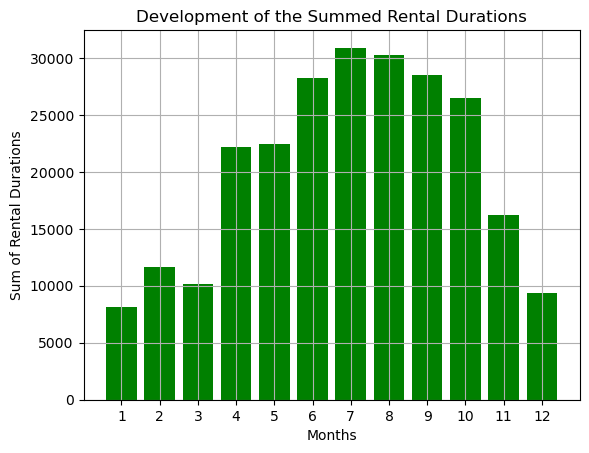

In [75]:
#Vizualize development of summed durations
plt.bar(df_duration_monthly["month"],
       df_duration_monthly["duration_in_hours"],
       color="green")
plt.grid(True)
plt.xticks(range(1,13,1))
plt.xlabel("Months")
plt.ylabel("Sum of Rental Durations")
plt.title("Development of the Summed Rental Durations")
plt.show()

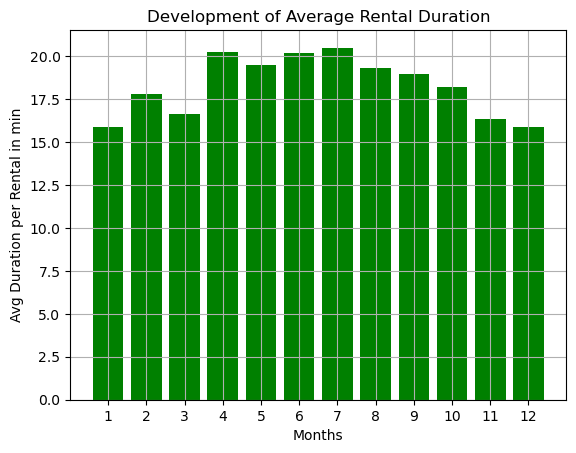

In [76]:
#Vizualize development of average durations for each month
plt.bar(df_duration_monthly["month"],
       df_duration_monthly["avg_duration_per_rental_in_min"],
       color="green")
plt.grid(True)
plt.xticks(range(1,13,1))
plt.xlabel("Months")
plt.ylabel("Avg Duration per Rental in min")
plt.title("Development of Average Rental Duration")
plt.show()

In [77]:
#Calculate the sum of rental durations for each week
#Calculate the average rental duration per rental for each week
df_duration_weekly = df.groupby("week")["trip_duration"].sum().reset_index(name="sum_duration_bike_rentals")
df_duration_weekly["duration_in_hours"] = df_duration_weekly["sum_duration_bike_rentals"].dt.total_seconds().divide(60*60)
df_duration_weekly["duration_in_minutes"] = df_duration_weekly["sum_duration_bike_rentals"].dt.total_seconds().divide(60)
df_duration_weekly["number_of_rentals"] = df.groupby("week")["week"].count().reset_index(drop=True)
df_duration_weekly["avg_duration_per_rental_in_min"] = df_duration_weekly["duration_in_minutes"] / df_duration_weekly["number_of_rentals"]
df_duration_weekly.head()

week sum_duration_bike_rentals  duration_in_hours  duration_in_minutes  \
0     1          48 days 02:50:00        1154.833333              69290.0   
1     2          77 days 11:52:00        1859.866667             111592.0   
2     3          82 days 09:46:00        1977.766667             118666.0   
3     4          89 days 12:36:00        2148.600000             128916.0   
4     5          77 days 04:06:00        1852.100000             111126.0   

   number_of_rentals  avg_duration_per_rental_in_min  
0               4585                       15.112323  
1               7084                       15.752682  
2               8147                       14.565607  
3               7641                       16.871614  
4               8118                       13.688840

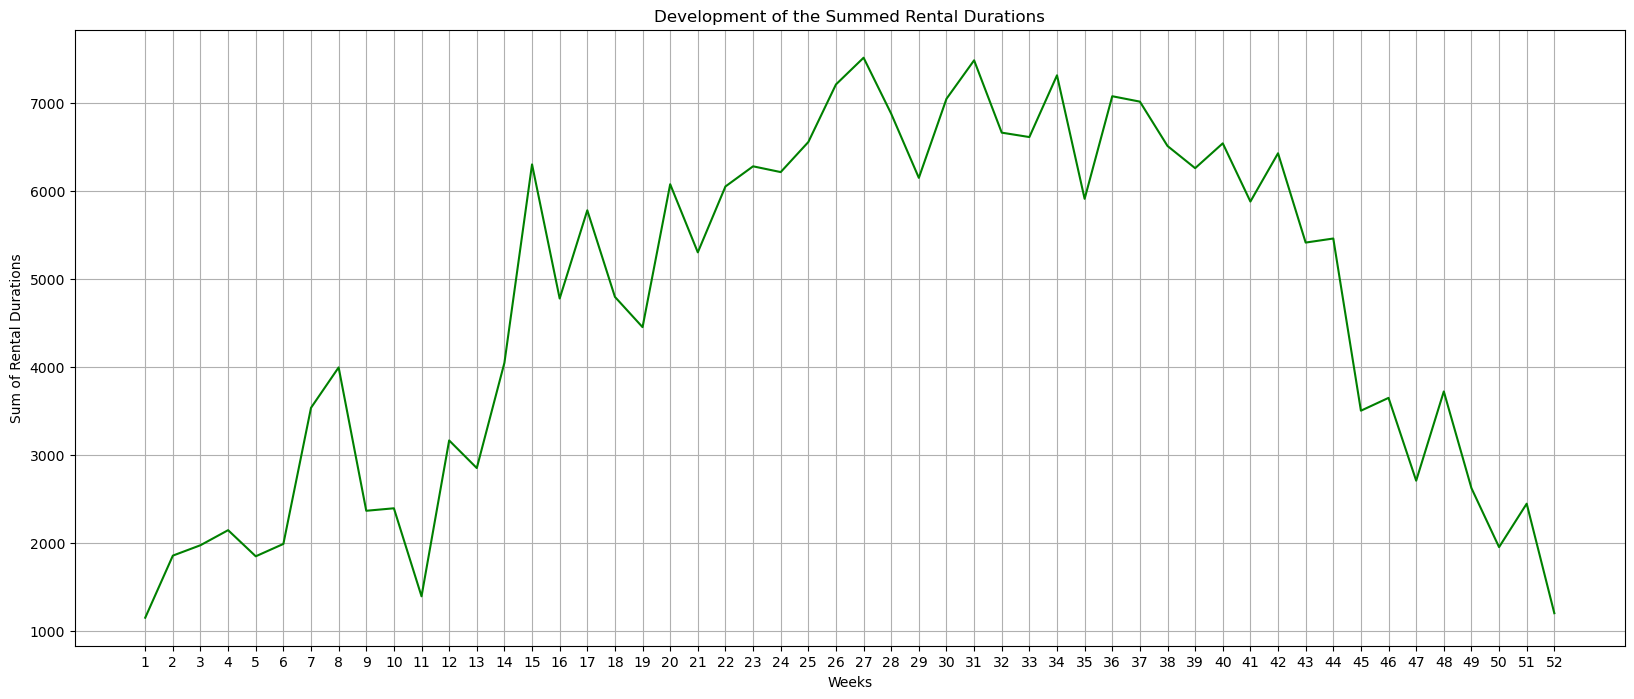

In [78]:
#Vizualize development of summed durations
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(df_duration_weekly["week"],
       df_duration_weekly["duration_in_hours"],
       color="green")
plt.grid(True)
plt.xticks(range(1,53,1))
plt.xlabel("Weeks")
plt.ylabel("Sum of Rental Durations")
plt.title("Development of the Summed Rental Durations")
plt.show()

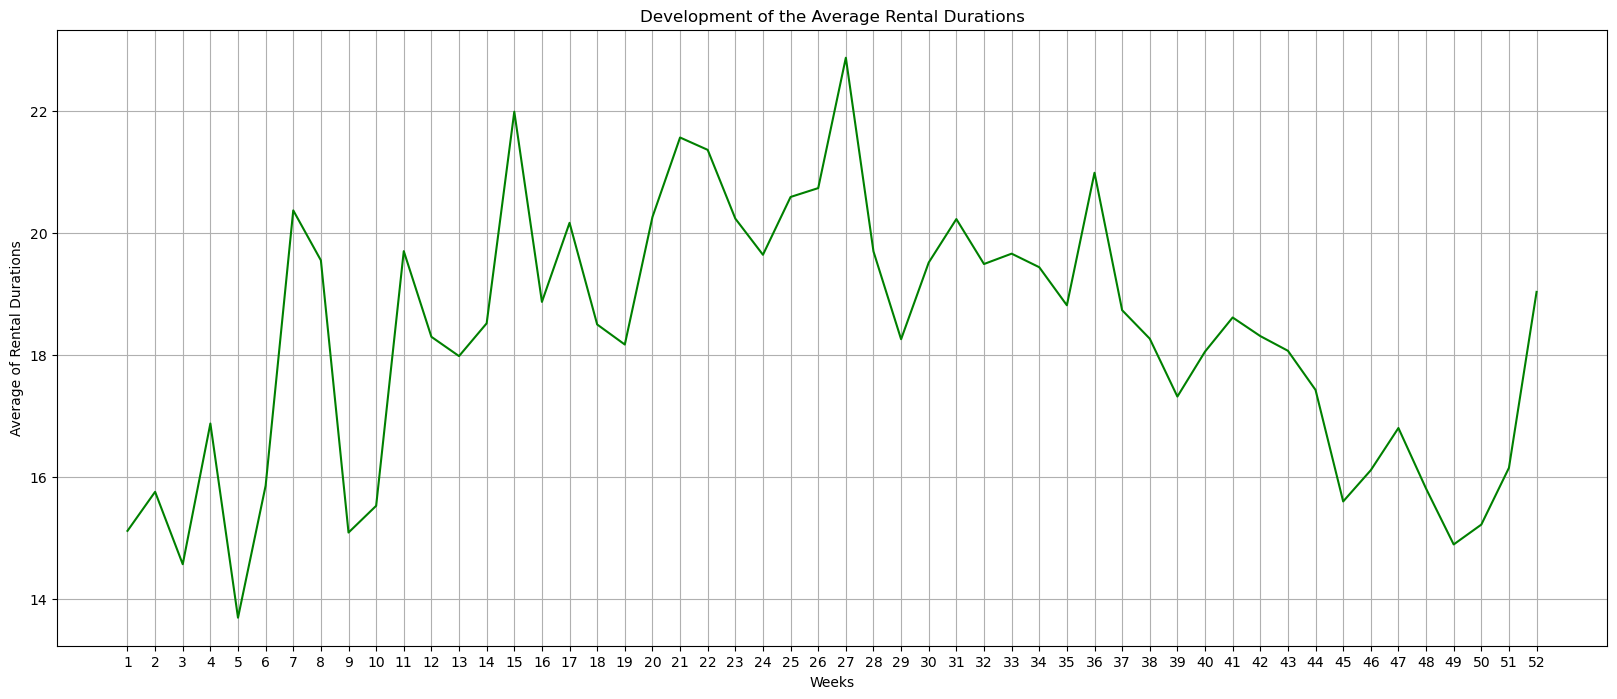

In [79]:
#Vizualize development of average durations for each week
plt.plot(df_duration_weekly["week"],
       df_duration_weekly["avg_duration_per_rental_in_min"],
       color="green")
plt.grid(True)
plt.xticks(range(1,53,1))
plt.xlabel("Weeks")
plt.ylabel("Average of Rental Durations")
plt.title("Development of the Average Rental Durations")
plt.show()

##### Interpretation of the Results

- The summed rental durations have a similar development as the summed number of rentals 
- Our bikes are more used in the summer months especially from June to October
- This can be seen in the monthly as well as the weekly aggregation 
- The average rental duration per ride lies between 15 and 22 minutes with the average rental duration being especially high from April to July

##### Rental Duration Dependant on Weather

In [80]:
df_weather = df_weather_2017
df_weather["date"] = df_weather["date_time"].dt.date
df_weather["hour"] = df_weather["date_time"].dt.hour

#Join weather data with rental data and calculate average temperatures
df_merge = pd.merge(df, df_weather, how="left", left_on=["date", "hour"], right_on=["date", "hour"])
df_merge["avg_temp"] = df_merge[["max_temp", "min_temp"]].mean(axis="columns")

In [81]:
df_duration_daily = df_merge.groupby("date").agg({"trip_duration": lambda x: x.sum(), 
                                                  "precip": lambda x: x.sum(), 
                                                  "avg_temp": lambda x: x.mean()})
df_duration_daily["duration_in_hours"] = df_duration_daily["trip_duration"].dt.total_seconds().divide(60*60)
df_duration_daily["duration_in_minutes"] = df_duration_daily["trip_duration"].dt.total_seconds().divide(60)
df_duration_daily["number_of_rentals"] = df.groupby("date")["date"].count()
df_duration_daily["avg_duration_per_rental_in_min"] = df_duration_daily["duration_in_minutes"] / df_duration_daily["number_of_rentals"]
df_duration_daily_precip = df_duration_daily[df_duration_daily["precip"] > 0]
df_duration_daily_no_precip = df_duration_daily[df_duration_daily["precip"] == 0]
df_duration_daily

trip_duration  precip  avg_temp  duration_in_hours  \
date                                                               
2017-01-01 18 days 19:50:00     0.0  7.354472         451.833333   
2017-01-02  3 days 06:56:00   225.0  4.415446          78.933333   
2017-01-03  7 days 09:35:00   384.0  6.755494         177.583333   
2017-01-04 14 days 12:12:00   129.0  8.844293         348.200000   
2017-01-05  9 days 22:54:00     0.0 -0.328090         238.900000   
...                     ...     ...       ...                ...   
2017-12-27  5 days 15:27:00     0.0 -4.334992         135.450000   
2017-12-28  6 days 01:41:00     0.0 -8.012633         145.683333   
2017-12-29  5 days 09:10:00     0.0 -7.938156         129.166667   
2017-12-30  2 days 23:32:00    66.0 -5.518317          71.533333   
2017-12-31  3 days 01:13:00     0.0 -8.708051          73.216667   

            duration_in_minutes  number_of_rentals  \
date                                                 
2017-01-01              27110.0                861   
2017-01-02               4736.0                314   
2017-01-03              10655.0                719   
2017-01-04              20892.0               1323   
2017-01-05              14334.0               1068   
...                         ...                ...   
2017-12-27               8127.0                623   
2017-12-28               8741.0                562   
2017-12-29               7750.0                553   
2017-12-30               4292.0                202   
2017-12-31               4393.0                236   

            avg_duration_per_rental_in_min  
date                                        
2017-01-01                       31.486643  
2017-01-02                       15.082803  
2017-01-03                       14.819193  
2017-01-04                       15.791383  
2017-01-05                       13.421348  
...                                    ...  
2017-12-27                       13.044944  
2017-12-28                       15.553381  
2017-12-29                       14.014467  
2017-12-30                       21.247525  
2017-12-31                       18.614407  

[365 rows x 7 columns]

In [82]:
#Calculate average summed rental duration per day
avg_summed_duration_precip = df_duration_daily_precip["duration_in_hours"].mean()
avg_summed_duration_no_precip = df_duration_daily_no_precip["duration_in_hours"].mean()
print(f"{avg_summed_duration_precip= }\n{avg_summed_duration_no_precip= }")

avg_summed_duration_precip= 567.2175120772947
avg_summed_duration_no_precip= 732.2566813509546


In [83]:
#Calculate average rental duration per rental
avg_duration_per_rental_precip = df_duration_daily_precip["avg_duration_per_rental_in_min"].mean()
avg_duration_per_rental_no_precip = df_duration_daily_no_precip["avg_duration_per_rental_in_min"].mean()
print(f"{avg_duration_per_rental_precip= }\n{avg_duration_per_rental_no_precip= }")

avg_duration_per_rental_precip= 18.769524020598876
avg_duration_per_rental_no_precip= 18.569246562610797


In [84]:
#Calculate average rental duration and average summed rental duration per day dependen on temperature
df_duration_daily["temp_bin"] = pd.cut(df_duration_daily.avg_temp, 10)
df_temp_bins = df_duration_daily.groupby("temp_bin").agg({"duration_in_hours": lambda x: x.mean(), 
                                          "avg_duration_per_rental_in_min": lambda x: x.mean()}).reset_index()
df_temp_bins["temp_bin"] = df_temp_bins["temp_bin"].astype(str)
df_temp_bins

temp_bin  duration_in_hours  avg_duration_per_rental_in_min
0  (-8.748, -4.741]         105.969444                       17.167409
1  (-4.741, -0.775]         199.009375                       17.174379
2   (-0.775, 3.192]         244.006897                       17.985588
3    (3.192, 7.159]         335.365891                       15.978577
4   (7.159, 11.125]         465.920543                       16.732104
5  (11.125, 15.092]         661.241441                       18.742877
6  (15.092, 19.059]         773.622531                       18.966728
7  (19.059, 23.025]         950.811240                       20.808449
8  (23.025, 26.992]         988.209069                       19.779748
9  (26.992, 30.959]         954.698077                       20.846213

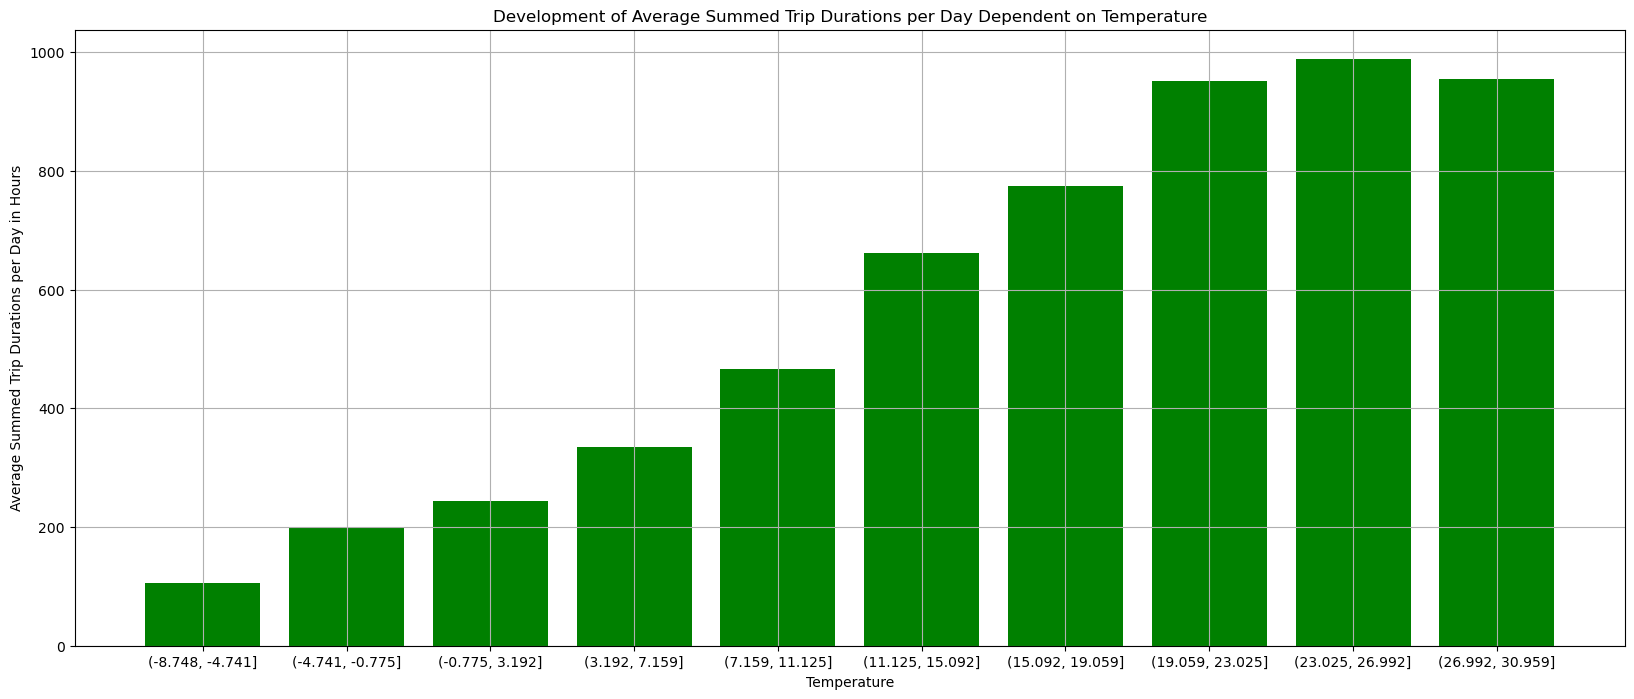

In [85]:
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(df_temp_bins["temp_bin"], df_temp_bins["duration_in_hours"], color="green")
plt.xlabel("Temperature")
plt.ylabel("Average Summed Trip Durations per Day in Hours")
plt.title("Development of Average Summed Trip Durations per Day Dependent on Temperature")
plt.grid(True)
plt.show()

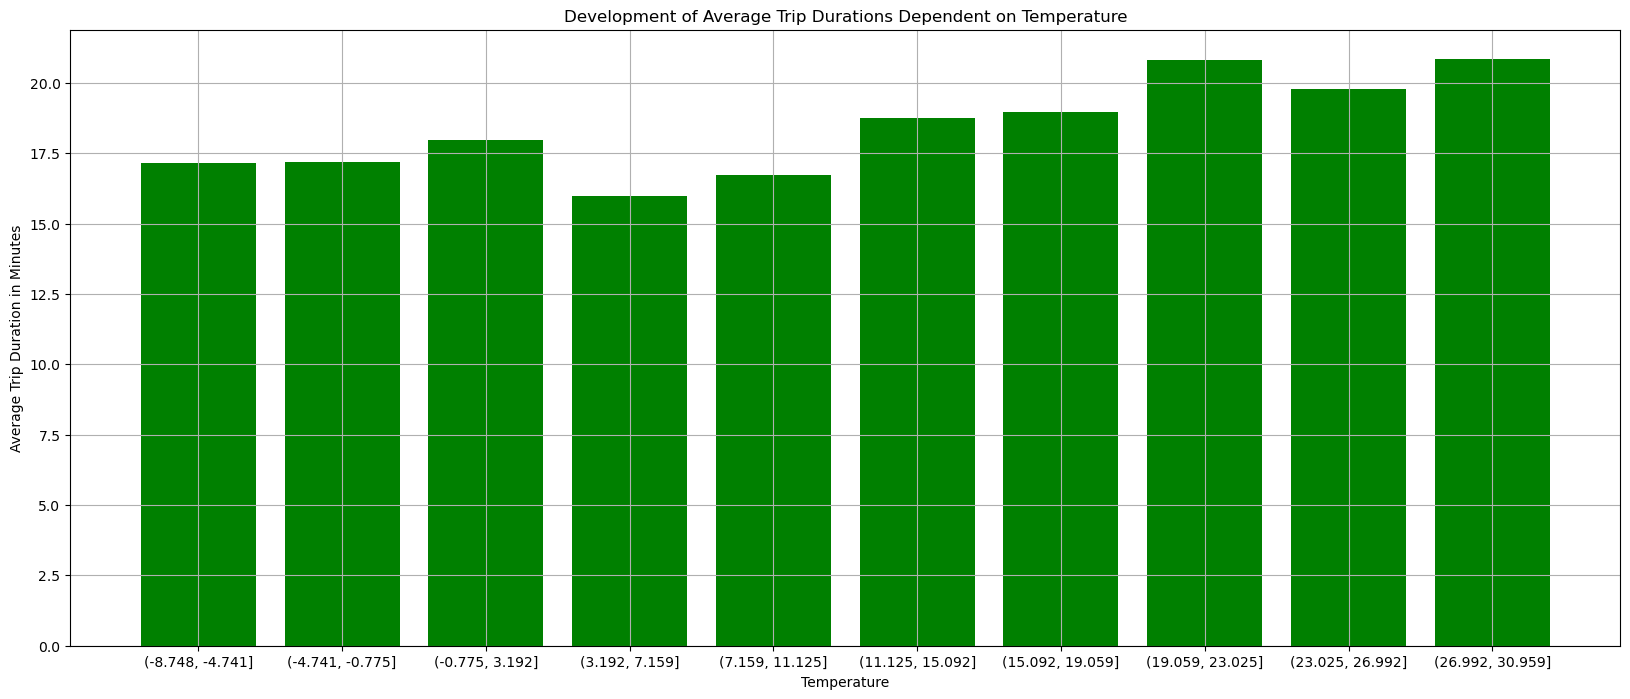

In [86]:
plt.bar(df_temp_bins["temp_bin"], df_temp_bins["avg_duration_per_rental_in_min"], color="green")
plt.xlabel("Temperature")
plt.ylabel("Average Trip Duration in Minutes")
plt.title("Development of Average Trip Durations Dependent on Temperature")
plt.grid(True)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.show()

##### Interpretation of the Results

- When additionally taking weather data into account, we can observe that the average summed rental durations per day are lower on days with precipitation. This is also the case for the average rental duration per day
- Besides that, the average summed rental durations per day also increase with the increase of the temperature
- With the average rental duration per trip we only slightly see this effect (there is not a continuous increase and not a very extreme one as with summed rental durations)

#### Bike Utilization

Bike utilization gives us information on how much the different bikes are used.
This information is relevant to get information about possible unutilized /unused bikes which are maybe actually not needed (unused ressources/capacitiy).
Moreover we analyse how many unique bikes at which time and at which weather condition.

In [87]:
#approximate how many individual bikes there are (we have no information about total number of bikes)
number_of_bikes = len(df["bike_id"].unique())
total_number_of_rentals = len(df) # each row is a rental
print(f"{number_of_bikes=}, {total_number_of_rentals=}")

number_of_bikes=1249, total_number_of_rentals=782225


In [88]:
#Calculate total number of rides for each bike over the whole year
df_bike_ride_count = df.groupby("bike_id")["start_time"].count().reset_index(name="total_number_of_rides").sort_values(by="total_number_of_rides", ascending=False).reset_index(drop=True)
df_bike_ride_count["cumulative_ride_count"] = df_bike_ride_count["total_number_of_rides"].cumsum()
df_bike_ride_count["percentage_number_of_bikes"] = df_bike_ride_count.index.to_series().add(1).divide(number_of_bikes)
df_bike_ride_count["percentage_ride_count"] = df_bike_ride_count["cumulative_ride_count"].divide(total_number_of_rentals)
df_bike_ride_count

bike_id  total_number_of_rides  cumulative_ride_count  \
0       11171                   1354                   1354   
1        5351                   1024                   2378   
2       11010                   1020                   3398   
3        5167                   1018                   4416   
4        5182                   1018                   5434   
...       ...                    ...                    ...   
1244    11792                     52                 782169   
1245    11045                     33                 782202   
1246    11829                      9                 782211   
1247    11003                      7                 782218   
1248    11825                      7                 782225   

      percentage_number_of_bikes  percentage_ride_count  
0                       0.000801               0.001731  
1                       0.001601               0.003040  
2                       0.002402               0.004344  
3                       0.003203               0.005645  
4                       0.004003               0.006947  
...                          ...                    ...  
1244                    0.996797               0.999928  
1245                    0.997598               0.999971  
1246                    0.998399               0.999982  
1247                    0.999199               0.999991  
1248                    1.000000               1.000000  

[1249 rows x 5 columns]

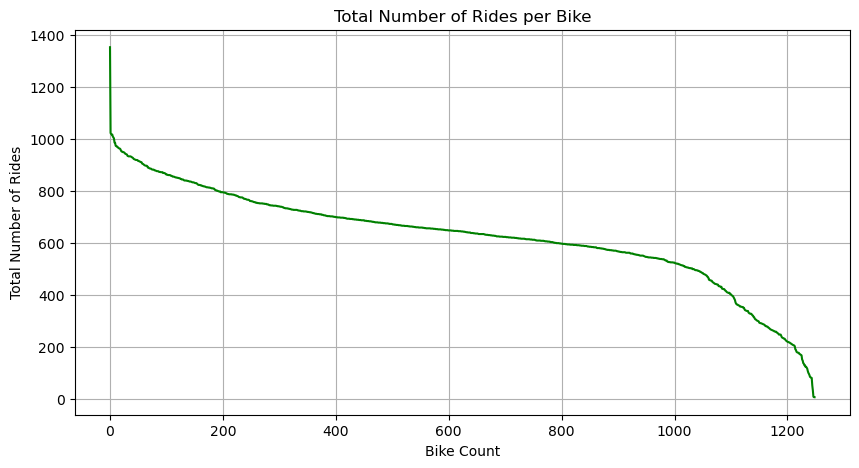

In [89]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_bike_ride_count.index.to_series(), df_bike_ride_count["total_number_of_rides"], color="green")
plt.grid(True)
plt.ylabel("Total Number of Rides")
plt.xlabel("Bike Count")
plt.title("Total Number of Rides per Bike")
plt.show()

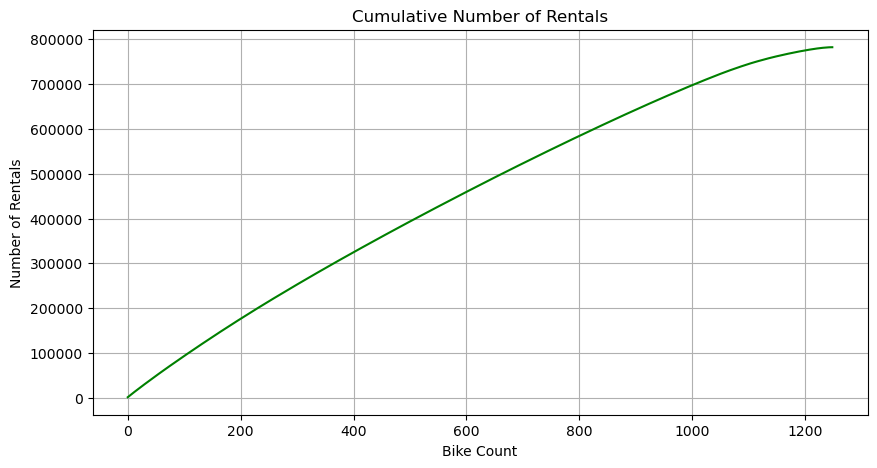

In [90]:
plt.plot(df_bike_ride_count.index.to_series(), df_bike_ride_count["cumulative_ride_count"], color="green")
plt.grid(True)
plt.xlabel("Bike Count")
plt.ylabel("Number of Rentals")
plt.title("Cumulative Number of Rentals")
plt.show()

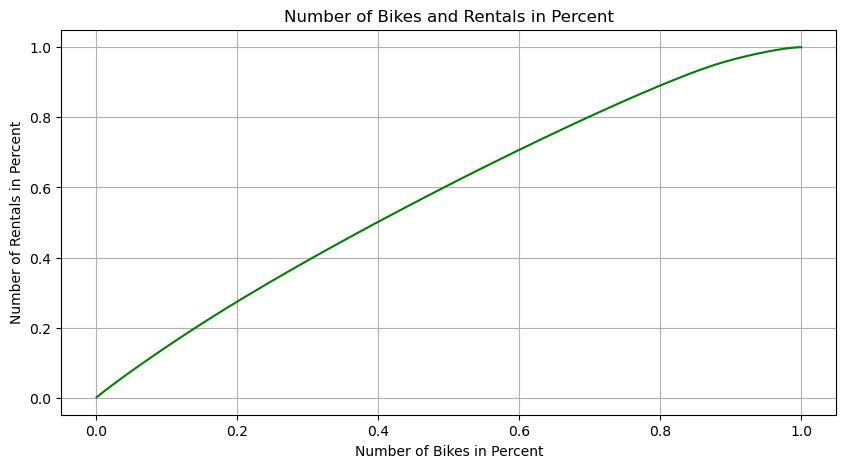

In [91]:
plt.plot(df_bike_ride_count["percentage_number_of_bikes"], df_bike_ride_count["percentage_ride_count"], 
         color="green")
plt.grid(True)
plt.xlabel("Number of Bikes in Percent")
plt.ylabel("Number of Rentals in Percent")
plt.title("Number of Bikes and Rentals in Percent")
plt.show()

In [92]:
#Utilization by month
df_util_month = df.groupby("month")["bike_id"].nunique().reset_index(name="number_of_bikes_used")
df_util_month["utilization"] = df_util_month["number_of_bikes_used"].divide(number_of_bikes)
df_util_month

month  number_of_bikes_used  utilization
0       1                   939     0.751801
1       2                   957     0.766213
2       3                   950     0.760608
3       4                   963     0.771017
4       5                  1042     0.834267
5       6                  1109     0.887910
6       7                  1102     0.882306
7       8                  1151     0.921537
8       9                  1196     0.957566
9      10                  1182     0.946357
10     11                  1186     0.949560
11     12                  1147     0.918335

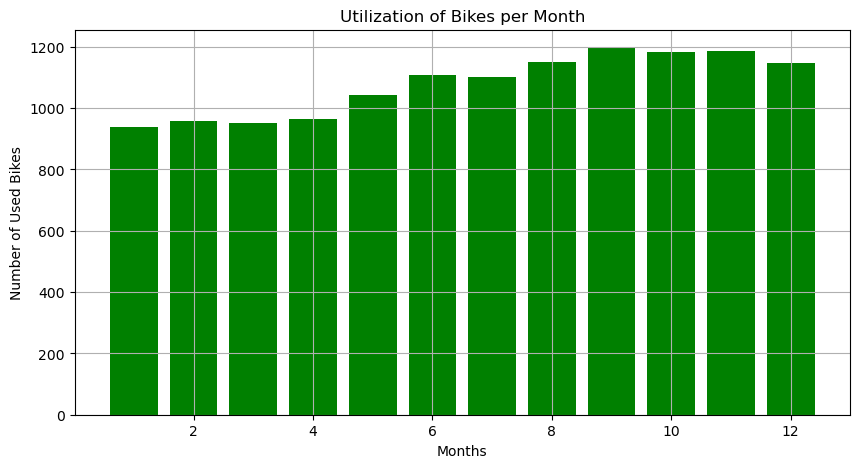

In [93]:
plt.bar(df_util_month["month"], df_util_month["number_of_bikes_used"], color="green")
plt.xlabel("Months")
plt.ylabel("Number of Used Bikes")
plt.title("Utilization of Bikes per Month")
plt.grid(True)
plt.show()

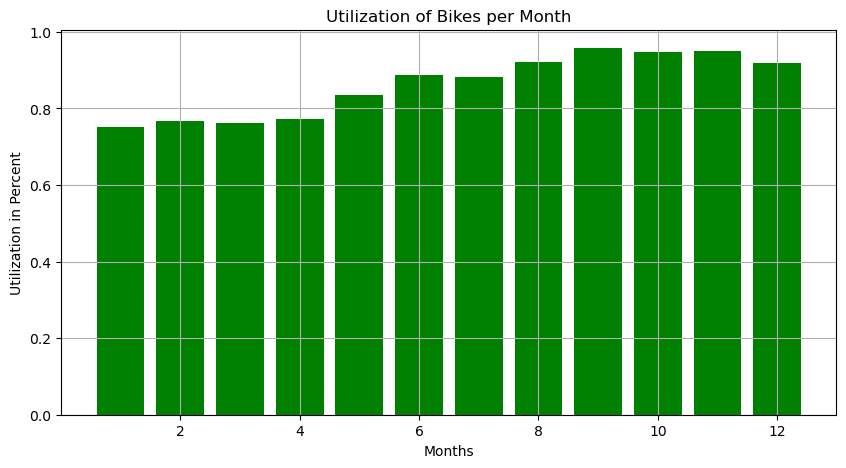

In [94]:
plt.bar(df_util_month["month"], df_util_month["utilization"], color="green")
plt.xlabel("Months")
plt.ylabel("Utilization in Percent")
plt.title("Utilization of Bikes per Month")
plt.grid(True)
plt.show()

It seems that our initial assumption of the total number of bikes could be untrue for the different months.
It could be possible that bikes are added in some months. For example in Mai there is an sudden increase of the bike utilization. 
We will check it in the following steps.

In [95]:
set(df[df["month"]==5]["bike_id"].unique()) - set(df[df["month"]==4]["bike_id"].unique())

{5125,
 5196,
 6701,
 11014,
 11706,
 11708,
 11714,
 11718,
 11719,
 11720,
 11723,
 11725,
 11728,
 11731,
 11736,
 11740,
 11742,
 11743,
 11752,
 11754,
 11755,
 11756,
 11757,
 11759,
 11762,
 11764,
 11766,
 11768,
 11770,
 11771,
 11772,
 11773,
 11776,
 11778,
 11784,
 11795,
 11797,
 11798,
 11804,
 11805,
 11806,
 11807,
 11811,
 11823,
 11828,
 11829,
 11830,
 11832,
 11834,
 11837,
 11843,
 11845,
 11853,
 11855,
 11861,
 11869,
 11874,
 11878,
 11883,
 11885,
 11886,
 11892,
 11893,
 11901,
 11903,
 11904,
 11906,
 11907,
 11910,
 11914,
 11921,
 11923,
 11926,
 11929,
 11930,
 11931,
 11932,
 11942,
 11946,
 11951,
 11952,
 11953,
 11954,
 11955,
 11960}

 It seems that bikes above 11700 are added in Mai.

In [96]:
#Check for bikes with BikeID above 11700 for months 1 to 4
for i in range(1,5):
    print((df[df["month"]==i]["bike_id"] > 11700).any())

False
False
False
False


In [97]:
#Get the highest BikeID for each month
df.groupby("month")["bike_id"].max()

month
1     11365
2     11365
3     11365
4     11365
5     11960
6     11964
7     11964
8     11965
9     11964
10    11964
11    11965
12    11965
Name: bike_id, dtype: int64

In [98]:
#Weekly values
df_bike_count_weekly = df.groupby("week")["bike_id"].nunique().reset_index(name="number_of_bikes")

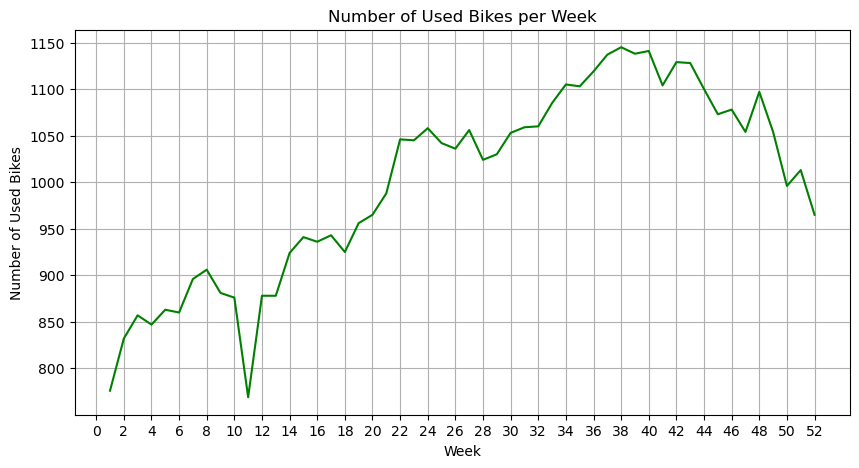

In [99]:
plt.plot(df_bike_count_weekly["week"], df_bike_count_weekly["number_of_bikes"], color="green")
plt.xlabel("Week")
plt.ylabel("Number of Used Bikes")
plt.title("Number of Used Bikes per Week")
plt.xticks(range(0,53,2))
plt.grid(True)
plt.show()

In [100]:
#Daily values
df_bike_count_daily = df.groupby(["date"])["bike_id"].nunique().reset_index(name="number_of_bikes")
df_bike_count_daily

date  number_of_bikes
0    2017-01-01              453
1    2017-01-02              193
2    2017-01-03              363
3    2017-01-04              560
4    2017-01-05              473
..          ...              ...
360  2017-12-27              358
361  2017-12-28              345
362  2017-12-29              327
363  2017-12-30              132
364  2017-12-31              163

[365 rows x 2 columns]

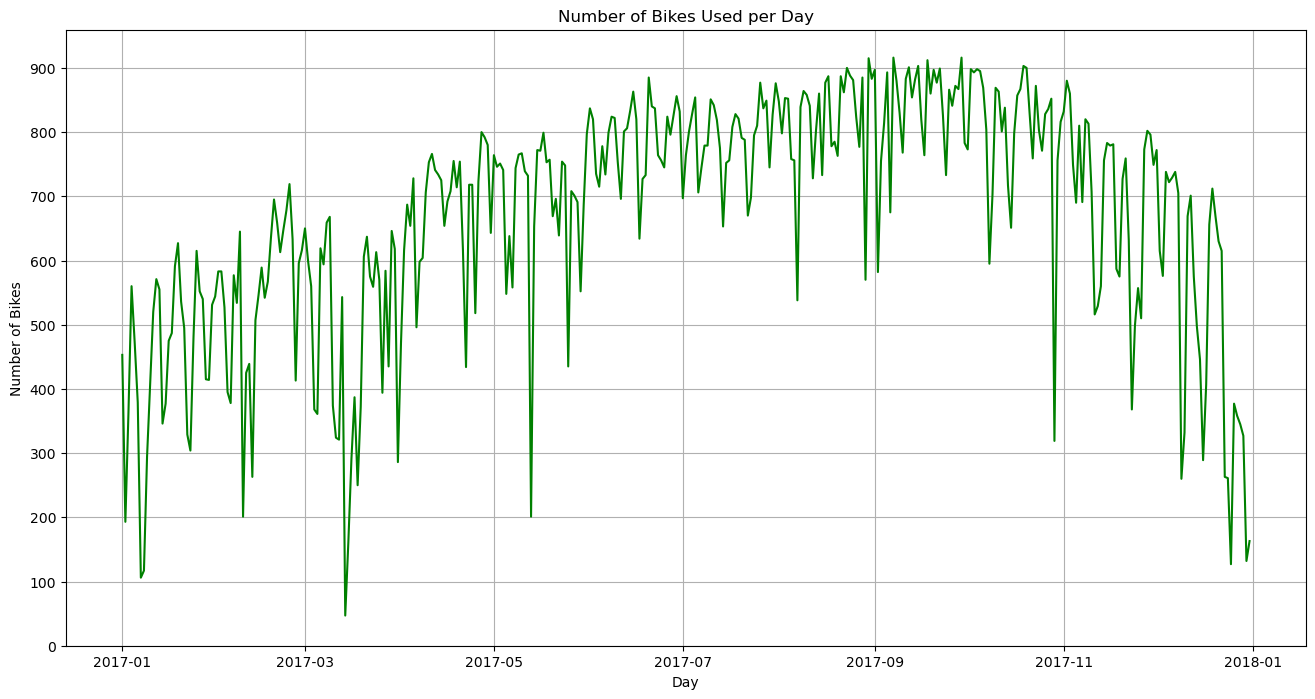

In [101]:
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(df_bike_count_daily["date"], df_bike_count_daily["number_of_bikes"], color="green")
plt.grid(True)
plt.yticks(range(0,1000,100))
plt.xlabel("Day")
plt.ylabel("Number of Bikes")
plt.title("Number of Bikes Used per Day")
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.show()

In [102]:
#Average bike utilization by weekday
df_bike_count_daily["date"] = pd.to_datetime(df_bike_count_daily["date"])
df_bike_count_daily["weekday"] = df_bike_count_daily["date"].dt.weekday
df_weekday = df_bike_count_daily.groupby("weekday")["number_of_bikes"].mean().reset_index(name="avg_n_bikes")
df_weekday

weekday  avg_n_bikes
0        0   688.923077
1        1   699.134615
2        2   733.134615
3        3   709.173077
4        4   693.057692
5        5   591.403846
6        6   581.603774

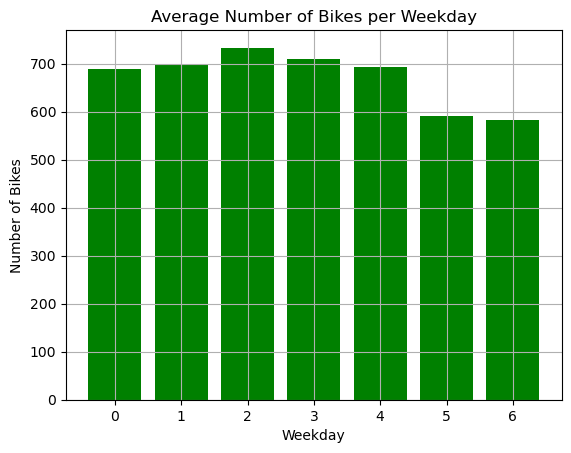

In [103]:
plt.bar(df_weekday["weekday"], df_weekday["avg_n_bikes"], color="green")
plt.xlabel("Weekday")
plt.ylabel("Number of Bikes")
plt.title("Average Number of Bikes per Weekday")
plt.grid(True)
plt.show()

In [104]:
#Average bike utilization by hour of day
df_bike_count_hourly = df.groupby(["date", "hour"])["bike_id"].nunique().reset_index(name="number_of_bikes")
df_hour_of_day = df_bike_count_hourly.groupby("hour")["number_of_bikes"].mean().reset_index(name="avg_n_bikes")
df_hour_of_day

hour  avg_n_bikes
0      0    20.259669
1      1    13.102778
2      2     9.436950
3      3     4.815152
4      4     4.864162
5      5    19.426593
6      6    51.326923
7      7   100.427397
8      8   160.764384
9      9   101.164384
10    10    80.238356
11    11    87.412088
12    12    98.906849
13    13    99.997260
14    14   103.613699
15    15   116.290411
16    16   146.813699
17    17   200.663014
18    18   150.873973
19    19   119.153425
20    20    86.238356
21    21    63.454795
22    22    48.002740
23    23    32.928375

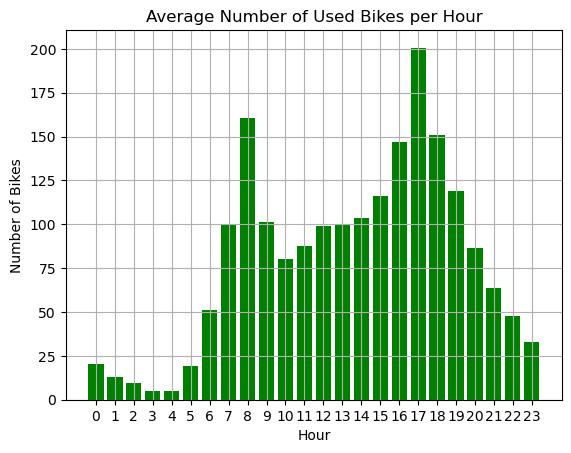

In [105]:
plt.bar(df_hour_of_day["hour"], df_hour_of_day["avg_n_bikes"], color="green")
plt.xlabel("Hour")
plt.ylabel("Number of Bikes")
plt.title("Average Number of Used Bikes per Hour")
plt.xticks(range(0,24,1))
plt.grid(True)
plt.show()

##### Interpretation of the Results

- We approximated which number of total bikes there could be in the fleet 
- We  found a total of 1249 individual bikes in the data set 
- However, there are likely bikes added over time, since some bikeID's (especially higher ones) only occur starting at a certain month in the year
- This fact has to be considered when analyzing the results

- When analyzing the utilization of the individual bikes we can observe that only a few bikes (about five) are used significantly more than the others. And about two hundred bikes are used less than most bikes. But for most bikes, as seen in the graph the utilization does not vary too much. Besides that, because some bikes are likely to be added over time, it makes sense that these bikes were not used as much as the rest of the bikes.

- The bike utilization per month (considering a total number of bikes of 1249) shows that it was likely that bikes were added for example in Mai. Since we can see a sudden increase in the utilization (in the months before the utilization was quite the same)

- When analyzing the average number of bikes used per weekday it becomes clear that there are on average more bikes used during the week than during the weekends. Similar to the development of the number of rides.
- The development during the day also shows similar results to the development of the number of rides. We have clear peaks at 8 am and 5 pm.

##### Bike Utilization Dependent on Weather

In [106]:
#Calculate average number of bikes used on hour with precipitation vs. one with none
df_hourly = df_merge.groupby(["date", "hour"]).agg({"bike_id": lambda x: x.nunique(), 
                                                    "precip": lambda x: x.sum(),
                                                   "avg_temp": lambda x: x.mean()})
df_hourly = df_hourly.rename(columns={"bike_id": "n_bikes_used"})
df_no_precip_hourly = df_hourly[df_hourly["precip"] == 0]
df_precip_hourly = df_hourly[df_hourly["precip"] > 0]
print(f"with precip: {df_precip_hourly['n_bikes_used'].mean()} avg bikes used per hour\nwithout: {df_no_precip_hourly['n_bikes_used'].mean()} avg bikes used per hour")

with precip: 54.13864306784661 avg bikes used per hour
without: 83.03229844767151 avg bikes used per hour


In [107]:
#Calculate average number of bikes used on hour dependent on temperature
df_hourly["temp_bin"] = pd.cut(df_hourly["avg_temp"], 10)
df_temp_bins_hourly = df_hourly.groupby("temp_bin")["n_bikes_used"].mean().reset_index(name="avg_n_bikes_per_hour")
df_temp_bins_hourly["temp_bin"] = df_temp_bins_hourly["temp_bin"].astype(str)
df_temp_bins_hourly

temp_bin  avg_n_bikes_per_hour
0  (-11.146, -6.49]             19.271930
1    (-6.49, -1.88]             30.345395
2     (-1.88, 2.73]             39.593343
3      (2.73, 7.34]             50.537669
4     (7.34, 11.95]             67.681579
5    (11.95, 16.56]             84.082897
6    (16.56, 21.17]             98.039492
7    (21.17, 25.78]             99.128514
8    (25.78, 30.39]            122.324614
9     (30.39, 35.0]            132.101167

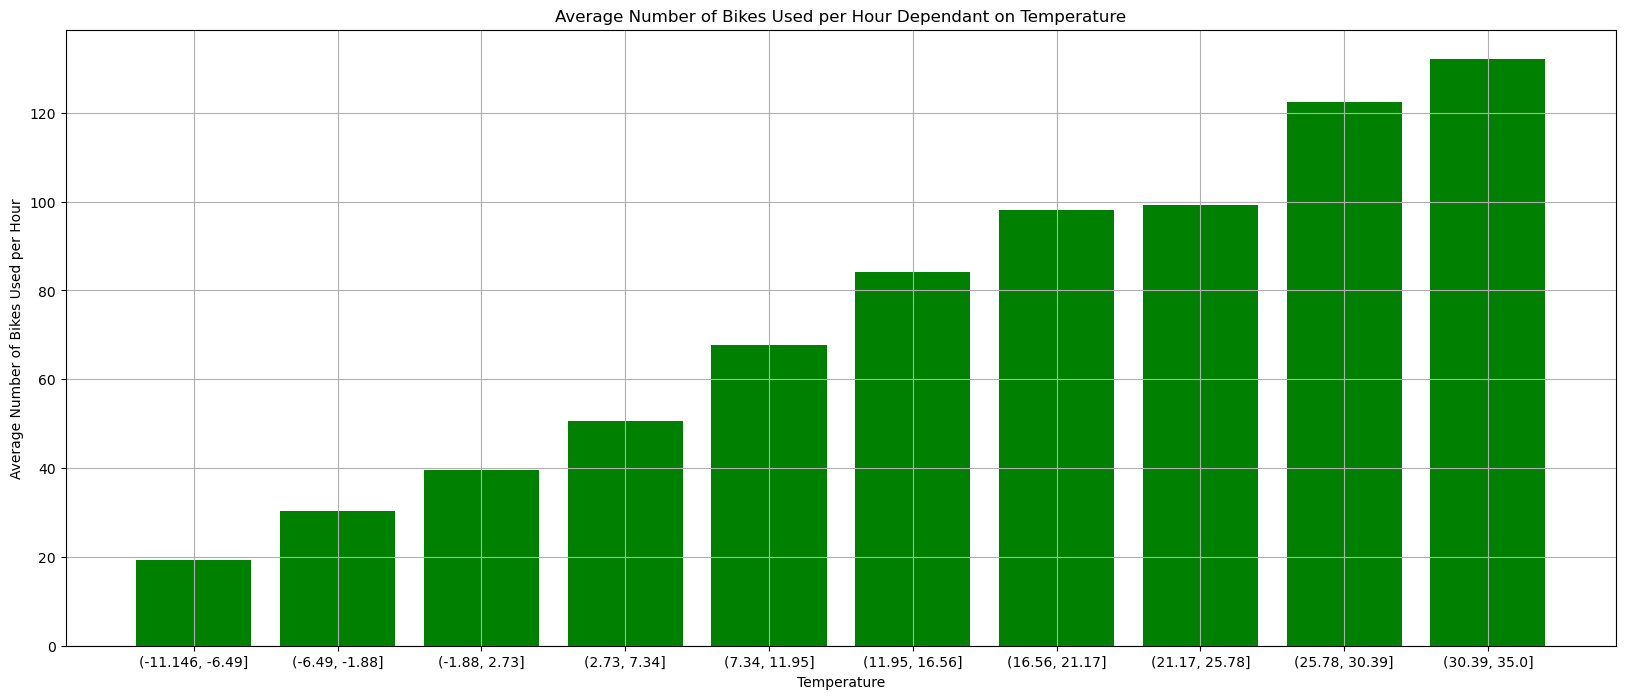

In [108]:
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(df_temp_bins_hourly["temp_bin"], df_temp_bins_hourly["avg_n_bikes_per_hour"], color="green")
plt.xlabel("Temperature")
plt.ylabel("Average Number of Bikes Used per Hour")
plt.title("Average Number of Bikes Used per Hour Dependant on Temperature")
plt.grid(True)
plt.show()

In [109]:
#Calculate average number of bikes used on day with precipitation vs. one with none
df_daily = df_merge.groupby("date").agg({"bike_id": lambda x: x.nunique(), 
                                         "precip": lambda x: x.sum(),
                                         "avg_temp": lambda x: x.mean()})
df_daily = df_daily.rename(columns={"bike_id": "n_bikes_used"})
df_no_precip_daily = df_daily[df_daily["precip"] == 0]
df_precip_daily = df_daily[df_daily["precip"] > 0]
print(f"with precip: {df_precip_daily['n_bikes_used'].mean()} avg bikes used per day\nwithout: {df_no_precip_daily['n_bikes_used'].mean()} avg bikes used per day")

with precip: 607.5507246376811 avg bikes used per day
without: 709.0484581497798 avg bikes used per day


In [110]:
#Calculate average number of bikes used on day dependent on temperature
df_daily["temp_bin"] = pd.cut(df_daily["avg_temp"], 10)
df_daily

n_bikes_used  precip  avg_temp          temp_bin
date                                                        
2017-01-01           453     0.0  7.354472   (7.159, 11.125]
2017-01-02           193   225.0  4.415446    (3.192, 7.159]
2017-01-03           363   384.0  6.755494    (3.192, 7.159]
2017-01-04           560   129.0  8.844293   (7.159, 11.125]
2017-01-05           473     0.0 -0.328090   (-0.775, 3.192]
...                  ...     ...       ...               ...
2017-12-27           358     0.0 -4.334992  (-4.741, -0.775]
2017-12-28           345     0.0 -8.012633  (-8.748, -4.741]
2017-12-29           327     0.0 -7.938156  (-8.748, -4.741]
2017-12-30           132    66.0 -5.518317  (-8.748, -4.741]
2017-12-31           163     0.0 -8.708051  (-8.748, -4.741]

[365 rows x 4 columns]

In [111]:
df_temp_bins = df_daily.groupby("temp_bin")["n_bikes_used"].mean().reset_index(name="avg_n_bikes_per_day")
df_temp_bins["temp_bin"] = df_temp_bins["temp_bin"].astype(str)
df_temp_bins

temp_bin  avg_n_bikes_per_day
0  (-8.748, -4.741]           229.666667
1  (-4.741, -0.775]           379.000000
2   (-0.775, 3.192]           425.206897
3    (3.192, 7.159]           530.348837
4   (7.159, 11.125]           621.953488
5  (11.125, 15.092]           688.378378
6  (15.092, 19.059]           745.907407
7  (19.059, 23.025]           784.139535
8  (23.025, 26.992]           819.558824
9  (26.992, 30.959]           779.884615

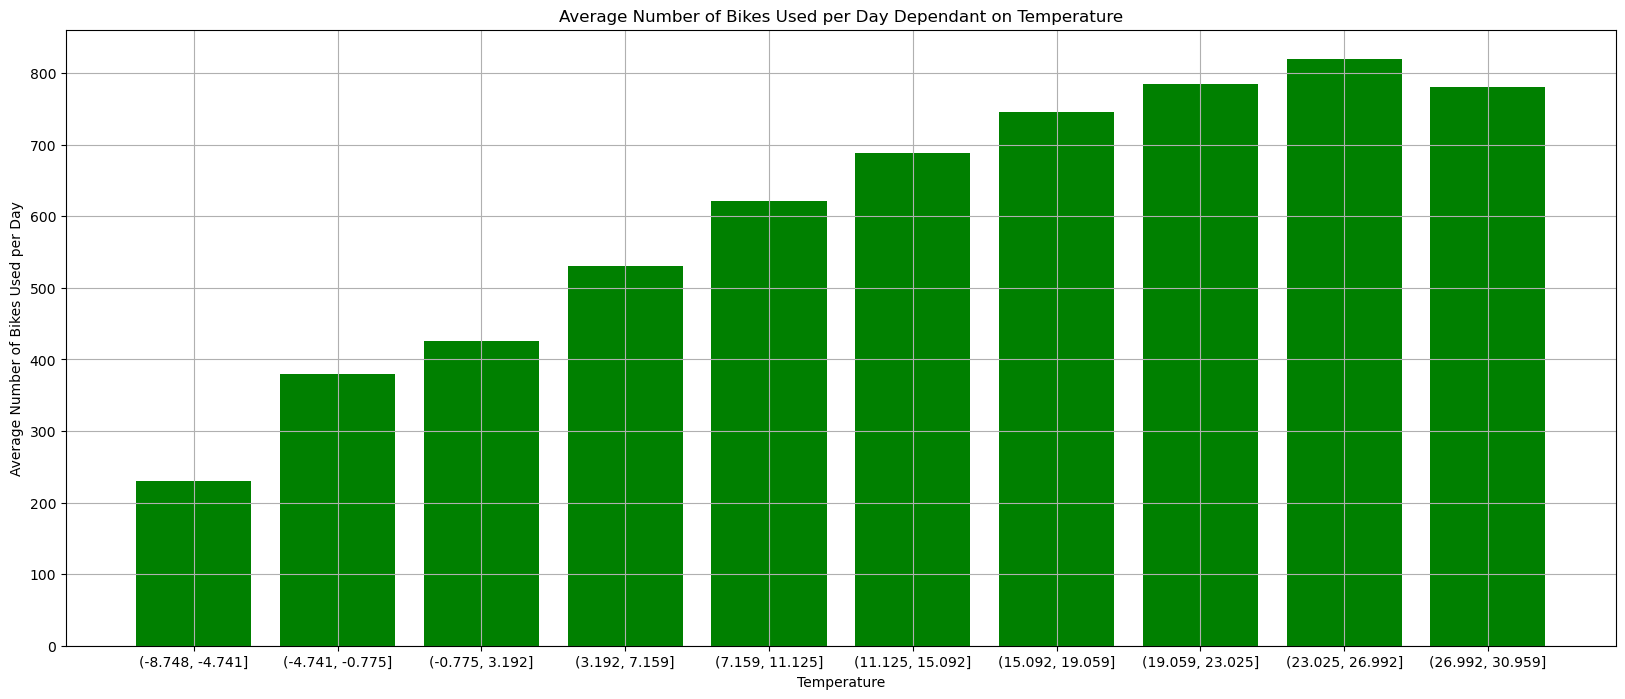

In [112]:
plt.bar(df_temp_bins["temp_bin"], df_temp_bins["avg_n_bikes_per_day"], color="green")
plt.xlabel("Temperature")
plt.ylabel("Average Number of Bikes Used per Day")
plt.title("Average Number of Bikes Used per Day Dependant on Temperature")
plt.grid(True)
plt.show()

##### Interpretation of the Results

The average number of bikes used per hour is lower when precipitationis recorded. Besides that, we see a steady increase in the average number of bikes used per hour with the increase in the temperature. This is also the case for the average number of bikes used per day.

#### Revenue

For this KPI we will calculate the revenue for every trip based on the given user_type. We can not calculate the revenue per user,
since we do not have any information about specific users in our dataset. Beforehand an analysis on the user_type`s themselves was 
done, to gain a deeper understanding of those.

First we look into the total distribution of rides by user types visualized by a pie chart.

In [113]:
# Count all rides per user type and sort descending
df_philadelphia_cleaned.groupby(["user_type"])["user_type"].count().reset_index(name = "n_rides").sort_values(by=['n_rides'], ascending=False)

user_type  n_rides
0      Indego30   662593
5       Walk-up    99043
1     Indego365     6787
3  One Day Pass     6236
2    IndegoFlex     5972
4  Two Day Pass     1594

In [114]:
# Put data into Series to visualize as Pie Chart
slices = [662593, 99043, 6787, 6236, 5972, 1594]
user_types = ['Indego30','Walk-up', 'Indego365', 'OneDayPass', 'IndegoFlex', 'TwoDayPass']
cols = ['b','r','c','g', 'orange', 'magenta']

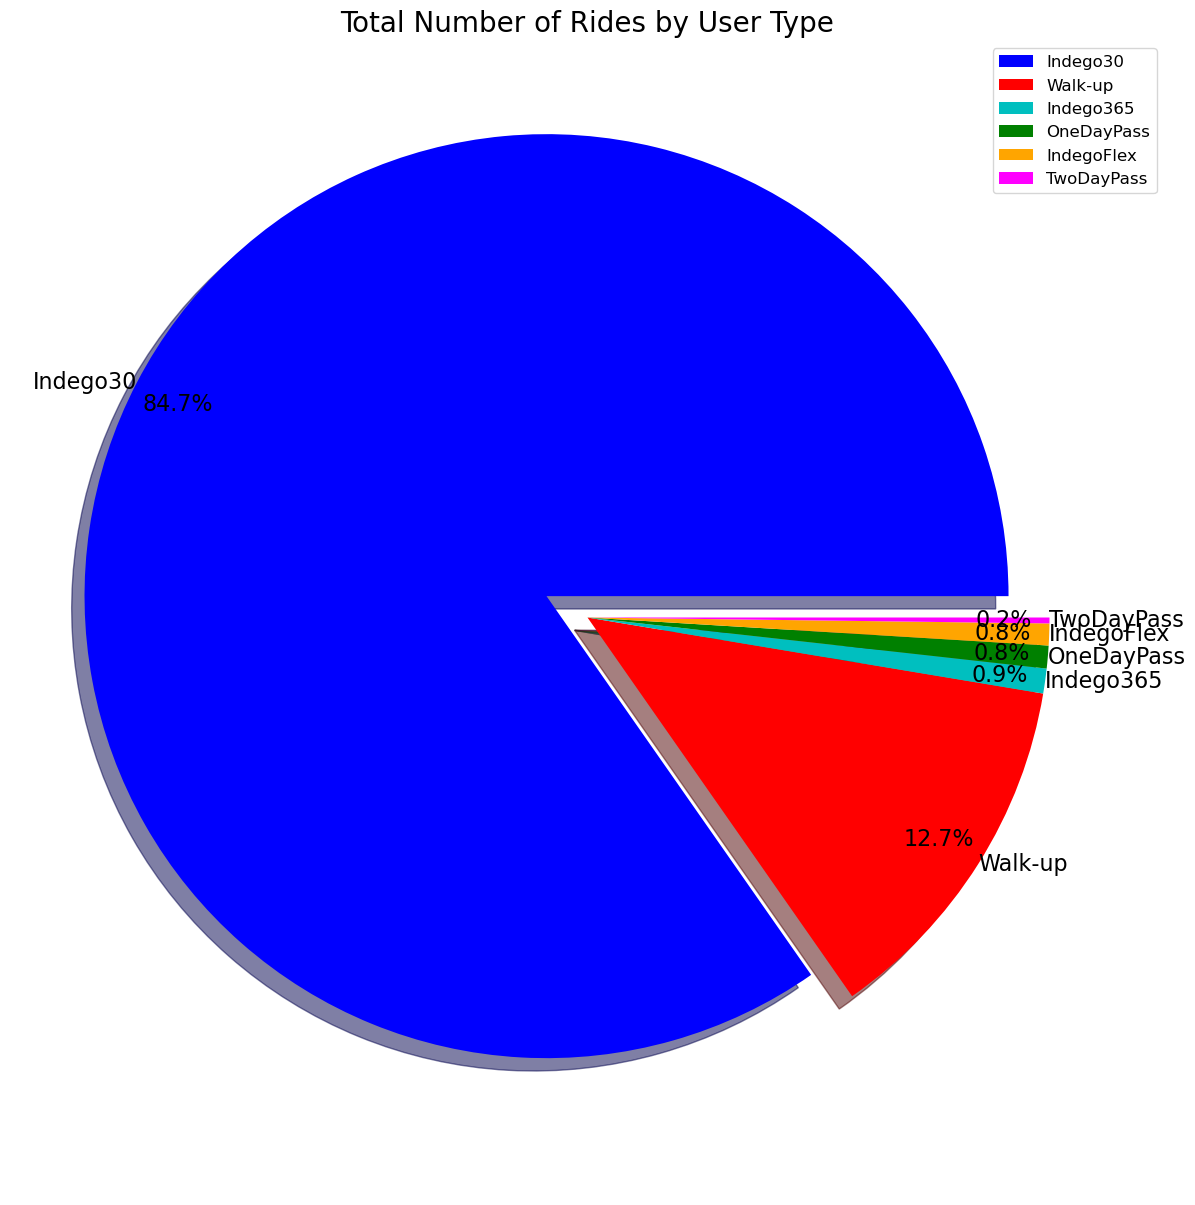

In [115]:
# Create pie chart
fig = plt.figure(figsize=(15,15))
plt.pie(slices,
labels = user_types,
labeldistance = 1,
pctdistance = 0.9,
colors = cols,
startangle = 0,
shadow = True,
explode =(0.1,0,0,0,0,0),
autopct ='%1.1f%%',
textprops={'fontsize': 16})
plt.title('Total Number of Rides by User Type', fontsize=20)
plt.legend(fontsize=12)

# Print the chart
plt.show()

Now we will look at the trip duration for every user type.

In [116]:
# Preparing new dataframe with only trip_duration (converted to minutes) and the user_type
df_phil_rentDuration = df_philadelphia_cleaned[['trip_duration', 'user_type']].copy(deep=True)
df_phil_rentDuration.loc[:, 'trip_duration'] = df_phil_rentDuration['trip_duration'].dt.seconds / 60
df_phil_rentDuration.rename(columns={'trip_duration': 'trip_duration in minutes'}, inplace=True)
df_phil_rentDuration['trip_duration in minutes'] = df_phil_rentDuration['trip_duration in minutes'].astype(int)
# The dataset from above needs to be resetted, so it doesnt need to be done here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df_phil_rentDuration.reset_index(drop = True, inplace = True)

# Final dataframe
df_phil_rentDuration

trip_duration in minutes user_type
0                             11  Indego30
1                             36   Walk-up
2                             35   Walk-up
3                             12  Indego30
4                              8   Walk-up
...                          ...       ...
782220                        28  Indego30
782221                       712  Indego30
782222                         7  Indego30
782223                         1  Indego30
782224                        14  Indego30

[782225 rows x 2 columns]

In [117]:
# Group by on the user_type to find out the trip_duration for every user_type
df_phil_rentDuration = df_phil_rentDuration.groupby(['user_type']).sum().reset_index()

# Every user_type devided by the total amount of trip_duration
df_phil_rentDuration['percentage of trip_duration in minutes'] = df_phil_rentDuration['trip_duration in minutes'] / df_phil_rentDuration['trip_duration in minutes'].sum()
df_phil_rentDuration

user_type  trip_duration in minutes  \
0      Indego30                  10035277   
1     Indego365                     78727   
2    IndegoFlex                    162286   
3  One Day Pass                    204940   
4  Two Day Pass                     41903   
5       Walk-up                   4146764   

   percentage of trip_duration in minutes  
0                                0.684073  
1                                0.005367  
2                                0.011063  
3                                0.013970  
4                                0.002856  
5                                0.282672

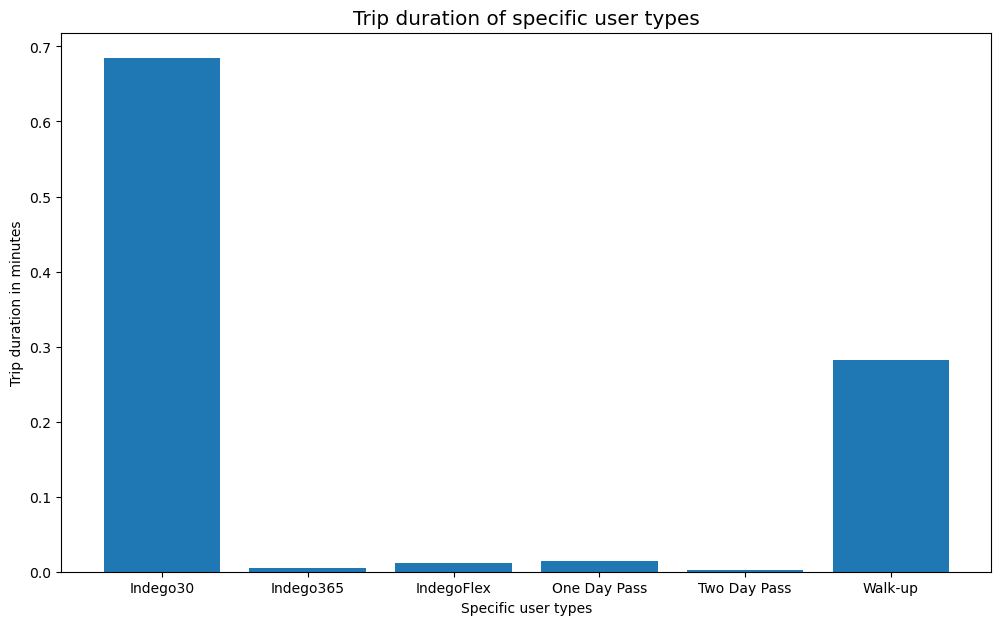

In [118]:
# Plotting
fig = plt.figure(figsize=(12,7))
plt.bar(df_phil_rentDuration['user_type'], df_phil_rentDuration['percentage of trip_duration in minutes'])

# Styling the plot
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xlabel('Specific user types', size = 'medium')
plt.ylabel('Trip duration in minutes', size = 'medium')
plt.title('Trip duration of specific user types', size = 'x-large')
plt.show()

Next we take a look at monthly development of rides by user types to look for any seasonal patterns:

In [119]:
# Create Dataframe grouped by User types and months
df_months_usertype = df_philadelphia_cleaned.groupby(['month','user_type'])["user_type"].count().reset_index(name = "n_rides").sort_values(by=['month'], ascending=True)

# Split Dataframe into multiple Dataframes for each usertype
df_months_indego30 = df_months_usertype[df_months_usertype['user_type'] == "Indego30"]
df_months_indego365 = df_months_usertype[df_months_usertype['user_type'] == "Indego365"]
df_months_indegoflex = df_months_usertype[df_months_usertype['user_type'] == "IndegoFlex"]
df_months_walkup = df_months_usertype[df_months_usertype['user_type'] == "Walk-up"]
df_months_onedaypass = df_months_usertype[df_months_usertype['user_type'] == "One Day Pass"]
df_months_twodaypass = df_months_usertype[df_months_usertype['user_type'] == "Two Day Pass"]

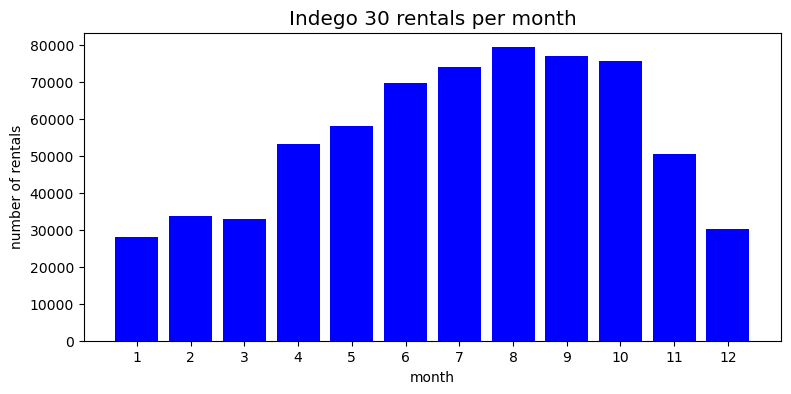

In [120]:
# Create Bar Chart for monthly rides with Indego30
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_indego30["month"], df_months_indego30["n_rides"], color = 'blue')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Indego 30 rentals per month", size = 'x-large')
plt.show()

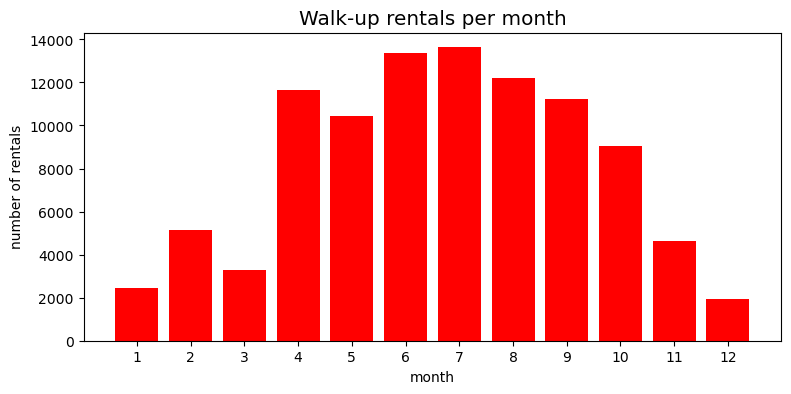

In [121]:
# Create Bar Chart for monthly rides with Walk-Up
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_walkup["month"], df_months_walkup["n_rides"], color = 'red')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Walk-up rentals per month", size = 'x-large')
plt.show()

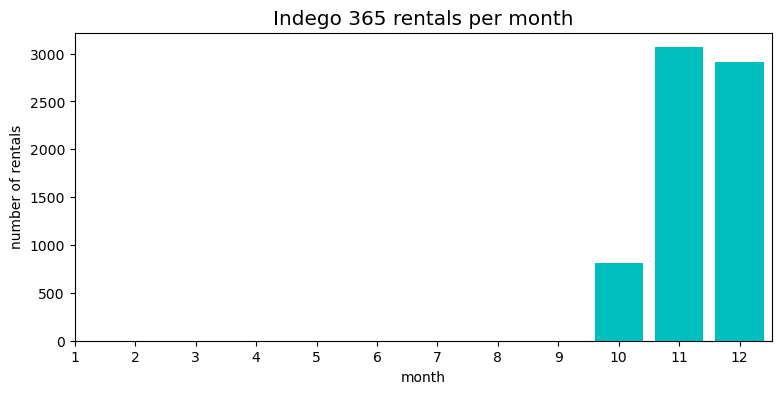

In [122]:
# Create Bar Chart for monthly rides with Indego 365
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_indego365["month"], df_months_indego365["n_rides"], color = 'c')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Indego 365 rentals per month", size = 'x-large')
plt.show()

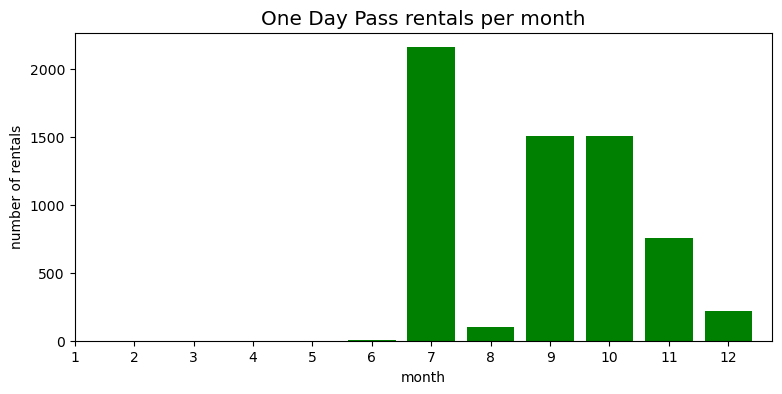

In [123]:
# Create Bar Chart for monthly rides with One Day Pass
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_onedaypass["month"], df_months_onedaypass["n_rides"], color = 'g')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("One Day Pass rentals per month", size = 'x-large')
plt.show()

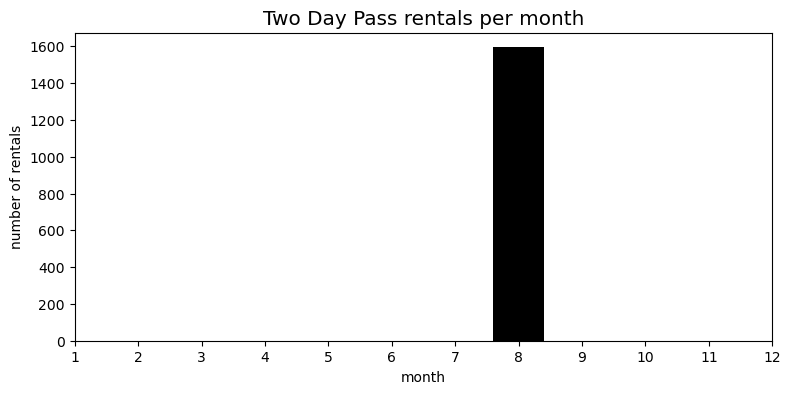

In [124]:
# Create Bar Chart for monthly rides with Two Day Pass
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_twodaypass["month"], df_months_twodaypass["n_rides"], color = 'black')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Two Day Pass rentals per month", size = 'x-large')
plt.show()

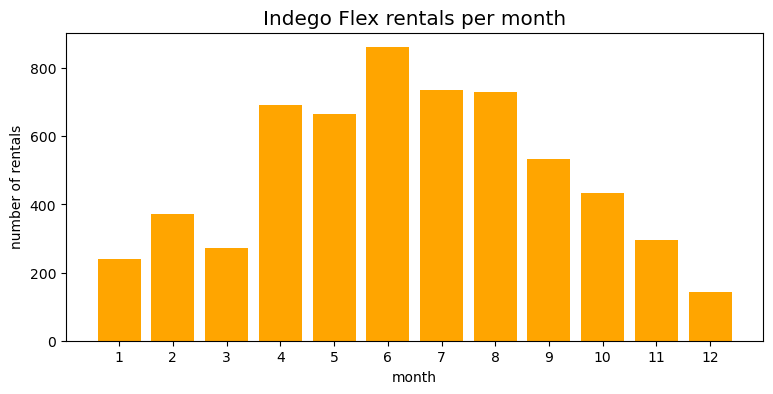

In [125]:
# Create Bar Chart for monthly rides with Indego Flex
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_indegoflex["month"], df_months_indegoflex["n_rides"], color = 'orange')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Indego Flex rentals per month", size = 'x-large')
plt.show()

#### Analysis and Interpretation of the User Type Analysis:
The plots above all show that we the vast majority of rides (roughly 85%) are made using the Indego30 option, which is a monthly subscription. This target audience should therefore be always be a special focus. The second largest portion is attributed to spontaneous Walk-up rides which make up around 12,5%. The other are very minor compared to the monthly subscription services making up only around 2,5% of the total rides.
<br><br>Another result to note is that, the seasonality has a effect on the usage of the different payment models. Especially the One Day Pass is comparetively to other months  popular during the summer. It can be assumed that this can be accounted to the increase in tourism during those months.
<br><br>The Two Day Pass is a special case as it was seemingly only offered in the month of August in 2017. The significant lower number of rides with the One Day Pass can also be explained with the popularity of the Two Day Pass in this month. 
<br><br>The annual subscription model Indigo 365 was seeminlgy only introduced in October, but is already a popular choice even rivaling the monthly subscription model Indigo30 for the number of rides in December.
<br><br>Overall, we see a similiar monthly development for the options Indigo30, IndegoFlex and Walk-up, which were available throughout the year. Based on these results you could increase the marketing of some of the offers to either improve the usage or possibly stop some offers with low customer acceptance, like IndegoFlex.

#### Now the actual revenue analysis starts!

In [126]:
# Prepare new dataframe for calculating the revenue
df_phil_revenue = df_philadelphia_cleaned[['end_time', 'trip_duration', 'user_type', 'weekday']].copy(deep=True)
df_phil_revenue.loc[:, 'trip_duration'] = df_phil_revenue['trip_duration'].dt.seconds / 60
df_phil_revenue.rename(columns={'trip_duration': 'trip_duration_in_minutes'}, inplace=True)
# Since we have full minutes without any remainder we can convert the trip_duration in minutes to int
df_phil_revenue['trip_duration_in_minutes'] = df_phil_revenue['trip_duration_in_minutes'].astype(int)
# The dataset from above needs to be resetted, so it doesnt need to be done here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df_phil_revenue.reset_index(drop = True, inplace =True)
df_phil_revenue

end_time  trip_duration_in_minutes user_type  weekday
0      2017-01-01 00:16:00                        11  Indego30        6
1      2017-01-01 00:57:00                        36   Walk-up        6
2      2017-01-01 00:57:00                        35   Walk-up        6
3      2017-01-01 00:39:00                        12  Indego30        6
4      2017-01-01 00:36:00                         8   Walk-up        6
...                    ...                       ...       ...      ...
782220 2017-12-31 23:33:00                        28  Indego30        6
782221 2018-01-01 11:03:00                       712  Indego30        6
782222 2017-12-31 23:25:00                         7  Indego30        6
782223 2017-12-31 23:40:00                         1  Indego30        6
782224 2017-12-31 23:55:00                        14  Indego30        6

[782225 rows x 4 columns]

Prices for the specific "user_type" in our dataframe were found through the help of the Wayback Machine in 2017:
- Walk-up: $4 per 30 minutes
- IndegoFlex: $4 per hour
- One Day Pass: Unlimited 30 minute trips + $2 per 30 minutes for trips over 30 minutes
- Two Day Pass: Unlimited 30 minute trips + $2 per 30 minutes for trips over 30 minutes
- Indego365: Unlimited 1 hour trips + $4 per hour for trips over 1 hour
- Indego30: Unlimited 1 hour trips + $4 per hour for trips over 1 hour

Since we were not able to find any information regarding the "Two Day Pass", we assumed that the same pricing conditions apply from the "One Day Pass" to the "Two Day Pass".

In [127]:
# Calculation of every user_type pricing condition and saving it in a new column called "revenue_in_$"
for i in range(0, len(df_phil_revenue)):
    # We need the duration and the user_type beforehand to determine the different pricing conditions 
    duration = df_phil_revenue.at[i, 'trip_duration_in_minutes']
    price_type = df_phil_revenue.at[i, 'user_type']
    if(price_type == 'Walk-up'):
        df_phil_revenue.at[i, 'revenue_in_$'] = 4*(np.ceil((df_phil_revenue.at[i, 'trip_duration_in_minutes'])/30))
    elif(price_type == 'IndegoFlex'):
        df_phil_revenue.at[i, 'revenue_in_$'] = 4*(np.ceil((df_phil_revenue.at[i, 'trip_duration_in_minutes'])/60))
    elif(price_type == 'One Day Pass' or price_type == 'Two Day Pass'):
        # Since there are unlimited 30 minute trips, we can just give them 0$ revenue as a result
        if(duration <= 30):
            df_phil_revenue.at[i, 'revenue_in_$'] = 0
        else:
            # - 30 needs to be added to the calculation, so the first half an hour doesnt count in
            df_phil_revenue.at[i, 'revenue_in_$'] = 2*(np.ceil((df_phil_revenue.at[i, 'trip_duration_in_minutes'] - 30)/30))
    elif(price_type == 'Indego365' or price_type == 'Indego30'):
        # Since there are unlimited 60 minute trips, we can just give them 0$ revenue as a result
        if(duration <= 60):
            df_phil_revenue.at[i, 'revenue_in_$'] = 0
        else:
            # - 60 needs to be added to the calculation, so the first hour doesnt count in
            df_phil_revenue.at[i, 'revenue_in_$'] = 4*(np.ceil((df_phil_revenue.at[i, 'trip_duration_in_minutes'] - 60)/60))

# Since we dont have any values with remainder, we can also convert the revenue into an int for convenience, and drop the trip duration
df_phil_revenue['revenue_in_$'] = df_phil_revenue['revenue_in_$'].astype(int)
df_phil_revenue.drop('trip_duration_in_minutes', axis = 1, inplace = True)

In [128]:
# Finished dataframe with all revenue calculations done
df_phil_revenue

end_time user_type  weekday  revenue_in_$
0      2017-01-01 00:16:00  Indego30        6             0
1      2017-01-01 00:57:00   Walk-up        6             8
2      2017-01-01 00:57:00   Walk-up        6             8
3      2017-01-01 00:39:00  Indego30        6             0
4      2017-01-01 00:36:00   Walk-up        6             4
...                    ...       ...      ...           ...
782220 2017-12-31 23:33:00  Indego30        6             0
782221 2018-01-01 11:03:00  Indego30        6            44
782222 2017-12-31 23:25:00  Indego30        6             0
782223 2017-12-31 23:40:00  Indego30        6             0
782224 2017-12-31 23:55:00  Indego30        6             0

[782225 rows x 4 columns]

In [129]:
# Creating a new dataframe for easier usage later on for the plots
df_phil_revenue_plt = df_phil_revenue.copy()

# Setting the end_time as our new index to resample 
df_phil_revenue_plt.sort_values(['end_time'], inplace = True)
df_phil_revenue_plt.set_index('end_time', inplace = True)

#Finished dataframe for plotting purposes
df_phil_revenue_plt

user_type  weekday  revenue_in_$
end_time                                            
2017-01-01 00:16:00  Indego30        6             0
2017-01-01 00:36:00   Walk-up        6             4
2017-01-01 00:36:00   Walk-up        6             4
2017-01-01 00:39:00  Indego30        6             0
2017-01-01 00:40:00  Indego30        6             0
...                       ...      ...           ...
2017-12-31 23:33:00  Indego30        6             0
2017-12-31 23:40:00  Indego30        6             0
2017-12-31 23:55:00  Indego30        6             0
2018-01-01 00:02:00   Walk-up        6            24
2018-01-01 11:03:00  Indego30        6            44

[782225 rows x 3 columns]

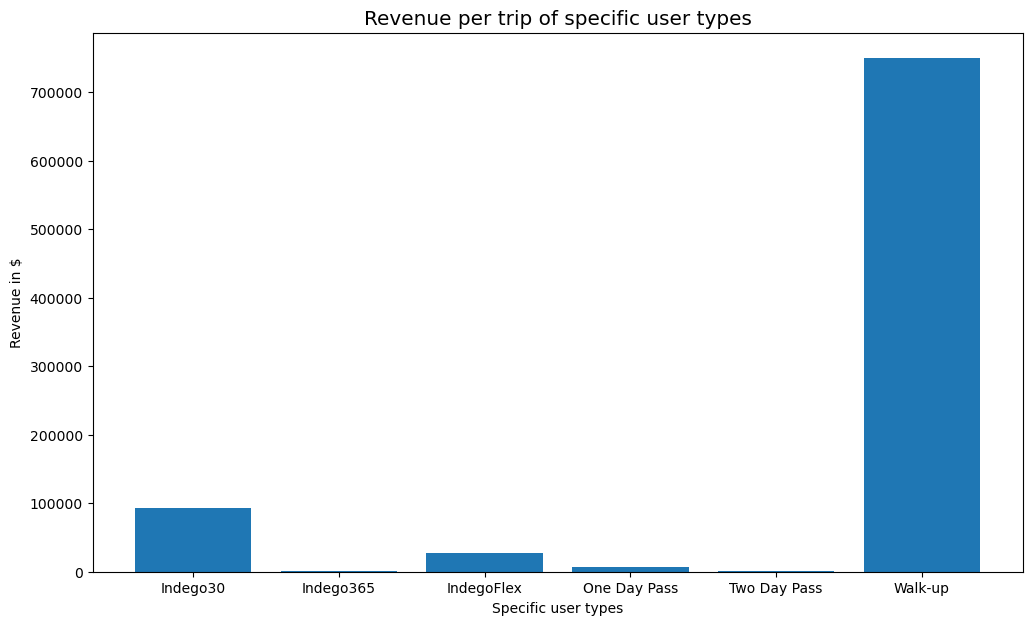

In [130]:
# Plotting revenue per trip based on user type
df_phil_revenue_type = df_phil_revenue_plt.copy()

# Resample based on user_type and calculate the sum of each user_type
df_phil_revenue_type = df_phil_revenue_type.groupby(['user_type']).sum().reset_index()

# Plotting
fig = plt.figure(figsize=(12,7))
plt.bar(df_phil_revenue_type['user_type'], df_phil_revenue_type['revenue_in_$'])

# Styling the plot
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xlabel('Specific user types', size = 'medium')
plt.ylabel('Revenue in $', size = 'medium')
plt.title('Revenue per trip of specific user types', size = 'x-large')
plt.show()

The most income as seen in the plot above is created by the user_type "Walk-up", since this user_type also doesnt have any kind of free one hour or half an hour usage, like "Indego30" or "Indego365". The "Two Day Pass" was only availabe in the month of August, "Indego365" since the month of October and the "One Day Pass" since the month of June, hence why these three user_types have a relatively low revenue.

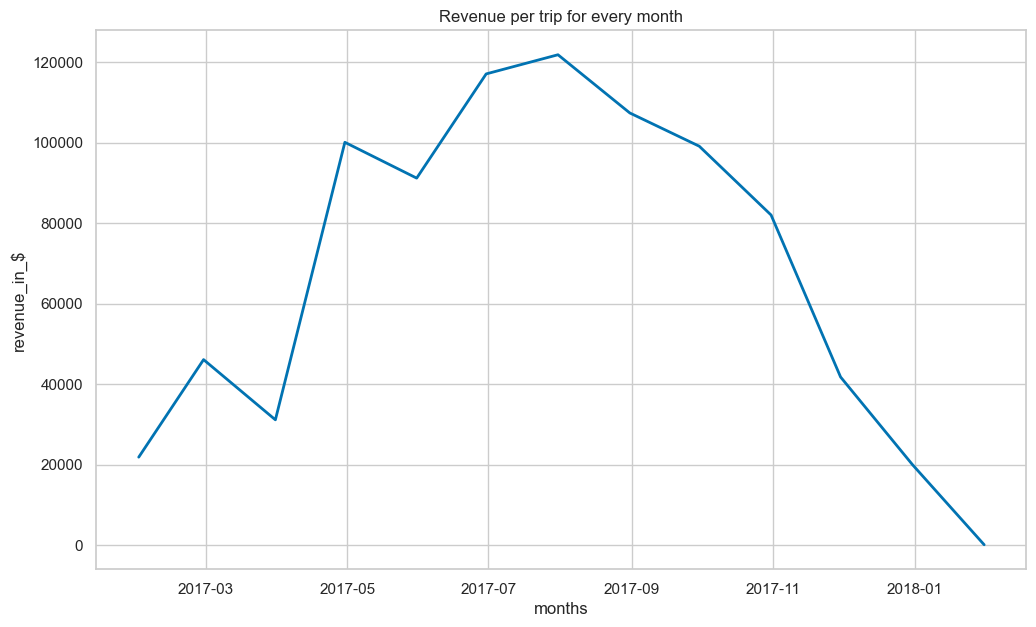

In [131]:
# Plotting the revenue for every month
sns.set(style='whitegrid', palette='colorblind', rc={'lines.linewidth': 2})

# Resampling the data to a monthly format
df_phil_revenue_plt_monthly = df_phil_revenue_plt.resample('M').sum()
df_phil_revenue_plt_monthly.index.rename('months', inplace=True)

#Plotting 
fig, ax = plt.subplots(figsize = (12,7))
plot_monthly = sns.lineplot(x = df_phil_revenue_plt_monthly.index, y = 'revenue_in_$', data = df_phil_revenue_plt_monthly)
plt.title('Revenue per trip for every month')
plt.show()

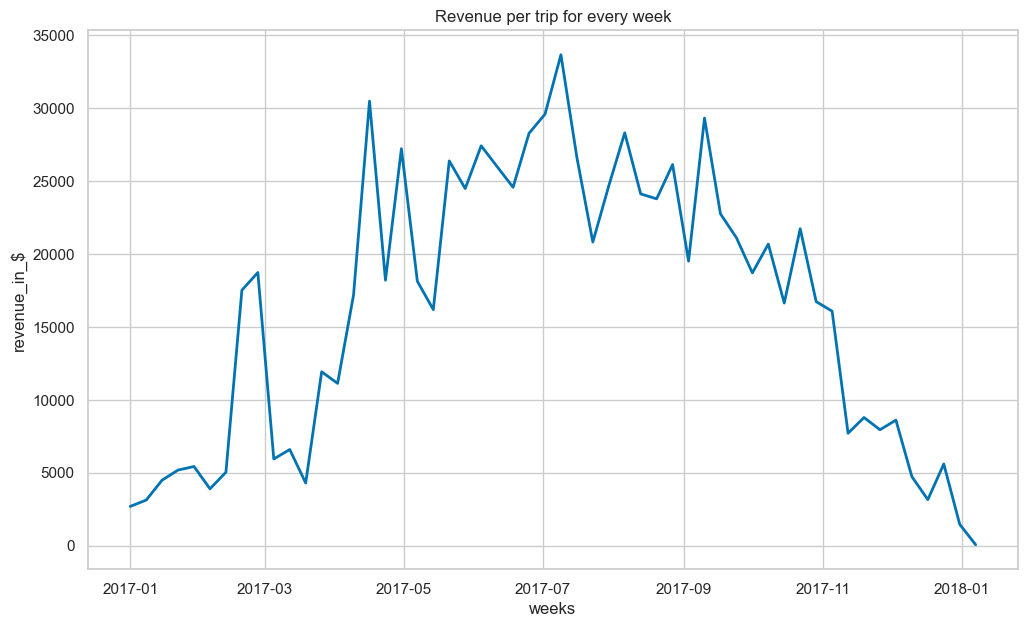

In [132]:
# Plotting the revenue for every week
sns.set(style='whitegrid', palette='colorblind', rc={'lines.linewidth': 2})

# Resampling the data to a weekly format
df_phil_revenue_plt_weekly = df_phil_revenue_plt.resample('W').sum()
df_phil_revenue_plt_weekly.index.rename('weeks', inplace = True)

#Plotting 
fig, ax = plt.subplots(figsize = (12,7))
plot_monthly = sns.lineplot(x = df_phil_revenue_plt_weekly.index, y = 'revenue_in_$', data = df_phil_revenue_plt_weekly)
plt.title('Revenue per trip for every week')
plt.show()

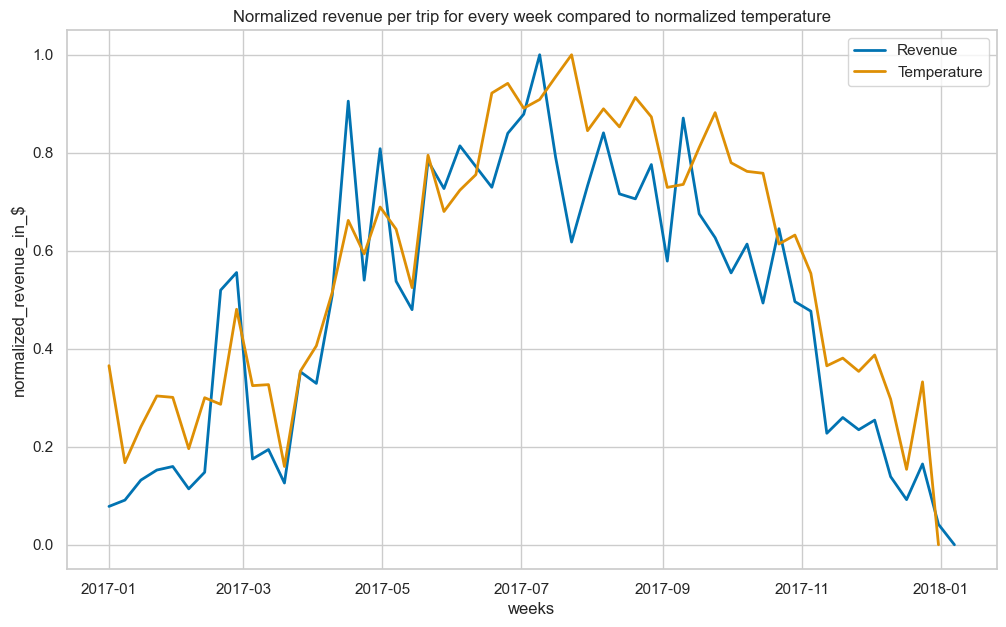

In [133]:
# Plotting the normalized revenue for every week in comparisent to the temperature
sns.set(style='whitegrid', palette='colorblind', rc={'lines.linewidth': 2})

# Preparing weather data
df_phil_revenue_weather = df_weather_2017.copy()
df_phil_revenue_weather.drop('max_temp', axis = 1, inplace = True)
df_phil_revenue_weather.drop('precip', axis = 1, inplace = True)
df_phil_revenue_weather.set_index('date_time', inplace = True)
df_phil_revenue_weather = df_phil_revenue_weather.resample('W').mean()

# Normalizing data
df_phil_revenue_plt_weekly['normalized_revenue_in_$'] = (df_phil_revenue_plt_weekly[['revenue_in_$']] - df_phil_revenue_plt_weekly[['revenue_in_$']].min(axis=0)) / (df_phil_revenue_plt_weekly[['revenue_in_$']].max(axis=0) - df_phil_revenue_plt_weekly[['revenue_in_$']].min(axis=0))
df_phil_revenue_weather['normalized_min_temp'] = (df_phil_revenue_weather[['min_temp']] - df_phil_revenue_weather[['min_temp']].min(axis=0)) / (df_phil_revenue_weather[['min_temp']].max(axis=0) - df_phil_revenue_weather[['min_temp']].min(axis=0))

#Plotting 
fig, ax = plt.subplots(figsize = (12,7))
plot_monthly = sns.lineplot(x = df_phil_revenue_plt_weekly.index, y = 'normalized_revenue_in_$', data = df_phil_revenue_plt_weekly)
plot_temp = sns.lineplot(x = df_phil_revenue_weather.index, y = 'normalized_min_temp', data = df_phil_revenue_weather)
ax.legend(['Revenue', 'Temperature'])
plt.title('Normalized revenue per trip for every week compared to normalized temperature')
plt.show()

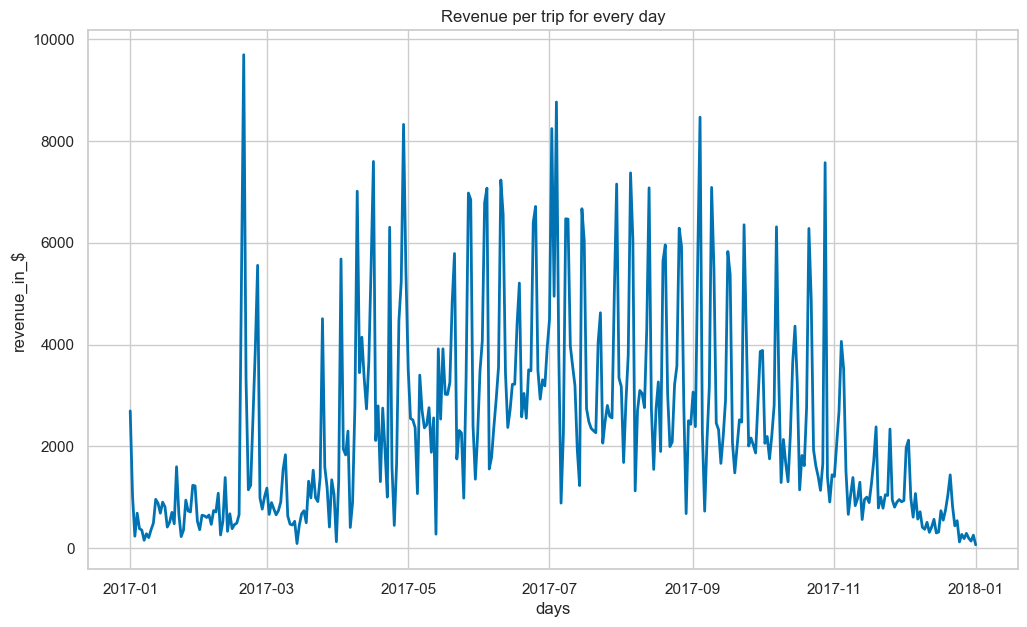

In [134]:
# Plotting the revenue for every day
sns.set(style='whitegrid', palette='colorblind', rc={'lines.linewidth': 2})

# Resampling the data to daily format
df_phil_revenue_plt_daily = df_phil_revenue_plt.resample('D').sum()
df_phil_revenue_plt_daily.index.rename('days', inplace = True)

#Plotting 
fig, ax = plt.subplots(figsize = (12,7))
plot_monthly = sns.lineplot(x = df_phil_revenue_plt_daily.index, y = 'revenue_in_$', data = df_phil_revenue_plt_daily)
plt.title('Revenue per trip for every day')
plt.show()

With the seasons changing and therefore rising temperature towards summer and decreasing temperature afterwards, we see a trend of the revenue first rising until August and then starting to drastically decrease. The number of tourists could also have an impact on the rise of the revenue curve in quarter 2 and the decline after quarter 3, since quarter 2 and quarter 3 show the highest numbers of tourists (as seen in the development of bike rental demand).

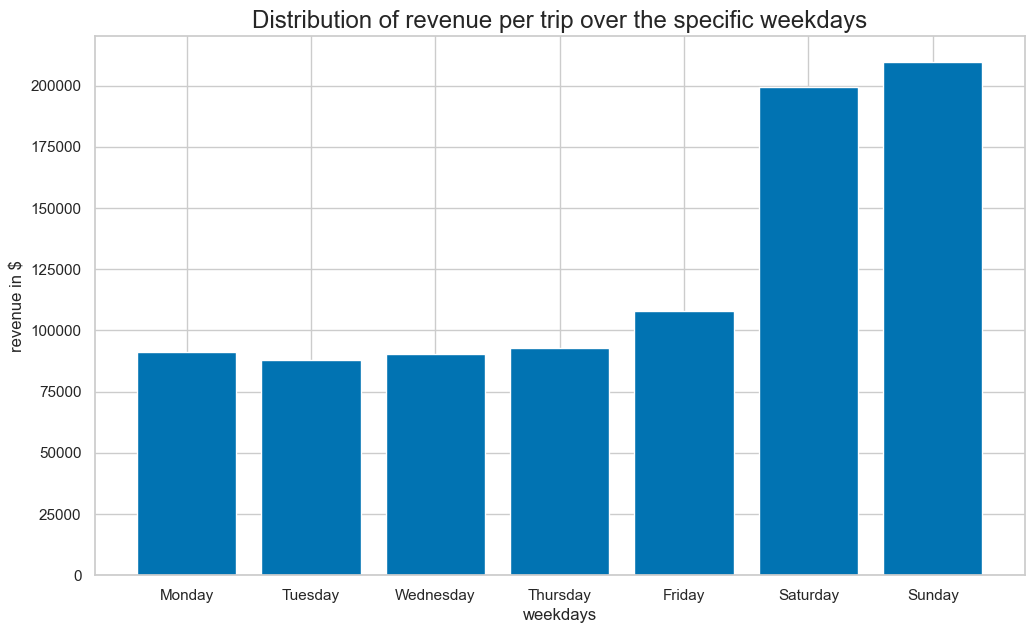

In [135]:
# Plotting revenue based on weekday
df_phil_revenue_plt_weekday = df_phil_revenue_plt.copy()

# Data needs to be grouped by weekday and replaced with their corresponding weekday name
df_phil_revenue_plt_weekday = df_phil_revenue_plt_weekday.groupby(['weekday']).sum(numeric_only=True).reset_index()
df_phil_revenue_plt_weekday['weekday'].replace([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], inplace=True)

# Plotting
fig = plt.figure(figsize=(12,7))
plt.bar(df_phil_revenue_plt_weekday['weekday'], df_phil_revenue_plt_weekday['revenue_in_$'])

# Styling the plot
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xlabel('weekdays', size = 'medium')
plt.ylabel('revenue in $', size = 'medium')
plt.title('Distribution of revenue per trip over the specific weekdays', size = 'x-large')
plt.show()

The weekend seems to be the time where the biggest amount of revenue is produced. Most of these people probably do not use the service very often, so they do not have any subscription model and most likely use the "Walk-up", which could explain the big jump from friday to saturday in revenue. The highest peak is at sunday. However the number of rides/rentals are higher from Monday to Friday (during the week). This leads us to the assumption, that most people who have a subscription are people who use the bike rental to get to work/university/school. 

## Predictive Analytics

##### Features
- day_of_month
- day_of_week 
- hour_of_day 
- month 
- avg_temp (min and max temp don't differ much)
- precipitation

We chose day of the week as a feature because it became clear in the descriptive analytics part that the weekday has an effect on the bike-rental demand. Especially on the weekends the demand is much lower. It would also be possible to convert the variable into a binary one (weekend) to only check if the respective day falls into the weekend. However, we would then lose some information because even on some days during the week the demand is slightly higher than on other days. Besides that Du et. al. also used the feature day of the week to forecast bike rental demand.  

The descriptive analytics part also showed that the hour of the day has also an effect on the rental demand. Especially during the night the demand is low and we have peaks at the rush hours (8 am and 5 pm).  

Besides that, the demand seems to differ dependent on the month. For the summer months, we clearly see an increase in the bike rental demand.   To use this information we decided to include it as a feature in our models.
The min and max temperature for one hour do not differ much and thus have a high correlation which we wanted to remove. Thus we decided to work with the average temperature for the respective hours.  

Besides that precipitation seems to also have an effect on the demand. The number of rentals and also the summed rental durations are higher for no precipitation records.

Du et al. paper from Standford Univesity: http://cs229.stanford.edu/proj2014/Jimmy%20Du,%20Rolland%20He,%20Zhivko%20Zhechev,%20Forecasting%20Bike%20Rental%20Demand.pdf

### Prepare Dataframe

In [157]:
df_prediction_hourly = df_philadelphia_cleaned.copy()
df_prediction_hourly.set_index('start_time', inplace=True)
df_prediction_hourly = df_prediction_hourly.loc[:, ["day", "month", "weekday", "hour"]]

df_prediction_trips_hourly = df_prediction_hourly.resample('H').size().copy()
df_prediction_hourly = df_prediction_hourly.resample('H').sum()

df_prediction_hourly['weekday'] = df_prediction_hourly.index.weekday
df_prediction_hourly['month'] = df_prediction_hourly.index.month
df_prediction_hourly['hour'] = df_prediction_hourly.index.hour
df_prediction_hourly['day'] = df_prediction_hourly.index.day

df_prediction_hourly.index.names = ["time"]
display(df_prediction_hourly)

day  month  weekday  hour
time                                          
2017-01-01 00:00:00    1      1        6     0
2017-01-01 01:00:00    1      1        6     1
2017-01-01 02:00:00    1      1        6     2
2017-01-01 03:00:00    1      1        6     3
2017-01-01 04:00:00    1      1        6     4
...                  ...    ...      ...   ...
2017-12-31 19:00:00   31     12        6    19
2017-12-31 20:00:00   31     12        6    20
2017-12-31 21:00:00   31     12        6    21
2017-12-31 22:00:00   31     12        6    22
2017-12-31 23:00:00   31     12        6    23

[8760 rows x 4 columns]

In [158]:
df_prediction_hourly = df_prediction_hourly[~df_prediction_hourly.apply(lambda x: x.isnull().any(), axis=1)]

In [160]:
#merge the weather data
df_weather = df_weather_2017.copy()
df_weather = df_weather.loc[:, ["date_time","max_temp", "min_temp", "precip"]]
df_merge = pd.merge(df_prediction_hourly, df_weather, left_index=True, right_on="date_time").set_index("date_time")
df_merge["avg_temp"] = df_merge[["max_temp", "min_temp"]].mean(axis=1)
df_merge

day  month  weekday  hour  max_temp  min_temp  precip  \
date_time                                                                    
2017-01-01 00:00:00    1      1        6     0       6.1       6.1     0.0   
2017-01-01 01:00:00    1      1        6     1       6.1       6.1     0.0   
2017-01-01 02:00:00    1      1        6     2       6.7       6.7     0.0   
2017-01-01 03:00:00    1      1        6     3       7.2       7.2     0.0   
2017-01-01 04:00:00    1      1        6     4       7.8       7.8     0.0   
...                  ...    ...      ...   ...       ...       ...     ...   
2017-12-31 19:00:00   31     12        6    19      -8.9      -8.9     0.0   
2017-12-31 20:00:00   31     12        6    20      -8.9      -8.9     0.0   
2017-12-31 21:00:00   31     12        6    21      -9.4      -9.4     0.0   
2017-12-31 22:00:00   31     12        6    22     -10.0     -10.0     0.0   
2017-12-31 23:00:00   31     12        6    23     -10.0     -10.0     0.0   

                     avg_temp  
date_time                      
2017-01-01 00:00:00       6.1  
2017-01-01 01:00:00       6.1  
2017-01-01 02:00:00       6.7  
2017-01-01 03:00:00       7.2  
2017-01-01 04:00:00       7.8  
...                       ...  
2017-12-31 19:00:00      -8.9  
2017-12-31 20:00:00      -8.9  
2017-12-31 21:00:00      -9.4  
2017-12-31 22:00:00     -10.0  
2017-12-31 23:00:00     -10.0  

[8760 rows x 8 columns]

In [190]:
#split into dependent and independent variables
y = df_prediction_trips_hourly.copy()
X = df_merge.drop(["min_temp", "max_temp"], axis=1).copy()

day  month  weekday  hour  precip  avg_temp
date_time                                                       
2017-01-01 00:00:00    1      1        6     0     0.0       6.1
2017-01-01 01:00:00    1      1        6     1     0.0       6.1
2017-01-01 02:00:00    1      1        6     2     0.0       6.7
2017-01-01 03:00:00    1      1        6     3     0.0       7.2
2017-01-01 04:00:00    1      1        6     4     0.0       7.8
...                  ...    ...      ...   ...     ...       ...
2017-12-31 19:00:00   31     12        6    19     0.0      -8.9
2017-12-31 20:00:00   31     12        6    20     0.0      -8.9
2017-12-31 21:00:00   31     12        6    21     0.0      -9.4
2017-12-31 22:00:00   31     12        6    22     0.0     -10.0
2017-12-31 23:00:00   31     12        6    23     0.0     -10.0

[8760 rows x 6 columns]

In [183]:
#create test and train and validation set

# Do a 70-30 split first
X_train_hold, X_test, y_train_hold, y_test = train_test_split(X, y, test_size=0.3,random_state=34)

# now split X_train to achive 50-20-30 split
X_train, X_hold, y_train, y_hold = train_test_split(X_train_hold, y_train_hold, test_size=(0.2/0.7),random_state=34)

print("length of X_train: ", len(X_train))
print("length of X_hold: ", len(X_hold))
print("length of X_test: ", len(X_test))
print("length of X_train_hold: ", len(X_train_hold))


length of X_train:  4379
length of X_hold:  1753
length of X_test:  2628
length of X_train_hold:  6132


#### Testing Linear Regression

In [166]:
#Plotting function

def plot_prediction(X_tr, y_tr, X_te, y_pr, column, figsize=(8,6), alpha=0.4):
    plt.figure(figsize=figsize)
    plt.title("Observed vs predicted demand for " + column + " feature")
    plt.scatter(X_tr[column], y_tr, marker="x", c='royalblue', alpha=alpha)
    plt.xlabel(column)
    plt.ylabel("Demand (in trips per hour)")
    plt.scatter(X_te[column], y_pr, marker="x", c='coral', alpha=alpha)
    plt.legend(['Observed data', 'fitted data'])

def plot_matrix(X_tr, y_tr, X_te, y_pr, path=None, figsize=(20,4), alpha=0.4):
    xs = np.linspace(0,100,100)
    fig, axs = plt.subplots(nrows=1, ncols=len(X_tr.columns), figsize=figsize)
    plt.suptitle("Observed vs predicted demand for each feature")
    axs[0].set_ylabel("Demand (in trips per hour)")
    axs[0].scatter(X_tr[X_tr.columns[0]], y_tr, marker="x", c='royalblue', alpha=alpha)
    axs[0].scatter(X_te[X_tr.columns[0]], y_pr, marker="x", c='coral', alpha=alpha)
    axs[0].set_xlabel(X_tr.columns[0])
    axs[0].legend(['Observed data', 'fitted data'])
    for i in range(1,len(X_tr.columns)):
        axs[i].scatter(X_tr[X_tr.columns[i]], y_tr, marker="x", c='royalblue', alpha=alpha)
        axs[i].scatter(X_te[X_tr.columns[i]], y_pr, marker="x", c='coral', alpha=alpha)
        axs[i].set_xlabel(X_tr.columns[i])
    fig.tight_layout()
    if (path != None):
        #Create directory if it does not exist
        if not os.path.exists(os.path.dirname("plots/")):
            os.makedirs(os.path.dirname("plots/"))

        plt.savefig(f"plots/{path}")
        plt.close(fig)

In [167]:
#Metrics function

def get_metrics(y_train, y_pred_train, y_test, y_pred_test):

    return {
            "MAE": {
                    "train": mean_absolute_error(y_train, y_pred_train),
                    "test": mean_absolute_error(y_test, y_pred_test)
                }, 
            "r2": {
                    "train": r2_score(y_train, y_pred_train),
                    "test": r2_score(y_test, y_pred_test)
                }
    }

In [168]:
#Coefficients

def get_coefficients(model, columns):
        return pd.DataFrame(
                    {
                        "variable" : columns,
                        "coef": model.coef_
                    })
    

In [169]:
#Regression function

def linear_regression(X_train, y_train, X_test, y_test, plot, column, get_coef=None):   
    #Fitting
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    #Prediction on testing and training set
    y_pred_test = lin_reg.predict(X_test)
    y_pred_train = lin_reg.predict(X_train)
    y_pred_test[y_pred_test < 0] = 0
    y_pred_train[y_pred_train < 0] = 0
    
    if(plot):
        plot_prediction(X_train, y_train, X_train, y_pred_train, column)
        
    return (get_metrics(y_train, y_pred_train, y_test, y_pred_test),
            get_coefficients(lin_reg, X_train.columns) if get_coef else None,
            y_pred_test,
            y_pred_train)

{'MAE': {'train': 54.744098247645155, 'test': 54.97611158048973},
 'r2': {'train': 0.2621918680205052, 'test': 0.2704262717120339}}

variable       coef
0       day  -0.137528
1     month   2.157283
2   weekday  -3.885661
3      hour   3.833087
4    precip -30.494365
5  avg_temp   2.761623

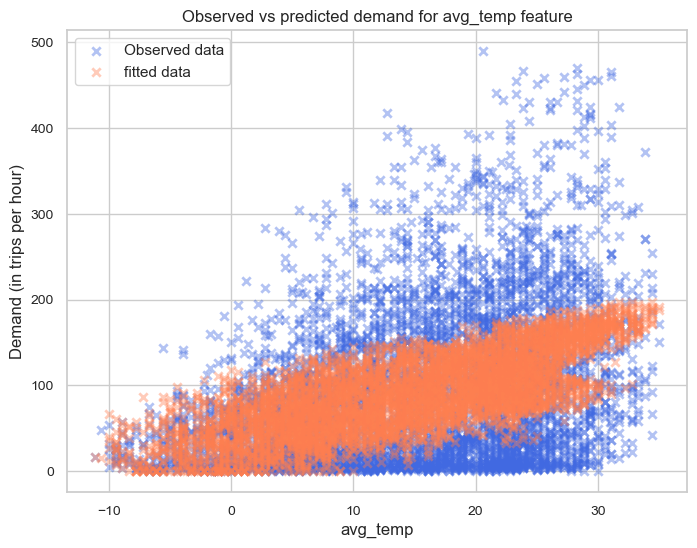

In [170]:
metrics, coef, _, __ = linear_regression(X_train_hold, y_train_hold, X_test, y_test, True, "avg_temp", True)
display(metrics, coef)

#### Testing Linear Regression with dummy variables

The usage of linear regression would not yield good results with the feature set we have. The descriptive analytics	part with its plots clearly shows that most features do not have a linear relationship with the dependent variable (bike rental demand). For example, for the feature of hour_of_day, we have two peaks of the bike rental demand which can not be represented bike a linear function. The only feature that seems to have a linear relationship with the dependent variable is the average temperature. We see an increasing demand with increasing temperature. 
But if we see the features day_of_week, hour_of_day, and month as categorical features, we could actually yield much better results. We decided to convert each of these features into multiple dummy variables. By doing so we would generate in the end linear model with multiple intercepts.

This approach has the following drawbacks: 
- we would increase the model complexity by increasing dimensionality
- we would lose the ordering of the features (features are actually ordinary)

In [171]:
X_train_hold.loc[:,["day", "month","weekday", "hour"]] = X_train_hold.loc[:,["day", "month", "weekday", "hour"]].astype(str)
X_test.loc[:,["day", "month", "weekday", "hour"]] = X_test.loc[:,["day", "month", "weekday", "hour"]].astype(str)
X_train_dum = pd.get_dummies(X_train_hold)
X_test_dum = pd.get_dummies(X_test)

{'MAE': {'train': 31.010299135172048, 'test': 32.41740317613204},
 'r2': {'train': 0.7292803017616616, 'test': 0.7071128791176333}}

variable          coef
0     precip -2.804936e+01
1   avg_temp  2.129337e+00
2      day_1  1.631652e+11
3     day_10  1.631652e+11
4     day_11  1.631652e+11
..       ...           ...
71    hour_5 -1.071723e+12
72    hour_6 -1.071723e+12
73    hour_7 -1.071723e+12
74    hour_8 -1.071723e+12
75    hour_9 -1.071723e+12

[76 rows x 2 columns]

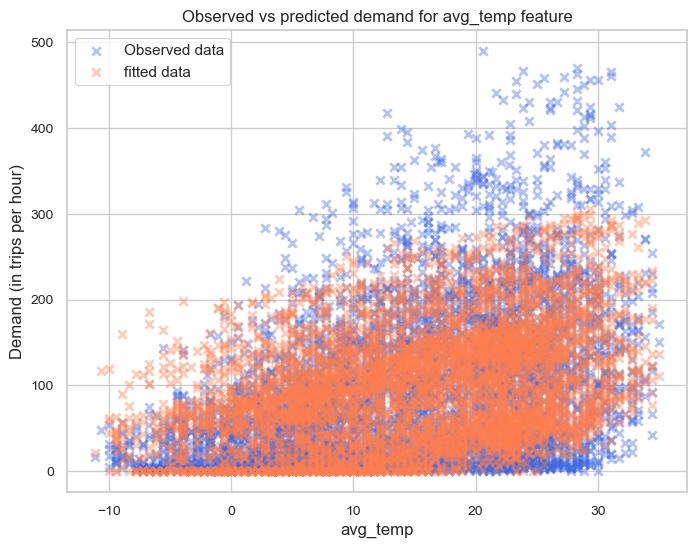

In [172]:
metrics, coef, _, __ = linear_regression(X_train_dum, y_train_hold, X_test_dum, y_test, True, "avg_temp", True)
display(metrics, coef)

#####  Results:
- the r2 score gives as information about the proportion of the variance of the dependent variable (the bike-rental demand) which can be explained by our model (the independent variables). This in this case for the test set 72.46 % of the variance of the bike rental demand can be explained through our model.
- besides that the means absolute error (how far was our prediction of the bike rental demand on average away from the actual value) is 31.46
- the coefficents for the different dummy variables can be interpreted as the different intercepts.

### Polynomial Regression

As stated above we have some features for which we don’t	have a linear relationship with the dependent variable. This non-linear relationship can be modeled using polynomial features through which we can better approximate the non-linear relationship.

In [173]:
def poly_regression(X_train, y_train, X_test, y_test, degree, plot=None, column=None):   # method can be r2 or MAE
    
    # initialize model
    poly_reg = PolynomialFeatures(degree)

    # fit and transform
    X_poly = poly_reg.fit_transform(X_train)
    X_poly_test = poly_reg.fit_transform(X_test)
    
    return linear_regression(X_poly, y_train, X_poly_test, y_test, plot, column)
    


def find_poly_regression(X_train, y_train, X_hold, y_hold, max_value):
    
    mae = {"hold": [], "train": []}
    r2 = {"hold": [], "train": []}
    
    array = np.arange(1,max_value +1)
    
    for i in array:
        metrics, _, __,___ = poly_regression(X_train, y_train, X_hold, y_hold, i)
        mae["hold"].append(metrics["MAE"]["test"]) 
        mae["train"].append(metrics["MAE"]["train"])
        r2["hold"].append(metrics["r2"]["test"]) 
        r2["train"].append(metrics["r2"]["train"])
    
    # plot results
    
    # plot results
    plt.figure(figsize = (8,6))
    plt.plot(array, mae["train"], label="train")
    plt.plot(array, mae["hold"], label="hold")
    plt.legend()
    plt.xlabel("Number of polynomials")
    plt.ylabel("MAE")
    plt.show()
    
    plt.figure(figsize = (8,6))
    plt.plot(array, r2["train"], label="train")
    plt.plot(array, r2["hold"], label="hold")
    plt.legend()
    plt.xlabel("Number of polynomials")
    plt.ylabel("r2")
    plt.show()

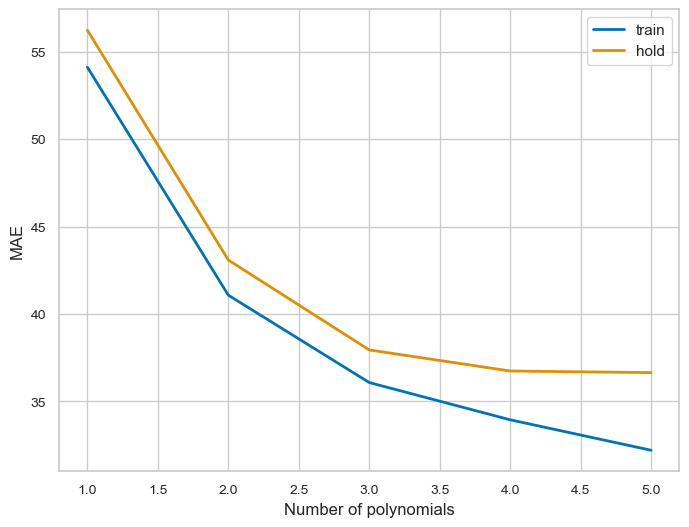

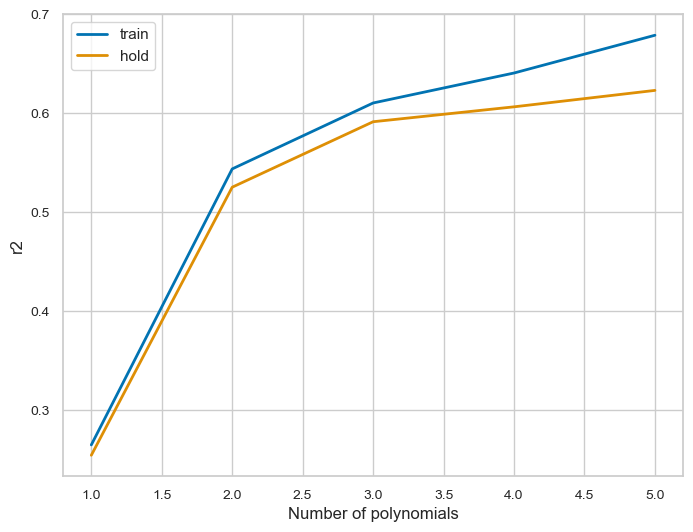

In [174]:
find_poly_regression(X_train, y_train, X_hold, y_hold, 5)

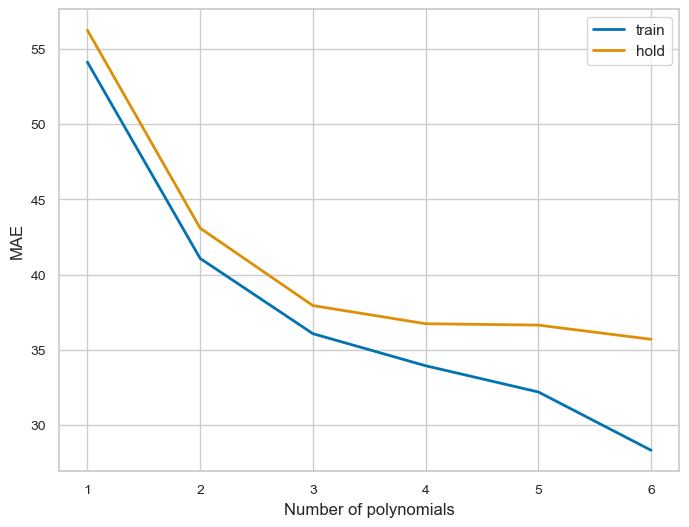

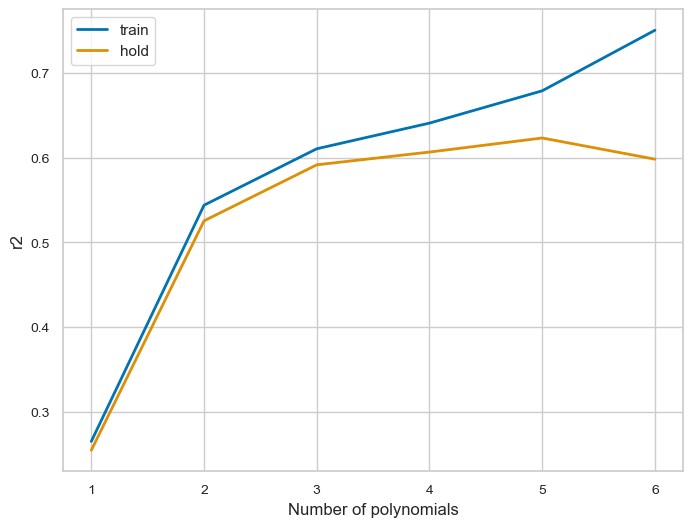

In [175]:
find_poly_regression(X_train, y_train, X_hold, y_hold, 6)

##### Selection of the degree of polynomials
For the polynomial of degree 5 we seem to yield the best results regarding the r2 score and mean absolute error. For a polynomial of degree 6 we can see that the mean absolut error rises and the r2 score drops. 

{'MAE': {'train': 32.20584204436163, 'test': 34.997592549589626},
 'r2': {'train': 0.6788039762068565, 'test': 0.6318523722591997}}

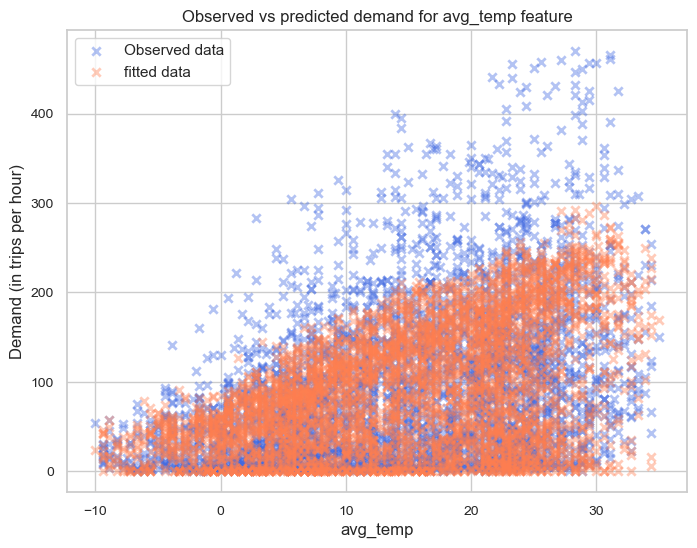

In [176]:
metrics, _, y_pred_test, y_pred_train = poly_regression(X_train, y_train, X_test, y_test, 5)
display(metrics)
plot_prediction(X_train, y_train, X_train, y_pred_train, "avg_temp")

##### Results:
- the r2 score gives as information about the proportion of the variance of the dependent variable (the bike-rental demand) which can be explained by our model (the independent variables). This in this case for the test set 64.40 % of the variance of the bike rental demand can be explained through our model.
- besides that the means absolute error (how far was our prediction of the bike rental demand on average away from the actual value) is 35.03

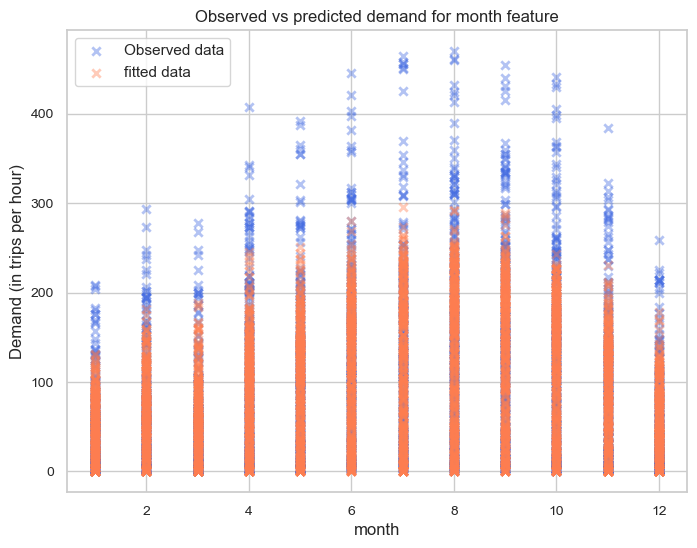

In [177]:
plot_prediction(X_train, y_train, X_train, y_pred_train, "month")

### Ridge Regression follow-up to Polynomial Regression

We use ridge regression with polynomial features. One of the advantages of using ridge regression is that we can use a higher degree of polynomial features with less overfitting because of the L2 regularization which could lead to a better performing model. The biggest drawback is the needed computing power and ram usage which increases exponentially for each degree. The need of exponentially higher computing power makes it harder to cross validate the different hyperparameters. Ridge regression also needs more data preparation than other models like normalizing the datasets.

#### Normalizing variables

In [212]:
sc = MinMaxScaler()
X_norm = sc.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)
# Do a 70-30 split first
X_train_hold, X_test, y_train_hold, y_test = train_test_split(X_norm, y, test_size=0.3,random_state=34 )

# now split X_train to achive 50-20-30 split
X_train, X_hold, y_train, y_hold = train_test_split(X_train_hold, y_train_hold, test_size=(0.2/0.7),random_state=34 )

In [213]:
def ridge_regression(X_train, y_train, X_hold, y_hold, degree, al, plot, column, method):  #method can be r2 or MAE
    # initialize model
    poly_reg = PolynomialFeatures(degree)
    ridge_reg = Ridge(alpha = al) 
    
    # fit and transform
    X_poly = poly_reg.fit_transform(X_train)
    X_poly_hold = poly_reg.fit_transform(X_hold)

    ridge_reg.fit(X_poly, y_train)
    y_pred_hold = ridge_reg.predict(X_poly_hold)
    y_pred_train = ridge_reg.predict(X_poly)
    y_pred_hold[y_pred_hold < 0] = 0
    y_pred_train[y_pred_train < 0] = 0
    
    if(plot):
        plot_prediction(X_train, y_train, X_train, y_pred_train, column)
        
    if(method == "MAE"):
        errors = [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_hold, y_pred_hold)]
        return errors, ridge_reg, y_pred_hold, y_pred_train
    elif(method == "r2"):
        r2_scores = [r2_score(y_train, y_pred_train), r2_score(y_hold, y_pred_hold)]
        return r2_scores, ridge_reg, y_pred_hold, y_pred_train
    elif(method == "all"):
        r2_scores = [r2_score(y_train, y_pred_train), r2_score(y_hold, y_pred_hold)]
        errors = [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_hold, y_pred_hold)]
        return errors, r2_scores, ridge_reg, y_pred_hold, y_pred_train
    else:
        return "Please select r2 or MAE as method"


def find_ridge_regression_degree(X_train, y_train, X_hold, y_hold, min_value, max_value, al):
    
    error_train = []
    error_hold = []
    array = np.arange(min_value, max_value +1)
    
    for i in array:
        errors, ridge_reg, y_pred_hold, y_pred_train = ridge_regression(X_train, y_train, X_hold, y_hold, i, al, False, "weekday", "r2")
        error_train.append(errors[0])
        error_hold.append(errors[1])
    
    # plot results
    plt.figure(figsize = (8,6))
    plt.plot(array, error_train, label="train")
    plt.plot(array, error_hold, label="hold")
    plt.legend()
    plt.xlabel("Degree of polynomials")
    plt.ylabel("r2 Score")
    plt.show()


def find_ridge_regression_alpha(X_train, y_train, X_hold, y_hold, degree):
    # initialize model
    poly_reg = PolynomialFeatures(degree)
    
    # fit
    X_poly_train = poly_reg.fit_transform(X_train)
    X_poly_hold = poly_reg.fit_transform(X_hold)

    clf = RidgeCV(alphas=[1e-6,1e-5,1e-4,1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]).fit(X_poly_train, y_train)
    y_pred_hold = clf.predict(X_poly_hold)
    print(f"Optimal Alpha: {clf.alpha_}")
    print(f"R2 score: {r2_score(y_hold, y_pred_hold)}")
    print(f"Mean Squared Error: {mean_squared_error(y_hold, y_pred_hold)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_hold, y_pred_hold)}")


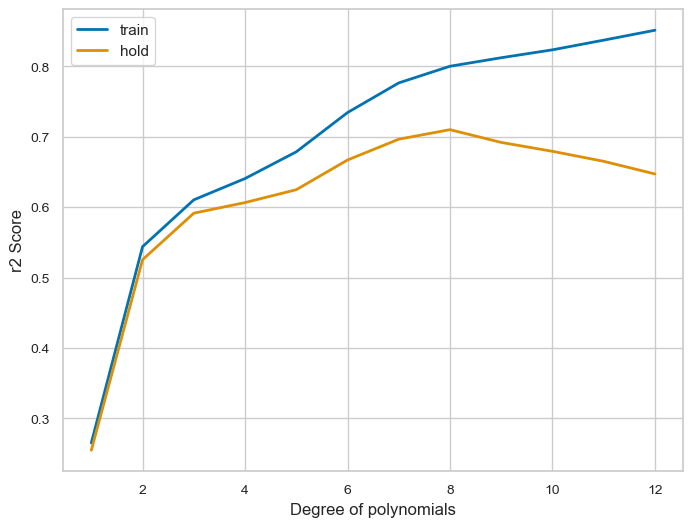

In [215]:
find_ridge_regression_degree(X_train, y_train, X_hold, y_hold,1, 12, 1e-5)

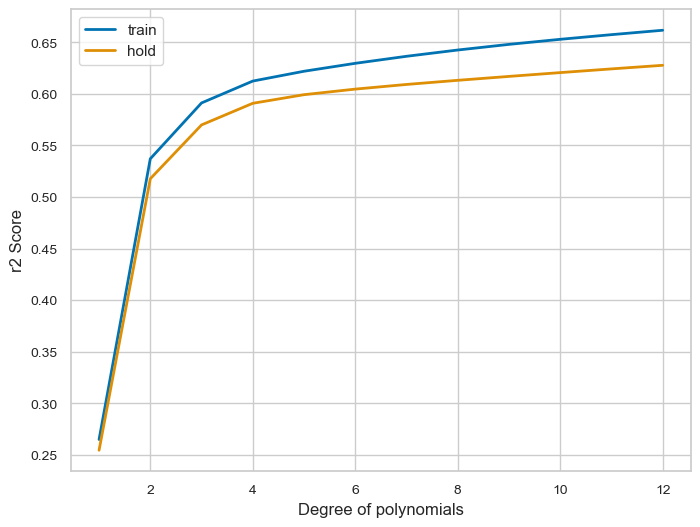

In [216]:
find_ridge_regression_degree(X_train, y_train, X_hold, y_hold,1, 12, 1)

As we can see a regularization can lead to better performance for higher degrees.

In [218]:
find_ridge_regression_alpha(X_train, y_train,X_hold,y_hold, 12)

Optimal Alpha: 0.01
R2 score: 0.6649360737726692
Mean Squared Error: 2579.0986763194537
Mean Absolute Error: 34.4128850947323


R2_train:  0.7373239202240667
R2_test:  0.6450176235475358
MAE_train:  28.49407694614421
MAE_test:  32.58821375739308


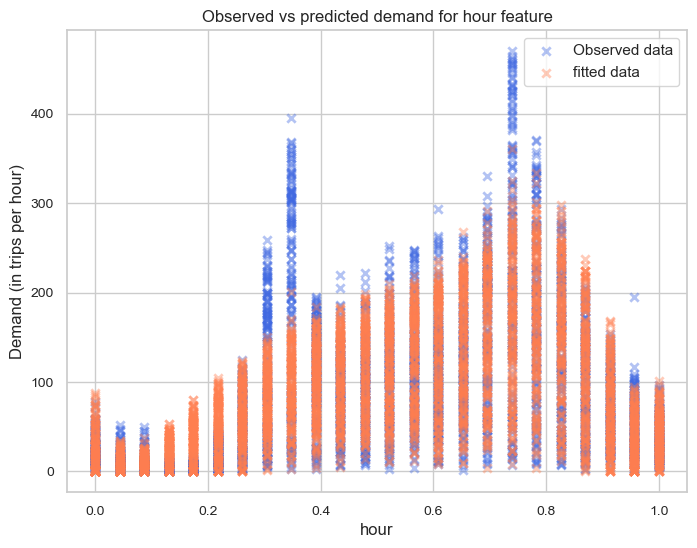

In [220]:
errors_ridge, r2_scores_ridge, ridge_reg, y_pred_hold, y_pred_train = ridge_regression(X_train, y_train, X_test, y_test, 12, 0.01, True, 'hour', "all")
print("R2_train: ", r2_scores_ridge[0])
print("R2_test: ", r2_scores_ridge[1])
print("MAE_train: ", errors_ridge[0])
print("MAE_test: ", errors_ridge[1])

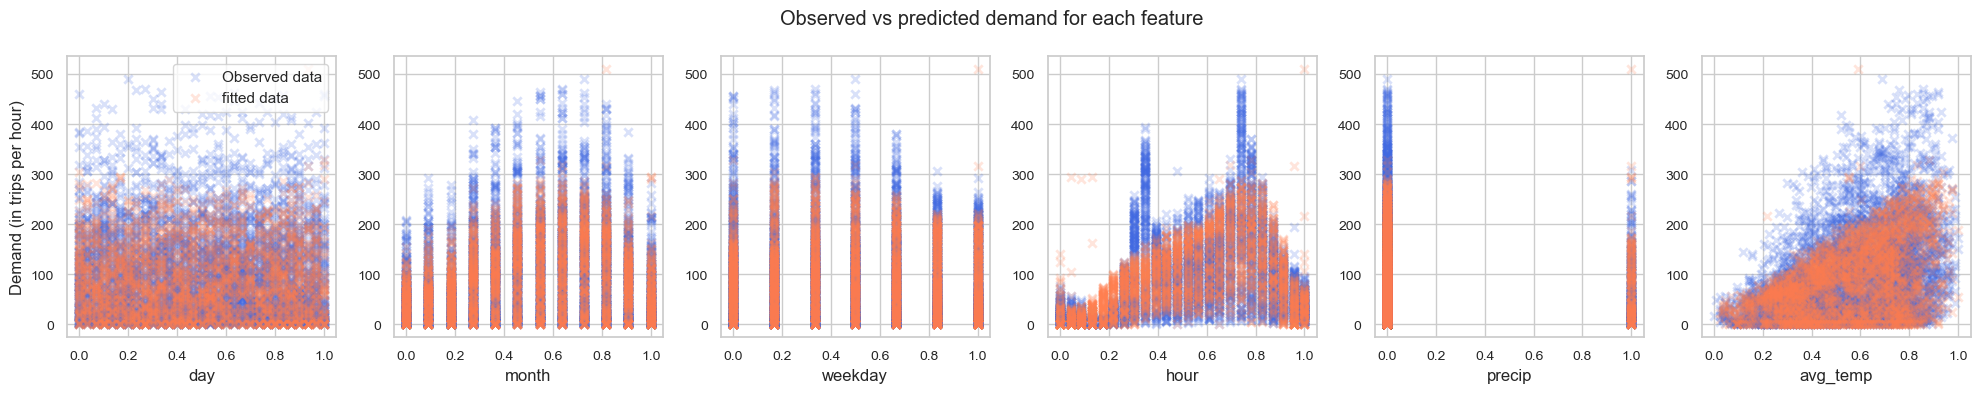

In [221]:
plot_matrix(X_train_hold, y_train_hold, X_test, y_pred_hold, alpha=0.2)
plot_matrix(X_train_hold, y_train_hold, X_test, y_pred_hold, path="ridge_matrix.png", figsize=(35,7), alpha=0.3)

### Decision Tree Regression

The advantages of decision tree regression are that it needs less data preparations. For example the data set does not need to be normalized like in the ridge regression. Furthermore decision trees are easy to visualize and explainable to third parties making them easier to understand. The disadvantages are that decision trees are likely to overfit increasing the test set error while lowering the train set error. With our data set it computed relatively fast in comparison to ridge but it could also get more complex for more data entries and higher tree depth.

In [222]:
def tree_regression(X_train, y_train, X_hold, y_hold, degree, plot, column, method):   # method can be r2 or MAE
    # initialize model
    tree_reg = DecisionTreeRegressor(max_depth=degree)
    tree_model = tree_reg.fit(X_train, y_train) 

    # fit
    y_pred_hold = tree_model.predict(X_hold)
    y_pred_train = tree_model.predict(X_train)
    y_pred_hold[y_pred_hold < 0] = 0
    y_pred_train[y_pred_train < 0] = 0
    
    if(plot):
        plot_prediction(X_train, y_train, X_train, y_pred_train, column)
    
    if(method == "MAE"):
        errors = [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_hold, y_pred_hold)]
        return errors, tree_model, y_pred_hold, y_pred_train
    elif(method == "r2"):
        r2_scores = [r2_score(y_train, y_pred_train), r2_score(y_hold, y_pred_hold)]
        return r2_scores, tree_model, y_pred_hold, y_pred_train
    elif(method == "all"):
        r2_scores = [r2_score(y_train, y_pred_train), r2_score(y_hold, y_pred_hold)]
        errors = [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_hold, y_pred_hold)]
        return errors, r2_scores, tree_model, y_pred_hold, y_pred_train
    else:
        return "Please select r2 or MAE as method"


def find_tree_regression(X_train, y_train, X_hold, y_hold, min_value, max_value):
    
    error = []
    error_train = []
    error_hold = []
    array = np.arange(min_value, max_value + 1)
    
    for i in array:
        errors, tree_model, y_pred_hold, y_pred_train = tree_regression(X_train, y_train, X_hold, y_hold, i, False, "weekday", "r2")
        error_train.append(errors[0])
        error_hold.append(errors[1])
    
    # plot results
    plt.figure(figsize = (8,6))
    plt.plot(array, error_train, label="train")
    plt.plot(array, error_hold, label="hold")
    plt.legend()
    plt.xlabel("Max Depth")
    plt.ylabel("r2")
    plt.show()

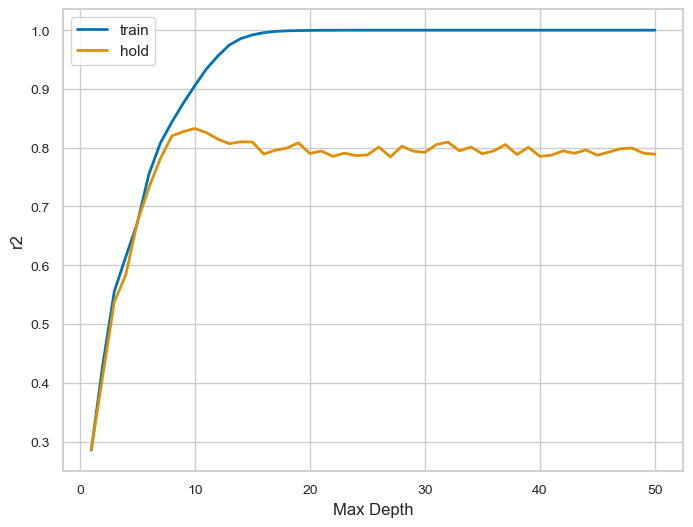

In [223]:
find_tree_regression(X_train, y_train, X_hold, y_hold, 1, 50)

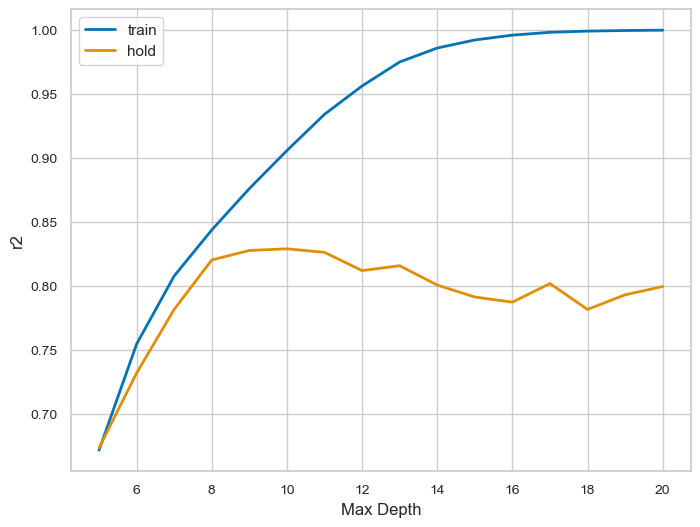

In [224]:
find_tree_regression(X_train, y_train, X_hold, y_hold, 5, 20)

R2_train:  0.9053338389962227
R2_hold:  0.8378920668398521
MAE_train:  15.136545794386675
MAE_hold:  21.247409296601838


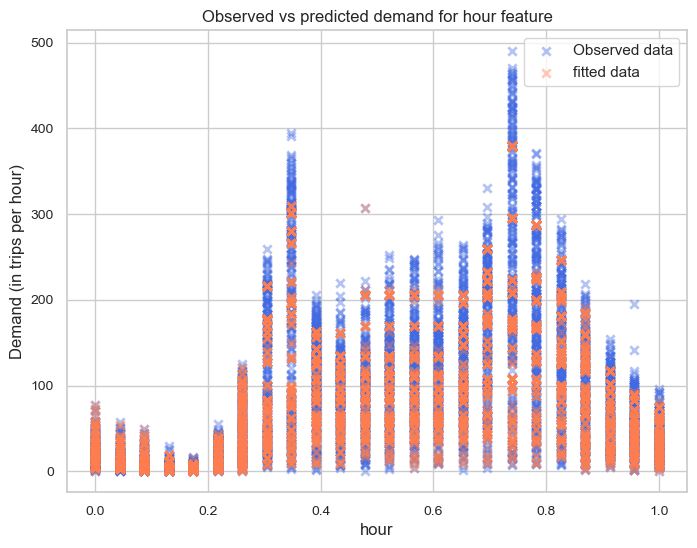

In [225]:
errors_tree, r2_scores_tree, tree_model, y_pred_hold, y_pred_train = tree_regression(X_train_hold, y_train_hold, X_test, y_test, 10, True, 'hour', "all")
print("R2_train: ", r2_scores_tree[0])
print("R2_hold: ", r2_scores_tree[1])
print("MAE_train: ", errors_tree[0])
print("MAE_hold: ", errors_tree[1])

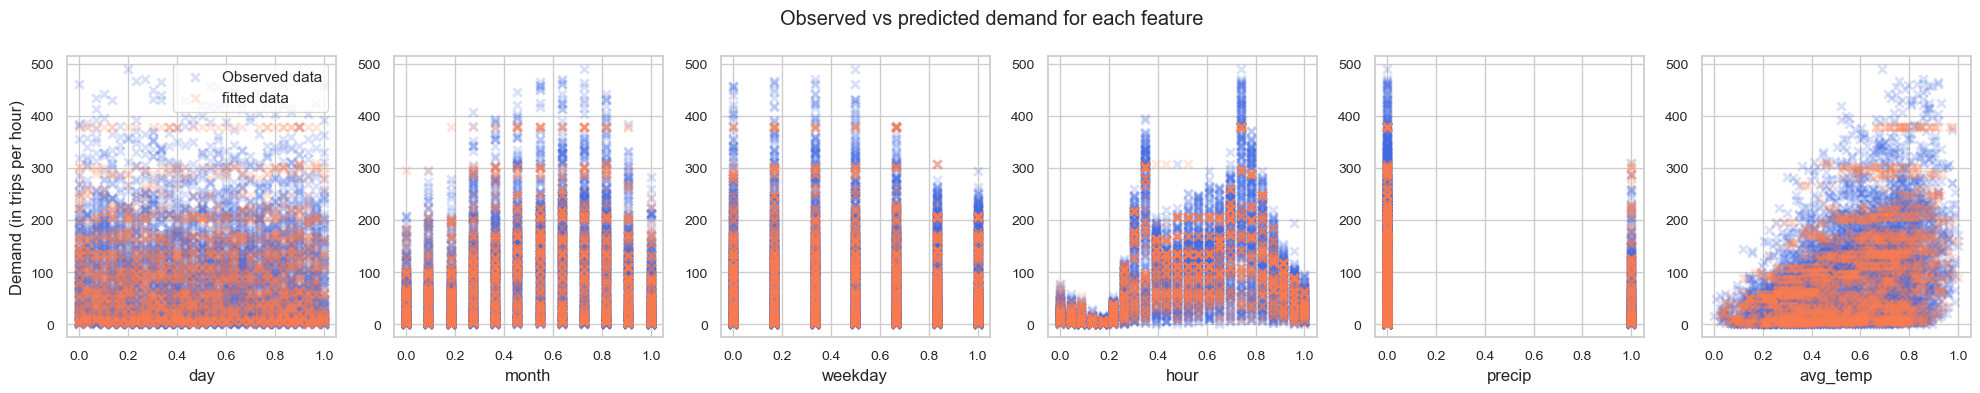

In [226]:
plot_matrix(X_train_hold, y_train_hold, X_test, y_pred_hold, alpha=0.2)
plot_matrix(X_train_hold, y_train_hold, X_test, y_pred_hold, path="tree_matrix.png", figsize=(35,7), alpha=0.3)

### Model Evaluation

In [228]:
# Summary of r2 scores and MAE
print("R2 scores trainings sets:")
print(" Ridge Regression: ", r2_scores_ridge[0])
print(" Decision Tree Regression: ", r2_scores_tree[0])

print("R2 scores test sets:")
print(" Ridge Regression: ", r2_scores_ridge[1])
print(" Decision Tree Regression: ", r2_scores_tree[1])
print("")
print("MAE trainings set:")
print(" Ridge Regression: ", errors_ridge[0])
print(" Decision Tree Regression: ", errors_tree[0])

print("MAE test set:")
print(" Ridge Regression: ", errors_ridge[1])
print(" Decision Tree Regression: ", errors_tree[1])

R2 scores trainings sets:
 Ridge Regression:  0.7373239202240667
 Decision Tree Regression:  0.9053338389962227
R2 scores test sets:
 Ridge Regression:  0.6450176235475358
 Decision Tree Regression:  0.8378920668398521

MAE trainings set:
 Ridge Regression:  28.49407694614421
 Decision Tree Regression:  15.136545794386675
MAE test set:
 Ridge Regression:  32.58821375739308
 Decision Tree Regression:  21.247409296601838


Comparing the r2 scores and MAE we can conclude that the decision tree model performs the best for both training and test set. For deployment we would use the decision tree model based on the performance metrics.

#### Outlook

The biggest limitation for the ridge regression is the limit in memory size. Ridge regression could be further improved by trying to optimize the feature selection and compressing the data or optimizing the memory usage of the data. Less features or combining features could lead to faster model training and even to better performing models if higher polynomial degrees could be possible.

For decision tree regression it could be beneficial training the model on a dataset with a longer interval and testing the impact of increasing demand. The model could perform much worse for later years if the demand patterns change over years.

In general it could be beneficial validating the models for different years to observe if less or more demand changes the performances of the model. If it does the model should be retrained for a given interval.